# Facebook friends recommender system


Dans ce projet nous proposons differentes méthodes de recommendation d'amis pour facebook.   
En effet, nous avons crée un environnement avec 4 agents :  
  -Random Agent  
  -Memory based Agent  
  -Linear_Rgression model Agent   
  -Knn Agent  
Nous traçons, dans chaque cas, la courbe du regret et on effectue finalement une comparaison entre les différents agents.

In [53]:
#import des bibiliothèques utilisées
import scipy.sparse as sparse
import random 
import pandas as pd
import numpy as np
import scipy 
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.layers import Dot
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors
import scipy.stats as stats

# **Environnement**

In [48]:
#Fonction nous renvoie une matrice sparse random et symétrique
def sprandsym(n, density):
    rvs = stats.norm().rvs
    X = sparse.random(n, n, density=density, data_rvs=rvs)
    upper_X = sparse.triu(X) 
    result = upper_X + upper_X.T - sparse.diags(X.diagonal())
    return result

In [49]:
#****************************Environnemment*********************************
class Env:

    def __init__(self, nb_users, seed=None):

        self.nb_users=nb_users
        #possible_match represente une matrice (nb_users*nb_users) où possible_match[i,j] contient 1 si user i et user j sont des amis et 0 sinon
        self.possible_match =np.identity((self.nb_users))
        #interactions une matrice sparse (nb_users*nb_users) où interactions[i,j] contient le degré d'amitié entre user i et user j (rate)
        self.interactions =  sprandsym(self.nb_users,0.25)
    
    def step(self):
        #On choisit un utilisateur au hasard
        currUserId =np.random.randint(low=0, high=self.nb_users)
        #On récupère la liste des utilisateurs avec qui l'utilisateur choisi n'est pas ami. 
        list_possible_friends= np.where(self.possible_match[currUserId,:]==0)[0]

        return currUserId, list_possible_friends
    
    def update(self, user, friend, reward, reward_recom_user):
        #Une fois une recommandation est faite on suppose que l'utilisateur accepte la recommandation et qu'il ajoute l'utilisateur recommandé
        #On met à jour possible_match (On met 1 entre le l'utilisateur et l'utilisateur recommandé)
        self.possible_match[user, friend] =1
        self.possible_match[friend, user] =1
        self.interactions = sparse.csr_matrix(self.interactions)
        #on met à jour la matrice d'interactions en entrant le reward réel (interaction après l'ajout)
        self.interactions[user, friend]=reward
        self.interactions[user, friend]=reward_recom_user
        
        #on retourne la nouvelle matrice des interactions
        return self.interactions
     
    def reset(self, seed=None):
        np.random.seed()
        self.interactions = sparse.random(nb_users, nb_users, density=0.25)
        #on suppose qu'on ne peut pas recommander à un utilisateur lui-même donc on suppose que interactions[i,i]=1 (qui est l'intéraction maximale)
        self.interactions.setdiag(np.ones(nb_users))
        self.interactions.toarray()
        rows = sparse.find(self.interactions)[0]
        cols = sparse.find(self.interactions)[1]
        #On remplit la matrice possible_match en accord avec la matrice d'intéractions créée
        possible_match =np.identity((self.nb_users))
        for i in range(len(rows)):
            possible_match[rows[i],cols[i]]=1
        self.possible_match = possible_match
        
        return self.possible_match, self.interactions
    
    def calc_real_reward(self, pred_reward ):
        #Comme nous n'avons pas de données historiques, on fait une foncion qui nous retourne le reward réel (l'interaction après ajout)
        #On génère un vecteur d'interactions réelles entre les utilisateurs qui contient des 0 et des 1. 
        #Chaque element du vecteur correspond à une feature : [P(interactions post=1)=0.4, P(chat=1)=0.5, P(visite du profil=1)=0.8]
        real_interactions = []
        real_interactions.append(np.random.choice(2, 1, p=[0.6, 0.4])[0])
        real_interactions.append(np.random.choice(2, 1, p=[0.5, 0.5])[0])
        real_interactions.append(np.random.choice(2, 1, p=[0.2, 0.8])[0])
        mean_interactions = np.sum(real_interactions)/3
        
        #le real reward est calculé nous donnons une pondération de 50% au reward estimé et une pondération de 50% au vecteur d'interaction généré dessus
        return (0.5*pred_reward + 0.5*mean_interactions)

In [74]:
#On définit le nombre d'utilisateurs à 200
nb_users = 200

# **Agents**

# 1. Random Agent

In [89]:
class RandomAgent:
    
    def __init__(self):
        pass
    
    def action(self, user_id, items_available):
        #on estime des rewards d'une manière random
        pred_rewards = np.random.rand(1,len(items_available))[0]
        #On choisit l'utilisateur avec le plus grand reward
        index_user = np.argmax(pred_rewards)
        recommended_user = items_available[index_user]
        pred_reward = pred_rewards[index_user]
        
        #On retourne l'utilisateur recommandé ainsi que son reward associé
        return recommended_user, pred_reward
    
    def update (self, action, reward):
        pass

# Génération des expériences avec *Random Agent*





In [125]:
def run_exp_random(agent, env, nb_steps):
    rewards = []
    regrets_random = np.zeros(nb_steps)
    actions = []
    pred_rewards = []

    for t in range(nb_steps):
        user_id, friends_to_recommend= env.step()
        friend_chosen, pred_reward =agent.action(user_id, friends_to_recommend)
        print("user_id =",user_id, "items_to_recommend=",friends_to_recommend,"friend_chosen=",friend_chosen)
        real_reward_curr_user = env.calc_real_reward(pred_reward)
        real_reward_recom_user = env.calc_real_reward(pred_reward)
        interactions = env.update(user_id,friend_chosen,real_reward_curr_user, real_reward_recom_user)
        agent.update(friend_chosen, real_reward_curr_user)
        rewards.append(real_reward_curr_user)
        pred_rewards.append(pred_reward)
        actions.append(friend_chosen)
    
    reward = sum( rewards)
    rewards = np.array(rewards)
    pred_rewards = np.array(pred_rewards)
    regrets_random = pred_rewards - rewards
    regret_random = np.sum(regrets_random)
    
    return {'reward': reward, 
            'regret': regret_random,
            'rewards': rewards,
            'regrets': regrets_random,
            'actions': actions,
            'cum_rewards': np.cumsum(rewards), 
            'cum_regrets': np.cumsum(regrets_random)
            }

In [126]:
nb_exp = 100
nb_steps = 30
regret_random = np.zeros(nb_exp)
regrets_random = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    print("----------Exp----------",i)
    env = Env(nb_users)
    agent=RandomAgent()
    exp = run_exp_random(agent, env, nb_steps)
    regret_random[i] = exp['regret'] 
    regrets_random[i] = exp['cum_regrets']

----------Exp---------- 0
user_id = 173 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 25
user_id = 28 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  1

user_id = 51 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 40
user_id = 22 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  23  24  25  26  

user_id = 116 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 66
user_id = 199 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25

user_id = 59 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 197 198 199] friend_chosen= 36
user_id = 94 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  2

user_id = 48 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 196 197 198 199] friend_chosen= 186
user_id = 25 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  26  27  

user_id = 192 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 193 194 195 196 197 198
 199] friend_chosen= 170
user_id = 67 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25

user_id = 193 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 194 195 196 197 198
 199] friend_chosen= 57
user_id = 109 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25

user_id = 194 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 195 196 197 198
 199] friend_chosen= 65
user_id = 58 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25 

user_id = 158 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199] friend_chosen= 60
----------Exp---------- 18
user_id = 91 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  2

user_id = 79 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199] friend_chosen= 125
user_id = 148 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26 

user_id = 123 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 77
user_id = 187 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25

user_id = 57 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 184
user_id = 6 items_to_recommend= [  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  

user_id = 39 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199] friend_chosen= 133
user_id = 1 items_to_recommend= [  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  2

user_id = 29 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 82
user_id = 10 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  

user_id = 187 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 188 189 190 191 192 193 194 195 196 197 198 199] friend_chosen= 142
user_id = 19 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  20  21  22  23  24  25  26  27 

user_id = 8 items_to_recommend= [  0   1   2   3   4   5   6   7   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 42
user_id = 182 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  

user_id = 140 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199] friend_chosen= 42
user_id = 182 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26 

user_id = 124 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 41
user_id = 194 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25

user_id = 62 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 131
----------Exp---------- 44
user_id = 141 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18 

user_id = 0 items_to_recommend= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 52
user_id = 117 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  

user_id = 0 items_to_recommend= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 87
user_id = 20 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  21  22  23  24  25  26  2

user_id = 141 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 178
user_id = 108 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  2

user_id = 154 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 184
user_id = 9 items_to_recommend= [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26 

user_id = 45 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 137
user_id = 164 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25

user_id = 153 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199] friend_chosen= 114
user_id = 138 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26

user_id = 110 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 178
user_id = 106 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  2

----------Exp---------- 65
user_id = 45 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 135
user_id = 27 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  

user_id = 134 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 42
user_id = 113 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25

user_id = 91 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 112
user_id = 40 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25 

user_id = 11 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 72
user_id = 172 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25 

user_id = 146 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 198
user_id = 185 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  2

user_id = 143 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 193
user_id = 18 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  19  20  21  22  23  24  25  26

user_id = 52 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 41
user_id = 114 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25 

----------Exp---------- 83
user_id = 72 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 100
user_id = 5 items_to_recommend= [  0   1   2   3   4   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  2

user_id = 140 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 17
user_id = 62 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25 

user_id = 89 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 134
user_id = 11 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26 

user_id = 5 items_to_recommend= [  0   1   2   3   4   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 53
----------Exp---------- 91
user_id = 114 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  1

user_id = 189 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 102
user_id = 147 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  2

user_id = 133 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 190
user_id = 96 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25

user_id = 179 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199] friend_chosen= 28
----------Exp---------- 99
user_id = 86 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  

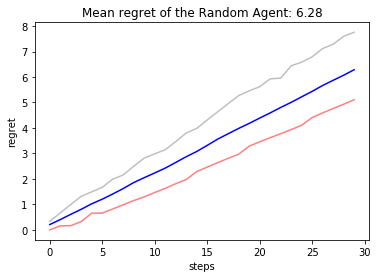

In [127]:
#Affichage du regret
plt.plot(regrets_random.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets_random, 0.05,axis=0), color='red', alpha=0.5)
plt.plot(np.quantile(regrets_random, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret of the Random Agent: {:.2f}'.format(regret_random.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

# 2. Collaborative filtering : *Memory based Agent* :
Dans cet agent nous utiliserons une fonction de similarité qui nous permet de prédire des rates (interactions  entre les utilisateurs).
Puis on recommande à un utilisateur (current_user), un utilisateur qui ne se trouve pas dans sa liste d'amis  selon le taux d'intéraction prédit (on choisit celui qui a le meilleurs taux d'intéraction).


In [42]:
def similarity(interactions):
    
    # vecteur contenant pour chaque utilisateur le nombre d'intéractions
    r_user = (interactions>0).sum(axis=1)  
    
    # vecteur contenant pour chaque utilisateur la moyenne des intéractions
    m_user = np.divide(interactions.sum(axis=1) , r_user, where=r_user!=0)
    
    # Intéractions recentrées par la moyenne par utilisateur : chaque ligne i contient le vecteur \bar r_i
    interactions_ctr = interactions.T - ((interactions.T!=0) * m_user)
    interactions_ctr = interactions_ctr.T

    # Matrice de Gram, contenant les produits scalaires
    sim = interactions_ctr.dot(interactions_ctr.T)
    # Renormalisation
    norms = np.array([np.sqrt(np.diagonal(sim))])+0.01
    
    sim = sim / norms / norms.T  

    return sim

In [43]:
def phi(x):
    return np.maximum(x,0)

In [44]:
#cette fonction nous permet de prédire une matrices d'interactions (rates entre les users) depuis notre première matrice "interactions"
def predict_interactions(interactions,sim,phi=(lambda x:x)):
    
    wsum_sim = np.abs(phi(sim)).dot(interactions>0)
    return np.divide(phi(sim).dot(interactions) , wsum_sim, where= wsum_sim!=0)

In [45]:
#***********************************Memory based Agent******************************************
class MemoryBasedAgent:
    
    def __init__(self, interactions):
        self._interactions=interactions
        pass
    
    def action(self, user_id, ratings, friends_to_recommend):
        ratings = ratings.toarray()
        sim = similarity(ratings)
        pred_interactions = predict_interactions(ratings,sim,phi)
        #On extrait de la matrice prédite le vecteur qui concerne le current user
        interactions_of_user = pred_interactions[user_id][:]
        print('friends',friends_to_recommend)
        #On prend que les users qui ne sont pas amis avec le current user
        idx_max = friends_to_recommend[0]
        #Parmi ces users on recommande celui qui a le meilleur taux d'intéraction prédit
        max_friend = interactions_of_user[friends_to_recommend[0]]
        
        for j in friends_to_recommend:
            if (interactions_of_user[j]>max_friend):
                max_friend = interactions_of_user[j]
                idx_max = j
        
        #On extrait le reward(taux d'intéractions) prédit de la recommandation
        pred_reward = interactions_of_user[idx_max]
        
        return idx_max, pred_reward

# Génération des expériences avec *Memory based Agent*



In [113]:
def run_exp(agent, env, nb_steps, interactions):
    rewards = []
    regrets_mab = np.zeros(nb_steps)
    actions = []
    pred_rewards = []
    
    for t in range(nb_steps):
        user_id, friends_to_recommend= env.step()
        friend_chosen, pred_reward =agent.action(user_id, interactions, friends_to_recommend)
        print("user_id =",user_id, "items_to_recommend=",friends_to_recommend,"friend_chosen=",friend_chosen)
        real_reward_curr_user = env.calc_real_reward(pred_reward)
        real_reward_recom_user = env.calc_real_reward(pred_reward)
        interactions = env.update(user_id,friend_chosen,real_reward_curr_user, real_reward_recom_user)
        rewards.append(real_reward_curr_user)
        pred_rewards.append(pred_reward)
        actions.append(friend_chosen)
    
    reward = sum( rewards)
    rewards = np.array(rewards)
    pred_rewards = np.array(pred_rewards)
    regrets_mab = pred_rewards - rewards
    regret = np.sum(regrets_mab)
    
    return {'reward': reward, 
            'regret': regret,
            'rewards': rewards,
            'regrets': regrets_mab,
            'actions': actions,
            'cum_rewards': np.cumsum(rewards), 
            'cum_regrets': np.cumsum(regrets_mab)
            }

In [114]:
nb_exp = 20
nb_steps = 30
regret = np.zeros(nb_exp)
regrets_mab = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    print("----------Exp----",i)
    env = Env(nb_users)
    possible_match, interactions = env.reset(seed=None)
    agent=MemoryBasedAgent(interactions)
    exp = run_exp(agent, env, nb_steps, interactions)
    regret[i] = exp['regret'] 
    regrets_mab[i] = exp['cum_regrets']

----------Exp---- 0
(200, 200)
friends [  0   3   4   6   7   9  10  11  13  14  15  18  19  20  21  24  25  26
  28  29  30  31  32  33  34  35  36  37  39  40  41  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  60  61  63  64  66  67  68
  70  71  73  74  75  76  77  78  79  80  81  82  84  85  86  87  88  89
  90  91  93  94  95  96  97  98  99 101 102 103 104 105 107 108 109 110
 111 113 114 115 116 117 118 119 122 123 124 127 128 129 131 133 134 135
 136 137 138 139 140 141 142 143 144 147 149 150 151 152 154 155 156 157
 158 159 160 162 166 167 168 169 170 171 172 173 174 175 178 179 180 181
 182 183 184 185 186 187 188 190 191 192 193 194 195 196 197 198 199]
user_id = 176 items_to_recommend= [  0   3   4   6   7   9  10  11  13  14  15  18  19  20  21  24  25  26
  28  29  30  31  32  33  34  35  36  37  39  40  41  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  60  61  63  64  66  67  68
  70  71  73  74  75  76  77  78  79  80  81  82  84  

friends [  0   2   3   4   5   6   7   9  10  11  12  13  14  15  17  19  20  21
  22  24  25  27  28  29  30  32  33  34  35  36  37  39  40  42  43  44
  45  46  47  48  51  52  55  57  59  60  61  62  63  64  66  67  68  69
  70  71  72  73  74  75  77  79  80  81  83  84  85  86  87  88  90  91
  92  93  94  96 100 101 102 105 106 107 109 110 111 112 113 114 118 119
 120 121 123 124 126 127 128 129 131 132 136 137 138 141 142 143 145 146
 148 149 150 151 152 154 155 158 159 160 161 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 178 180 182 183 184 185 186 187 188 189 190
 191 194 196 198 199]
user_id = 65 items_to_recommend= [  0   2   3   4   5   6   7   9  10  11  12  13  14  15  17  19  20  21
  22  24  25  27  28  29  30  32  33  34  35  36  37  39  40  42  43  44
  45  46  47  48  51  52  55  57  59  60  61  62  63  64  66  67  68  69
  70  71  72  73  74  75  77  79  80  81  83  84  85  86  87  88  90  91
  92  93  94  96 100 101 102 105 106 107 109 110 111 112 113 

(200, 200)
friends [  0   2   3   4   5   7  10  11  12  13  14  15  17  19  22  23  25  26
  27  28  30  31  32  33  34  37  39  40  41  42  46  48  49  50  51  52
  53  54  56  57  58  59  61  62  63  64  65  66  68  69  70  72  73  74
  76  77  78  80  81  82  84  85  86  87  89  90  91  93  94  95  96  97
 100 101 103 104 105 106 107 108 110 111 112 113 115 117 118 119 120 121
 123 124 127 131 132 133 134 135 137 138 139 140 141 142 144 145 146 147
 148 149 150 151 152 153 155 157 158 159 160 162 165 166 167 168 169 171
 172 173 176 179 181 183 185 186 187 188 190 192 193 194 195 198 199]
user_id = 43 items_to_recommend= [  0   2   3   4   5   7  10  11  12  13  14  15  17  19  22  23  25  26
  27  28  30  31  32  33  34  37  39  40  41  42  46  48  49  50  51  52
  53  54  56  57  58  59  61  62  63  64  65  66  68  69  70  72  73  74
  76  77  78  80  81  82  84  85  86  87  89  90  91  93  94  95  96  97
 100 101 103 104 105 106 107 108 110 111 112 113 115 117 118 119 120 121
 1

 175 177 179 181 182 184 185 186 187 188 190 192 193 194 195 197 198 199] friend_chosen= 133
(200, 200)
friends [  0   1   4   5   7   9  11  13  14  15  16  17  18  19  21  24  25  26
  27  28  29  30  31  32  34  35  36  38  39  40  41  42  43  44  46  47
  48  49  50  51  52  54  56  57  59  60  61  63  64  65  67  68  71  72
  73  74  76  77  79  80  81  82  84  86  87  88  89  90  91  93  94  95
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 118 119 120 122 125 126 129 130 131 132 133 134 135 136 137 138 140
 141 142 143 145 146 149 151 153 154 155 156 158 160 161 163 166 167 168
 169 170 171 174 175 176 177 178 180 181 182 183 184 185 186 187 188 190
 192 193 194 195 196 197 198 199]
user_id = 37 items_to_recommend= [  0   1   4   5   7   9  11  13  14  15  16  17  18  19  21  24  25  26
  27  28  29  30  31  32  34  35  36  38  39  40  41  42  43  44  46  47
  48  49  50  51  52  54  56  57  59  60  61  63  64  65  67  68  71  72
  73  74  76  77  

(200, 200)
friends [  0   1   2   3   5   6   7   8   9  10  11  13  14  15  16  17  19  21
  22  27  28  29  30  31  32  33  34  36  37  38  39  40  41  44  45  46
  47  48  49  50  51  52  53  54  57  58  60  63  64  65  66  67  68  69
  72  74  75  76  77  79  81  82  83  84  86  87  89  90  91  92  93  94
  95  97  98  99 100 101 102 104 106 108 112 115 117 118 119 120 121 122
 123 124 126 127 128 129 130 131 132 133 135 136 137 138 139 140 141 143
 144 145 146 147 148 149 150 151 152 153 154 155 157 158 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 176 177 178 179 180 181 182 183
 185 186 187 188 190 195 196 197 198 199]
user_id = 184 items_to_recommend= [  0   1   2   3   5   6   7   8   9  10  11  13  14  15  16  17  19  21
  22  27  28  29  30  31  32  33  34  36  37  38  39  40  41  44  45  46
  47  48  49  50  51  52  53  54  57  58  60  63  64  65  66  67  68  69
  72  74  75  76  77  79  81  82  83  84  86  87  89  90  91  92  93  94
  95  97  98  99 100 101 102 

 181 182 183 185 186 188 189 191 192 193 194 195 197 198 199] friend_chosen= 98
(200, 200)
friends [  0   1   2   3   4   5   7   8   9  10  11  12  13  14  16  17  18  19
  20  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  44  45  47  48  50  51  54  55  57  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  78  81  82  83  84
  85  86  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103
 104 106 107 108 109 110 112 113 114 119 120 121 123 124 125 126 127 128
 129 130 131 132 133 135 136 137 139 141 142 143 145 147 148 149 150 151
 152 153 154 155 156 158 160 161 162 163 165 166 167 168 169 170 172 174
 175 176 177 178 179 180 182 183 184 185 186 187 189 190 191 192 193 194
 195 198 199]
user_id = 118 items_to_recommend= [  0   1   2   3   4   5   7   8   9  10  11  12  13  14  16  17  18  19
  20  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  44  45  47  48  50  51  54  55  

----------Exp---- 5
(200, 200)
friends [  0   1   2   3   4   9  10  11  12  13  14  15  16  18  21  22  23  25
  26  27  28  30  31  32  33  35  36  37  38  39  40  41  42  43  45  47
  48  49  50  51  52  53  54  55  56  57  58  60  62  63  64  65  67  68
  69  70  71  73  74  75  76  77  79  80  81  83  85  87  88  89  90  91
  92  94  95  96  97  98 101 102 103 104 105 106 107 109 110 112 114 115
 116 117 118 119 120 121 123 124 125 126 127 129 130 131 132 133 134 137
 138 139 140 141 142 143 144 147 148 149 150 152 153 154 155 157 158 160
 161 162 163 164 165 166 167 168 170 171 172 173 175 176 178 179 180 181
 182 183 184 185 186 187 189 190 192 193 194 195 196 197 199]
user_id = 145 items_to_recommend= [  0   1   2   3   4   9  10  11  12  13  14  15  16  18  21  22  23  25
  26  27  28  30  31  32  33  35  36  37  38  39  40  41  42  43  45  47
  48  49  50  51  52  53  54  55  56  57  58  60  62  63  64  65  67  68
  69  70  71  73  74  75  76  77  79  80  81  83  85  87  88  

 189 190 192 193 195 196 197 198] friend_chosen= 188
(200, 200)
friends [  1   2   3   4   5   6   7   9  10  11  12  13  14  16  17  18  19  20
  21  23  24  25  27  28  31  33  34  36  37  39  40  43  44  46  47  49
  50  51  52  53  55  56  58  60  62  63  64  66  68  69  70  72  73  74
  76  77  78  80  81  82  83  84  85  86  88  89  90  91  92  94  95  96
  98  99 101 102 104 108 109 112 113 115 116 117 118 119 120 121 122 124
 125 126 128 130 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 152 153 154 155 156 157 158 159 160 161 162 164 166 167
 168 169 170 175 176 177 180 182 183 184 185 186 187 188 189 190 191 192
 194 195 196]
user_id = 8 items_to_recommend= [  1   2   3   4   5   6   7   9  10  11  12  13  14  16  17  18  19  20
  21  23  24  25  27  28  31  33  34  36  37  39  40  43  44  46  47  49
  50  51  52  53  55  56  58  60  62  63  64  66  68  69  70  72  73  74
  76  77  78  80  81  82  83  84  85  86  88  89  90  91  92  94  95  96
  98  

(200, 200)
friends [  0   1   2   3   5   6   7   8   9  10  12  13  15  17  18  19  21  23
  24  25  26  28  30  31  32  34  35  37  38  39  40  41  42  45  46  47
  48  49  51  52  53  57  61  62  63  64  66  67  68  69  70  71  72  74
  75  76  77  78  80  81  83  84  85  86  87  88  90  91  92  93  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 116 117 118 119 121 122 123 124 125 127 128 130 131 133 134 135 136 137
 138 139 141 142 144 145 148 150 151 153 154 155 159 161 162 163 164 165
 166 167 168 170 172 173 175 177 179 181 182 183 184 185 186 187 190 191
 192 193 194 197 198 199]
user_id = 59 items_to_recommend= [  0   1   2   3   5   6   7   8   9  10  12  13  15  17  18  19  21  23
  24  25  26  28  30  31  32  34  35  37  38  39  40  41  42  45  46  47
  48  49  51  52  53  57  61  62  63  64  66  67  68  69  70  71  72  74
  75  76  77  78  80  81  83  84  85  86  87  88  90  91  92  93  95  96
  97  98  99 100 101 102 103 104 105 106 107 1

(200, 200)
friends [  0   3   4   5   7   8   9  12  13  14  15  16  17  19  20  21  22  23
  24  25  26  27  28  29  31  32  33  34  36  38  41  42  43  44  45  46
  48  49  50  52  53  55  56  57  58  59  60  61  62  63  64  65  66  69
  70  73  74  77  78  79  80  81  82  83  84  85  86  88  91  92  94  96
  97  98  99 100 101 103 105 107 108 111 112 116 117 118 121 122 123 124
 126 127 129 130 131 134 135 136 137 138 141 142 144 145 147 148 150 151
 152 153 154 155 157 159 161 162 163 164 166 168 170 172 173 174 176 178
 179 180 181 182 184 185 186 187 188 189 190 192 193 194 196 197 198]
user_id = 113 items_to_recommend= [  0   3   4   5   7   8   9  12  13  14  15  16  17  19  20  21  22  23
  24  25  26  27  28  29  31  32  33  34  36  38  41  42  43  44  45  46
  48  49  50  52  53  55  56  57  58  59  60  61  62  63  64  65  66  69
  70  73  74  77  78  79  80  81  82  83  84  85  86  88  91  92  94  96
  97  98  99 100 101 103 105 107 108 111 112 116 117 118 121 122 123 124
 

(200, 200)
friends [  0   1   2   3   4   7  11  12  13  14  15  16  17  19  20  24  26  27
  28  30  33  34  35  36  37  39  40  41  42  43  44  45  46  47  48  49
  50  51  54  55  58  59  60  61  62  63  64  65  66  67  69  70  71  72
  74  75  79  80  81  83  84  86  87  88  89  90  91  92  94  95  96  97
 100 101 102 103 104 106 107 109 110 111 114 115 116 117 118 119 121 124
 126 127 128 129 130 131 132 134 135 136 137 138 139 140 141 142 143 144
 145 146 148 149 150 153 154 155 156 157 158 159 160 161 162 164 165 166
 167 169 171 172 173 174 175 176 177 178 179 180 181 182 184 185 186 187
 188 189 190 191 192 193 194 196 197 198]
user_id = 93 items_to_recommend= [  0   1   2   3   4   7  11  12  13  14  15  16  17  19  20  24  26  27
  28  30  33  34  35  36  37  39  40  41  42  43  44  45  46  47  48  49
  50  51  54  55  58  59  60  61  62  63  64  65  66  67  69  70  71  72
  74  75  79  80  81  83  84  86  87  88  89  90  91  92  94  95  96  97
 100 101 102 103 104 106 107 1

(200, 200)
friends [  1   2   3   4   5   6   7   8  10  12  14  15  17  18  19  21  23  24
  26  31  33  34  35  36  38  39  40  41  42  43  45  46  47  48  49  50
  51  52  53  54  56  57  58  59  60  61  63  65  67  68  70  71  72  73
  74  75  77  81  82  83  84  85  86  88  89  91  92  93  95  97  98 101
 102 104 105 107 108 109 110 112 113 114 115 116 117 118 119 120 123 124
 125 126 127 128 129 131 132 133 134 136 138 140 142 143 144 145 146 147
 148 150 151 154 156 157 158 159 160 162 163 164 165 166 167 168 170 173
 174 175 176 177 178 180 181 182 184 185 186 187 188 189 190 191 192 194
 195 196 197 198 199]
user_id = 28 items_to_recommend= [  1   2   3   4   5   6   7   8  10  12  14  15  17  18  19  21  23  24
  26  31  33  34  35  36  38  39  40  41  42  43  45  46  47  48  49  50
  51  52  53  54  56  57  58  59  60  61  63  65  67  68  70  71  72  73
  74  75  77  81  82  83  84  85  86  88  89  91  92  93  95  97  98 101
 102 104 105 107 108 109 110 112 113 114 115 116 1

 193 195 196 197] friend_chosen= 193
(200, 200)
friends [  0   4   5   6   7   8  10  11  12  13  14  15  16  19  20  21  22  23
  24  25  27  28  29  30  31  32  33  34  35  36  37  38  42  44  45  46
  47  52  53  54  55  56  57  58  59  60  62  63  67  68  69  71  72  73
  74  75  76  77  78  79  80  81  83  86  88  89  90  91  92  93  94  95
  98  99 101 103 104 105 106 107 110 111 112 113 114 115 119 120 122 123
 124 125 126 127 128 130 131 132 133 134 136 137 139 140 141 142 143 144
 145 146 147 148 150 151 153 154 156 158 160 161 162 163 165 166 167 168
 170 171 173 175 177 178 179 180 181 182 183 184 185 186 187 188 191 192
 193 194 195 196 198 199]
user_id = 100 items_to_recommend= [  0   4   5   6   7   8  10  11  12  13  14  15  16  19  20  21  22  23
  24  25  27  28  29  30  31  32  33  34  35  36  37  38  42  44  45  46
  47  52  53  54  55  56  57  58  59  60  62  63  67  68  69  71  72  73
  74  75  76  77  78  79  80  81  83  86  88  89  90  91  92  93  94  95
  98  99

(200, 200)
friends [  0   2   4   5   6   7   9  10  11  13  14  15  16  17  18  19  20  21
  22  23  24  25  27  28  29  30  33  34  35  36  37  38  40  42  43  45
  46  47  48  49  51  52  53  56  57  58  59  60  61  63  64  65  66  67
  68  69  70  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87
  90  91  93  94  97 103 106 107 109 111 112 113 114 115 116 118 119 121
 123 124 127 129 131 132 133 134 136 137 139 140 141 142 143 144 145 146
 147 148 149 151 152 153 154 155 156 157 159 160 161 162 163 164 165 167
 168 169 170 171 173 174 175 176 177 178 179 180 182 184 185 186 188 190
 192 194 195 198 199]
user_id = 98 items_to_recommend= [  0   2   4   5   6   7   9  10  11  13  14  15  16  17  18  19  20  21
  22  23  24  25  27  28  29  30  33  34  35  36  37  38  40  42  43  45
  46  47  48  49  51  52  53  56  57  58  59  60  61  63  64  65  66  67
  68  69  70  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87
  90  91  93  94  97 103 106 107 109 111 112 113 1

(200, 200)
friends [  1   2   6   8   9  10  12  13  14  15  16  21  22  24  25  27  28  29
  30  31  33  34  35  37  38  39  40  42  43  45  47  48  50  51  52  53
  55  57  58  59  61  62  64  65  68  69  70  72  73  74  76  78  79  82
  83  84  85  86  87  88  89  91  92  93  96  97  98  99 100 101 102 104
 105 106 107 109 110 111 113 114 115 116 117 118 119 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 139 142 143 144 145 147
 148 149 151 152 153 154 155 156 159 160 162 163 164 166 167 168 170 171
 172 173 174 175 178 179 180 181 183 184 185 186 188 189 190 191 192 193
 194 195 196 198]
user_id = 56 items_to_recommend= [  1   2   6   8   9  10  12  13  14  15  16  21  22  24  25  27  28  29
  30  31  33  34  35  37  38  39  40  42  43  45  47  48  50  51  52  53
  55  57  58  59  61  62  64  65  68  69  70  72  73  74  76  78  79  82
  83  84  85  86  87  88  89  91  92  93  96  97  98  99 100 101 102 104
 105 106 107 109 110 111 113 114 115 116 117 118 119 1

(200, 200)
friends [  0   2   3   4   6   7   9  10  13  14  15  16  17  18  20  21  22  24
  26  27  28  29  30  31  32  35  36  37  39  40  41  43  44  45  46  47
  50  51  52  53  54  56  58  60  62  63  65  66  67  68  69  70  71  72
  73  74  75  78  79  80  83  84  85  87  88  89  90  91  92  94  95  96
  97  98  99 100 102 103 104 105 106 109 110 111 113 114 115 116 117 118
 119 121 122 124 125 126 127 129 130 133 134 135 136 137 138 139 141 143
 144 145 146 147 148 149 151 156 157 158 159 160 161 162 165 167 168 169
 170 171 173 174 175 177 178 180 181 182 184 185 186 188 189 190 191 192
 194 195 196 197 198 199]
user_id = 34 items_to_recommend= [  0   2   3   4   6   7   9  10  13  14  15  16  17  18  20  21  22  24
  26  27  28  29  30  31  32  35  36  37  39  40  41  43  44  45  46  47
  50  51  52  53  54  56  58  60  62  63  65  66  67  68  69  70  71  72
  73  74  75  78  79  80  83  84  85  87  88  89  90  91  92  94  95  96
  97  98  99 100 102 103 104 105 106 109 110 1

friends [  1   2   3   4   5   6   8   9  10  11  12  14  15  16  17  18  19  20
  22  23  24  25  26  28  29  30  32  34  35  36  37  40  41  42  43  44
  45  46  47  48  50  51  53  54  55  56  59  60  62  64  66  67  68  69
  70  71  72  73  74  75  76  78  80  81  82  84  85  86  88  89  90  91
  92  93  94  96  97  98  99 100 101 105 106 108 109 110 111 113 114 115
 117 118 119 120 121 122 123 126 128 129 130 132 133 134 135 136 137 138
 139 140 141 143 144 145 146 147 148 149 150 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 170 171 173 174 175 176 177 179
 180 182 183 184 185 187 188 189 190 191 192 193 195 198]
user_id = 61 items_to_recommend= [  1   2   3   4   5   6   8   9  10  11  12  14  15  16  17  18  19  20
  22  23  24  25  26  28  29  30  32  34  35  36  37  40  41  42  43  44
  45  46  47  48  50  51  53  54  55  56  59  60  62  64  66  67  68  69
  70  71  72  73  74  75  76  78  80  81  82  84  85  86  88  89  90  91
  92  93  94  96  97  98 

----------Exp---- 15
(200, 200)
friends [  0   1   2   4   6   8   9  12  13  14  16  17  18  19  20  21  22  26
  28  29  31  32  33  34  35  36  37  39  40  42  43  44  46  47  50  51
  52  54  55  57  58  59  60  62  63  65  66  67  68  70  71  72  73  74
  75  77  78  80  81  83  85  86  87  88  89  91  92  96  97  98  99 100
 101 104 107 108 110 111 113 114 115 116 117 120 121 122 123 125 128 129
 130 133 134 135 136 138 139 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 160 161 162 163 164 165 169 170 172 173 175 177
 178 180 181 182 183 187 188 189 190 191 194 196 198 199]
user_id = 30 items_to_recommend= [  0   1   2   4   6   8   9  12  13  14  16  17  18  19  20  21  22  26
  28  29  31  32  33  34  35  36  37  39  40  42  43  44  46  47  50  51
  52  54  55  57  58  59  60  62  63  65  66  67  68  70  71  72  73  74
  75  77  78  80  81  83  85  86  87  88  89  91  92  96  97  98  99 100
 101 104 107 108 110 111 113 114 115 116 117 120 121 122 123 125 1

(200, 200)
friends [  1   2   3   4   5   6   8   9  10  11  13  14  15  17  18  19  20  21
  22  23  25  27  28  30  32  34  39  40  41  43  44  46  47  48  49  50
  53  54  55  57  58  59  61  62  66  67  68  69  70  71  73  74  77  78
  79  80  81  82  83  84  88  89  90  92  93  94  96  97  98  99 100 101
 102 103 104 105 106 108 109 110 111 112 113 114 116 117 118 119 120 121
 122 123 124 126 128 130 131 132 134 135 136 138 139 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 162 164 165 166
 167 170 171 172 173 174 175 176 178 180 181 182 184 186 187 189 191 192
 193 195 197 199]
user_id = 42 items_to_recommend= [  1   2   3   4   5   6   8   9  10  11  13  14  15  17  18  19  20  21
  22  23  25  27  28  30  32  34  39  40  41  43  44  46  47  48  49  50
  53  54  55  57  58  59  61  62  66  67  68  69  70  71  73  74  77  78
  79  80  81  82  83  84  88  89  90  92  93  94  96  97  98  99 100 101
 102 103 104 105 106 108 109 110 111 112 113 114 116 1

 196 197 198 199] friend_chosen= 149
(200, 200)
friends [  0   2   4   6   7   9  10  11  13  14  15  16  17  18  19  21  22  23
  25  26  27  31  32  33  34  36  37  38  40  41  44  45  46  47  48  49
  50  52  53  54  55  57  58  59  60  61  63  64  65  66  67  68  69  71
  73  74  75  79  80  84  85  86  87  89  90  91  94  95  96  97  98 100
 102 103 104 107 109 110 111 112 116 118 119 120 121 122 124 126 128 130
 131 132 134 137 138 139 141 142 143 144 146 148 149 150 152 153 155 157
 158 159 162 165 166 169 170 171 173 174 175 176 180 182 183 184 185 186
 187 188 191 192 197 199]
user_id = 76 items_to_recommend= [  0   2   4   6   7   9  10  11  13  14  15  16  17  18  19  21  22  23
  25  26  27  31  32  33  34  36  37  38  40  41  44  45  46  47  48  49
  50  52  53  54  55  57  58  59  60  61  63  64  65  66  67  68  69  71
  73  74  75  79  80  84  85  86  87  89  90  91  94  95  96  97  98 100
 102 103 104 107 109 110 111 112 116 118 119 120 121 122 124 126 128 130
 131 132 

(200, 200)
friends [  0   2   4   5   6   7  10  11  12  15  17  18  19  20  22  23  24  27
  28  29  33  36  37  39  40  41  42  43  44  46  47  48  52  54  55  56
  57  58  59  60  61  62  64  66  67  69  71  72  73  74  76  78  79  81
  85  86  87  88  90  91  92  93  94  96  98  99 100 101 102 103 104 105
 106 107 109 110 111 112 114 115 116 117 118 119 120 121 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 141 142 143 144 145 146
 147 148 149 150 151 153 159 160 161 162 164 165 166 167 169 170 171 173
 174 176 177 178 180 181 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199]
user_id = 154 items_to_recommend= [  0   2   4   5   6   7  10  11  12  15  17  18  19  20  22  23  24  27
  28  29  33  36  37  39  40  41  42  43  44  46  47  48  52  54  55  56
  57  58  59  60  61  62  64  66  67  69  71  72  73  74  76  78  79  81
  85  86  87  88  90  91  92  93  94  96  98  99 100 101 102 103 104 105
 106 107 109 110 111 112 114 115 116 117 118 119 

(200, 200)
friends [  1   2   3   4   6   7   8   9  10  12  13  15  16  17  19  20  21  23
  24  25  26  27  28  31  32  33  35  36  37  39  41  42  43  44  46  48
  51  52  53  54  55  60  61  62  65  66  67  68  70  71  72  73  75  76
  77  78  79  81  82  83  84  85  86  87  89  90  91  93  94  95  96  97
  98  99 101 103 108 109 111 113 114 118 119 121 122 123 124 127 128 129
 130 131 132 133 134 135 139 141 143 144 146 147 148 150 151 153 154 156
 157 158 160 161 162 163 165 166 168 169 170 171 172 173 174 176 177 178
 179 180 181 182 183 185 188 189 190 191 193 194 195 197]
user_id = 125 items_to_recommend= [  1   2   3   4   6   7   8   9  10  12  13  15  16  17  19  20  21  23
  24  25  26  27  28  31  32  33  35  36  37  39  41  42  43  44  46  48
  51  52  53  54  55  60  61  62  65  66  67  68  70  71  72  73  75  76
  77  78  79  81  82  83  84  85  86  87  89  90  91  93  94  95  96  97
  98  99 101 103 108 109 111 113 114 118 119 121 122 123 124 127 128 129
 130 131 132 

(200, 200)
friends [  0   2   4   8  11  12  14  15  16  17  18  19  20  21  22  25  26  27
  32  36  39  40  42  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  59  60  62  63  65  66  69  70  72  73  74  75  76  77  78  79  81
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98 100 102
 103 104 105 106 109 110 111 112 113 115 116 117 118 119 121 122 124 125
 128 129 130 131 132 133 135 136 137 138 139 140 141 142 143 144 147 148
 149 150 151 154 156 158 159 160 161 162 165 166 167 168 171 172 173 174
 175 176 177 178 179 180 182 186 188 189 190 191 193 195 196 199]
user_id = 41 items_to_recommend= [  0   2   4   8  11  12  14  15  16  17  18  19  20  21  22  25  26  27
  32  36  39  40  42  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  59  60  62  63  65  66  69  70  72  73  74  75  76  77  78  79  81
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98 100 102
 103 104 105 106 109 110 111 112 113 115 116 117 118 119 121 122 124 125
 128 1

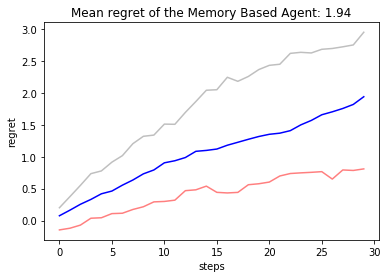

In [115]:
plt.plot(regrets_mab.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets_mab, 0.05,axis=0), color='red', alpha=0.5)
plt.plot(np.quantile(regrets_mab, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret of the Memory Based Agent: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

# 3. Agent avec *Modèle de regression*

Dans cette méthode on prédit les features des utilisateurs à partir d'un modèle de regression.

In [18]:
env = Env(nb_users)
possible_match, interactions = env.reset(seed=None)

In [19]:
interactions2 = interactions.todense()

In [20]:
def conv_to_df(interactions):
    nb_users = len(interactions)
    M=np.zeros((nb_users*nb_users,3))
    for i in range (nb_users):
        for j in range(nb_users):
            M[j+i*nb_users][0]=i
            M[j+i*nb_users][1]=j
            M[j+i*nb_users][2]=interactions2[i,j]
    df = pd.DataFrame(M,columns=['user_id','user_id_2','interactions'])
    return df

In [21]:
df = conv_to_df(interactions2)

In [22]:
df.head()

user_id  user_id_2  interactions
0      0.0        0.0           1.0
1      0.0        1.0           0.0
2      0.0        2.0           0.0
3      0.0        3.0           0.0
4      0.0        4.0           0.0

In [23]:
class RegressionModel(Model):
    
    def __init__(self, embedding_size, nb_users):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=nb_users ,
                                        input_length=1,
                                        name='user_embedding')
        self.user2_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=nb_users ,
                                        input_length=1,
                                        name='user2_embedding')
        
        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)
        
    def call(self, inputs):
        user_inputs = inputs[0]
        user2_inputs = inputs[1]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        
        #user2_vecs :les users qui sont à recommander
        user2_vecs = self.flatten(self.user2_embedding(user2_inputs))
        
        y = self.dot([user_vecs, user2_vecs])
        return y

model = RegressionModel(64, nb_users)
model.compile(optimizer="adam", loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
user_id_train = np.array(df['user_id'])
user_id_train2 = np.array(df['user_id_2'])
interactions_train = np.array(df['interactions'])

In [25]:
#on entraine le model avec notre matice d'interaction
history = model.fit([user_id_train, user_id_train2], interactions_train,
                    batch_size=64, epochs=4, validation_split=0.1,
                    shuffle=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 36000 samples, validate on 4000 samples
Epoch 1/4
36000/36000 [==============================] - 3s 78us/sample - loss: 0.0846 - val_loss: 0.0878
Epoch 2/4
36000/36000 [==============================] - 2s 53us/sample - loss: 0.0702 - val_loss: 0.0878
Epoch 3/4
36000/36000 [==============================] - 2s 47us/sample - loss: 0.0632 - val_loss: 0.0880
Epoch 4/4
36000/36000 [==============================] - 2s 55us/sample - loss: 0.0543 - val_loss: 0.0881


In [27]:
class RegressionAgent:
    
    def __init__(self):
        pass
    
    def action(self, model, user_id, users_available):
        #On crée un array de longueur le nombre d'utilisateurs avec qui le current_user n'est pas amis
        #contenant la répétition de l'identifiant du current_user
        user_id_test = np.ones((len(users_available)))*user_id
        #on prédit les taux d'interactions associés au current_user (test_preds)
        test_preds = model.predict([user_id_test, users_available])
        #on choisit celui qui a le meilleur taux d'interactions prédit comme recommandation
        index = np.argmax(test_preds)
        pred_reward = np.max(test_preds)
        recommended_user = users_available[index]
        
        return recommended_user, pred_reward

In [116]:
def run_exp_deep(agent, env, nb_steps, interactions):
    rewards = []
    regrets_reg = np.zeros(nb_steps)
    actions = []
    pred_rewards = []

    for t in range(nb_steps):
        user_id, friends_to_recommend= env.step()
        friend_chosen, pred_reward =agent.action(model, user_id, friends_to_recommend)
        print("user_id =",user_id, "items_to_recommend=",friends_to_recommend,"friend_chosen=",friend_chosen)
        real_reward_curr_user = env.calc_real_reward(pred_reward)
        real_reward_recom_user = env.calc_real_reward(pred_reward)
        interactions = env.update(user_id,friend_chosen,real_reward_curr_user, real_reward_recom_user)
        rewards.append(real_reward_curr_user)
        pred_rewards.append(pred_reward)
        actions.append(friend_chosen)
    
    reward = sum( rewards)
    rewards = np.array(rewards)
    pred_rewards = np.array(pred_rewards)
    regrets_reg = abs(pred_rewards - rewards)
    regret = np.sum(regrets_reg)
    
    return {'reward': reward, 
            'regret': regret,
            'rewards': rewards,
            'regrets': regrets_reg,
            'actions': actions,
            'cum_rewards': np.cumsum(rewards), 
            'cum_regrets': np.cumsum(regrets_reg)
            }

In [117]:
nb_exp = 20
nb_steps = 30
regret = np.zeros(nb_exp)
regrets_reg = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    print("----------Exp----",i)
    env = Env(nb_users)
    possible_match, interactions = env.reset(seed=None)
    agent=RegressionAgent()
    exp = run_exp_deep(agent, env, nb_steps, interactions)
    regret[i] = exp['regret'] 
    regrets_reg[i] = exp['cum_regrets']

----------Exp---- 0
user_id = 81 items_to_recommend= [  0   2   3   4   5   6   7   9  10  11  12  13  14  15  16  17  18  22
  23  25  26  27  28  29  30  31  32  33  35  36  38  39  40  41  42  43
  44  46  50  51  52  53  54  55  58  59  60  61  63  65  67  68  69  70
  71  72  73  74  75  76  78  79  80  83  85  86  88  90  91  93  94  96
  97  98  99 100 101 103 104 105 106 108 109 110 111 112 114 115 117 119
 121 122 125 128 130 131 132 133 134 135 136 137 138 140 141 142 143 144
 145 146 147 149 150 151 152 154 155 157 158 159 160 161 162 163 164 165
 166 168 169 170 171 172 173 175 177 178 180 181 182 183 184 185 187 189
 190 191 193 194 196 198 199] friend_chosen= 110
user_id = 57 items_to_recommend= [  3   6  10  11  12  13  14  16  17  18  19  20  21  22  23  24  25  26
  29  31  33  34  36  37  40  41  42  43  44  47  48  50  51  53  54  55
  58  59  60  61  63  65  67  68  69  70  71  73  75  76  77  78  79  80
  82  88  89  90  92  95  96  97  99 100 101 103 106 108 110 1

user_id = 194 items_to_recommend= [  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  22  23  25  26  28  29  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  55  56  57  58  59  62  63  64
  65  69  70  71  74  75  76  78  80  81  82  83  84  85  86  88  89  90
  92  93  94  96  98  99 100 102 104 105 107 108 109 110 111 112 113 114
 115 116 118 119 120 121 122 124 125 126 127 128 129 130 131 132 133 135
 137 138 139 140 141 143 144 145 147 149 150 151 153 154 155 156 157 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 184 185 186 187 188 189 191 192 193 195 196 199] friend_chosen= 162
user_id = 64 items_to_recommend= [  0   1   3   4   5   6   7   8  10  11  12  14  17  18  19  20  21  24
  26  27  28  29  30  31  32  33  34  35  37  38  39  40  41  42  43  44
  45  46  47  50  51  52  53  54  59  62  63  65  66  68  69  70  72  73
  74  77  78  80  83  84  86  89  90  91  92  94 

user_id = 131 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  19
  20  22  23  24  28  30  31  32  33  34  35  39  40  41  42  44  45  47
  48  49  50  51  53  54  55  56  57  58  59  60  63  64  69  71  72  73
  77  80  82  83  84  87  90  91  93  94  95  96  97  98  99 102 103 104
 105 106 107 108 109 110 111 112 114 115 116 117 118 120 121 122 124 126
 127 128 129 130 135 136 138 139 141 142 143 144 145 146 147 148 149 150
 154 156 157 159 160 161 162 164 165 167 168 170 171 172 173 174 175 176
 177 178 179 181 182 183 186 187 190 191 193 195 196 197 198 199] friend_chosen= 182
user_id = 96 items_to_recommend= [  0   2   3   4   5   6   7   9  11  13  14  15  17  18  19  20  21  22
  23  24  25  26  27  28  29  30  31  33  35  36  37  38  39  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  60  61  62  64  65  66  68
  69  70  71  72  73  74  77  78  79  80  82  84  86  87  89  91  93  94
  97  98  99 100 101 103 104 109 110 111 112 

user_id = 128 items_to_recommend= [  0   1   3   4   5   6   7   8   9  10  12  13  15  16  17  18  21  22
  23  24  25  26  27  28  29  30  31  34  35  36  37  39  40  41  42  43
  44  45  47  48  50  51  52  53  55  56  57  58  60  61  63  64  65  66
  67  68  69  70  71  72  76  77  78  79  80  81  82  83  84  87  88  90
  91  92  93  94  96  97 100 101 104 105 106 107 108 109 110 111 114 115
 116 118 119 122 123 124 125 126 127 129 130 131 132 133 134 135 137 138
 139 140 141 142 143 144 146 148 150 151 152 153 155 157 160 163 165 166
 167 168 172 173 174 175 176 177 178 179 180 181 182 183 184 186 187 188
 189 190 192 193 194 195 196 197 198 199] friend_chosen= 167
user_id = 178 items_to_recommend= [  0   1   2   4   5   6   8  10  11  12  13  14  17  18  19  20  21  23
  24  25  27  28  29  33  36  37  38  39  40  41  44  46  47  49  50  51
  52  53  55  56  57  59  60  61  62  63  65  66  67  68  69  71  72  73
  75  76  77  79  80  82  84  85  87  89  91  92  93  94  96 100 101

user_id = 8 items_to_recommend= [  0   2   3   5   6   7   9  10  11  12  13  15  17  18  20  22  23  28
  29  30  32  33  35  36  37  38  39  42  43  44  45  46  47  48  49  50
  52  53  54  56  57  58  59  60  61  62  63  64  65  68  69  70  71  72
  74  75  77  78  79  80  81  82  84  85  86  91  92  93  94  95  97  98
  99 101 102 103 105 107 108 111 112 114 115 116 117 118 120 121 122 123
 124 125 126 127 128 131 132 133 134 135 137 139 141 142 143 146 147 148
 149 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 170 173 175 176 179 180 181 182 183 184 186 189 190 191 192 194 197
 198] friend_chosen= 78
user_id = 193 items_to_recommend= [  0   1   2   3   4   5   6   8   9  10  12  13  14  15  17  18  19  24
  25  27  29  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  47  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  67
  68  69  71  74  76  77  78  79  82  83  84  85  86  88  89  91  93  94
  95  96  98 100 101 102 103 104 1

user_id = 78 items_to_recommend= [  0   1   3   5   6   7  11  12  13  15  16  17  19  21  22  23  24  25
  26  27  28  29  31  33  37  38  39  40  41  42  43  44  45  47  49  50
  51  54  55  56  57  58  60  61  62  63  64  66  67  68  69  70  71  73
  74  77  79  80  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  97  98  99 100 102 104 105 106 107 108 109 110 111 113 114 115 116 117
 119 120 121 124 125 126 127 129 130 132 133 136 137 138 139 140 144 145
 147 148 149 151 152 153 155 156 158 159 160 161 162 164 166 167 170 171
 172 173 174 175 176 177 178 179 180 182 183 186 187 188 189 190 191 192
 193 195 196 197 199] friend_chosen= 95
user_id = 104 items_to_recommend= [  0   1   2   4   5   6   7   8  11  14  15  16  17  18  19  20  21  22
  23  25  26  27  29  30  31  32  33  35  36  37  38  39  40  41  42  43
  45  47  48  49  50  51  53  55  56  57  58  59  60  61  62  64  65  68
  70  71  72  73  74  75  77  79  80  81  82  84  85  86  87  88  89  90
  91  92  93  95 

user_id = 132 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  20  22  23  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  43  44  45  48  49  50  51  52  53  54  55  56  57  59  60  61  63
  64  65  66  67  68  69  72  73  74  75  76  77  78  79  81  83  84  86
  87  88  89  90  91  92  95  96  97  98 101 103 105 106 108 109 111 112
 113 114 115 116 117 118 119 120 121 123 124 125 126 127 128 130 131 133
 134 135 136 137 139 140 141 143 144 146 147 148 149 151 152 154 155 156
 157 159 160 161 163 167 168 170 171 173 174 175 176 177 178 179 180 181
 182 184 185 188 189 190 191 192 193 195 196 197 198] friend_chosen= 15
user_id = 23 items_to_recommend= [  1   3   4   5   6   7   8   9  10  12  14  15  16  17  18  19  20  21
  22  24  25  26  28  29  30  31  32  33  34  35  36  39  40  41  43  44
  45  47  49  52  53  57  58  60  61  62  65  66  67  68  69  70  71  72
  73  74  75  76  77  79  80  81  82  83  84  85  86  87  

user_id = 38 items_to_recommend= [  0   2   3   5   6   7   8   9  10  11  12  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  31  32  34  36  37  40  42  43  46  48
  50  51  53  54  55  56  57  58  61  62  63  64  65  66  67  68  69  70
  71  72  74  75  77  78  79  80  81  83  84  86  87  88  91  92  93  94
  95  96  97  98  99 100 102 103 104 105 107 108 109 110 111 112 113 114
 116 117 118 119 121 122 123 124 127 128 129 130 131 132 134 136 137 138
 139 140 141 142 143 144 145 147 149 152 154 155 156 157 158 159 160 161
 162 163 165 166 168 169 171 172 174 175 176 177 178 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199] friend_chosen= 43
user_id = 77 items_to_recommend= [  0   1   2   4   5   6   7   8   9  10  11  12  13  14  15  17  20  21
  22  23  24  25  26  27  28  31  33  35  36  37  38  39  40  41  42  43
  44  46  47  48  49  50  51  53  54  55  56  57  58  59  60  61  62  63
  64  66  67  68  69  70  71  73  74  75  76  79  8

user_id = 95 items_to_recommend= [  0   2   3   4   5   7   8  10  11  13  14  16  17  19  20  21  22  23
  24  25  26  27  29  30  31  32  33  34  38  39  42  43  44  45  47  48
  49  50  51  53  54  55  56  57  60  62  64  67  71  73  75  76  79  80
  81  82  83  84  85  86  87  88  89  90  92  94  96  98  99 101 102 103
 105 108 109 110 111 114 116 117 118 119 120 121 122 125 126 127 128 129
 130 132 133 135 136 137 139 141 142 144 145 146 148 153 154 155 156 157
 158 159 160 161 163 164 166 168 169 170 171 172 173 174 175 176 178 179
 180 181 182 183 187 188 190 192 195 197 199] friend_chosen= 47
user_id = 157 items_to_recommend= [  1   2   4   5   6   8   9  10  11  12  13  14  16  17  19  20  22  23
  24  26  27  28  29  30  31  32  34  37  38  39  40  42  43  44  46  48
  50  51  52  53  55  57  58  60  61  63  64  65  66  67  69  70  71  73
  75  76  77  78  79  82  84  85  86  87  88  89  90  91  92  93  94  95
  96  98 100 101 103 105 107 109 111 112 113 114 115 116 117 118 1

user_id = 143 items_to_recommend= [  1   2   5   6   8  10  11  12  13  16  17  19  20  21  22  23  24  26
  27  28  29  30  31  32  33  34  35  37  38  41  43  44  45  46  47  48
  50  51  52  53  54  56  57  58  59  60  61  62  63  64  65  66  68  69
  70  71  72  75  76  78  79  80  81  82  83  84  85  86  87  89  91  92
  95  96  97  98  99 100 102 103 106 107 109 110 111 112 113 116 122 123
 125 126 128 132 133 134 135 136 137 138 139 140 141 142 144 145 146 147
 148 149 150 152 153 156 157 158 159 160 161 162 164 165 166 167 169 170
 171 172 173 174 175 177 178 179 180 181 182 183 184 186 187 189 190 191
 194 195 196 197 198 199] friend_chosen= 92
user_id = 76 items_to_recommend= [  2   3   4  10  12  14  15  16  17  18  19  20  21  22  23  24  25  26
  29  30  32  33  35  38  39  41  42  43  44  46  47  48  49  50  52  53
  54  55  56  57  58  59  60  61  62  63  64  67  68  70  72  73  74  75
  77  78  79  80  81  82  84  85  86  87  88  89  91  92  93  94  95  96
  97  98  99 

user_id = 172 items_to_recommend= [  1   2   4   6   7   8   9  11  12  13  16  17  18  19  20  22  23  26
  27  28  29  30  31  32  33  34  35  38  39  40  41  45  46  47  53  54
  55  56  57  58  60  61  62  63  64  66  67  69  70  71  72  73  74  75
  77  78  80  83  84  86  87  89  91  92  94  95  96  97  98  99 100 102
 103 104 106 107 108 110 112 114 115 117 120 122 123 124 125 126 128 130
 131 132 133 134 135 137 138 139 141 142 143 145 146 147 149 150 151 152
 154 155 157 158 159 160 161 162 163 164 166 167 168 169 170 171 173 174
 176 177 178 179 180 181 183 186 187 188 189 190 191 193 195 196 197 199] friend_chosen= 143
user_id = 189 items_to_recommend= [  1   2   3   4   6   8   9  10  11  12  13  15  16  17  18  20  22  23
  24  25  26  28  29  31  32  34  35  37  38  39  40  42  43  45  46  47
  48  49  50  51  53  54  55  56  57  58  59  60  61  62  65  66  67  69
  71  73  74  75  77  78  79  80  82  83  84  88  89  90  92  93  94  95
  96  97  98  99 100 101 102 103 105

user_id = 27 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  11  13  15  16  17  18  19
  20  21  22  23  24  26  28  29  30  31  32  33  34  35  36  38  39  40
  41  42  43  45  47  48  49  50  51  52  53  54  56  57  58  60  62  64
  65  67  68  69  70  71  73  74  75  76  77  78  80  81  82  83  84  85
  86  87  88  89  91  92  94  95  97  98  99 100 101 102 103 104 106 108
 109 111 116 117 118 119 121 122 123 127 129 131 132 133 135 138 139 140
 141 142 143 144 145 146 148 150 151 152 154 155 156 157 158 159 160 161
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 181 182
 183 184 185 186 188 189 190 191 193 194 195 196 197 198 199] friend_chosen= 176
user_id = 30 items_to_recommend= [  0   2   3   6  10  11  13  14  15  17  18  20  21  22  23  24  27  28
  29  32  33  34  35  36  37  39  41  42  43  44  45  47  49  52  53  54
  55  56  57  58  60  61  62  63  66  67  71  72  73  74  75  77  78  79
  80  81  82  84  87  88  90  91  92  93  94  95  

user_id = 177 items_to_recommend= [  0   1   2   3   4   5   6   7   8  10  11  16  18  20  21  22  24  27
  28  29  30  31  32  33  34  35  37  38  39  40  41  42  45  46  47  48
  49  51  53  54  56  58  59  60  61  62  63  65  66  67  68  69  70  71
  72  73  74  75  77  78  79  80  82  83  86  87  88  89  91  92  94  96
  97  98 100 101 102 103 106 107 108 109 110 112 113 114 116 117 119 120
 123 124 125 126 128 129 130 131 133 134 135 136 137 138 141 142 143 144
 145 146 147 148 149 150 151 152 154 156 157 159 160 161 163 164 166 167
 170 172 173 174 176 179 180 181 182 183 184 185 188 189 190 191 192 193
 194 197 198 199] friend_chosen= 1
user_id = 121 items_to_recommend= [  0   3   5   7   8   9  11  12  14  15  16  17  20  21  23  25  26  27
  28  29  30  32  33  34  35  36  37  38  39  40  42  44  47  48  49  51
  52  53  54  56  58  59  60  61  63  64  65  66  67  68  69  70  71  72
  73  75  76  77  79  82  83  84  85  86  87  88  90  91  92  93  95  96
  97  98  99 100 101 

user_id = 25 items_to_recommend= [  0   1   2   3   4   5   6   7   8   9  10  12  13  14  16  18  19  20
  21  24  26  27  28  31  32  34  39  40  43  44  45  46  49  50  51  52
  53  55  56  57  58  60  61  62  63  64  65  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  84  85  86  87  88  89  90  93  94  97  98
  99 100 101 102 103 105 106 107 109 110 111 112 113 114 115 116 117 119
 120 121 122 123 124 125 127 129 130 131 132 133 136 137 140 141 142 143
 144 145 146 147 148 149 150 151 152 154 155 156 159 160 161 163 164 165
 166 167 168 169 170 171 172 174 175 176 177 178 179 180 181 182 183 184
 185 186 188 189 190 192 193 194 195 196 197 198] friend_chosen= 167
user_id = 24 items_to_recommend= [  0   1   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19  20
  21  22  23  25  26  28  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  48  49  50  53  55  56  57  58  62  63  65  66  67  68
  69  70  72  74  76  77  78  79  83  86  89  90  93  94  95  

user_id = 147 items_to_recommend= [  0   2   3   6   7   8   9  10  12  13  14  15  16  17  18  19  20  21
  25  26  28  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  51  52  54  55  56  57  59  60  63  64  66  68  70  71  72  73
  74  77  78  79  82  83  84  85  87  88  91  92  93  94  95  96  97  98
  99 100 101 103 104 105 106 107 108 109 111 112 113 114 115 116 118 119
 120 121 122 125 126 127 128 129 130 132 133 134 135 136 137 138 139 141
 143 145 148 149 150 151 152 154 155 156 157 158 159 162 163 164 165 167
 168 169 170 174 176 177 178 179 180 181 182 183 184 186 188 189 190 192
 193 194 195 196 199] friend_chosen= 33
user_id = 161 items_to_recommend= [  0   1   2   3   4   5   6   7  10  11  12  13  15  16  17  19  20  21
  22  23  24  25  26  27  28  30  31  32  33  36  38  40  41  42  44  45
  46  47  48  51  55  56  57  58  59  60  62  63  64  65  66  67  68  69
  70  71  72  74  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  91  92  93

user_id = 66 items_to_recommend= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  20
  21  22  24  25  26  27  28  29  30  32  33  36  38  39  40  42  43  45
  46  47  48  50  51  52  55  58  60  61  63  65  67  68  69  70  71  72
  73  74  75  76  77  78  80  81  82  83  84  86  87  88  89  91  92  93
  94  95  97 100 101 102 103 104 106 108 109 110 111 113 115 116 120 121
 122 123 125 126 128 129 130 133 134 136 137 138 139 140 141 142 144 145
 147 148 149 150 151 152 153 154 155 156 157 158 159 161 162 165 166 169
 170 171 172 173 174 176 177 179 180 181 184 185 186 189 190 192 193 194
 195 196 197 198 199] friend_chosen= 149
----------Exp---- 12
user_id = 162 items_to_recommend= [  0   4   6   7   8   9  10  12  13  14  16  17  18  19  20  21  23  29
  30  32  33  34  35  37  39  41  43  45  47  49  50  51  53  54  56  57
  58  60  61  62  63  64  66  68  70  71  72  73  74  75  76  77  78  79
  80  81  82  85  86  87  88  89  91  93  94  95  96  97  98  99 100

user_id = 25 items_to_recommend= [  0   2   4   5   6   7   8   9  10  11  12  15  16  17  19  20  21  23
  24  26  27  28  29  32  33  36  37  38  39  42  46  47  48  49  50  52
  53  55  56  57  58  61  62  63  65  66  67  69  70  72  73  74  75  76
  79  80  82  83  84  85  86  88  89  90  91  92  96  97  98  99 100 101
 102 104 106 107 108 110 111 113 114 115 120 121 124 125 126 127 128 129
 130 135 136 139 140 141 142 144 146 149 153 154 156 158 159 160 161 163
 164 165 166 168 170 171 172 173 175 177 180 181 182 183 184 186 187 188
 190 192 193 195 196 197 198 199] friend_chosen= 127
user_id = 111 items_to_recommend= [  1   2   3   4   5   6   7   9  11  12  13  14  15  16  17  18  20  21
  22  24  25  26  27  28  29  30  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  50  51  52  53  54  55  57  59  60  61  62  63  64  65
  67  68  69  70  72  73  74  76  79  80  81  84  85  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 105 106 107 108 113 114 115
 116

user_id = 3 items_to_recommend= [  0   1   2   4   6   7   8   9  10  11  12  14  15  16  17  18  19  20
  22  23  24  25  26  27  28  29  30  31  32  33  36  37  39  43  44  45
  46  47  48  49  50  52  53  54  57  59  60  61  65  67  68  69  70  71
  72  73  74  75  76  77  78  79  81  82  84  85  86  87  88  89  90  91
  92  93  94  95  96  98  99 100 103 104 105 106 107 108 109 112 113 114
 115 116 117 119 120 121 122 123 125 126 127 129 130 131 132 133 135 137
 139 140 142 146 148 149 150 152 153 155 156 157 158 160 162 163 164 165
 169 170 171 172 173 174 175 176 177 179 180 181 184 186 187 188 190 191
 193 194 195 196 197 199] friend_chosen= 2
user_id = 99 items_to_recommend= [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  26  27  30  31  32  34  35  37  38  40  41  42  43  44  46
  47  48  49  50  53  54  55  56  57  58  60  61  62  64  65  66  67  68
  69  72  73  74  75  76  77  78  80  83  84  85  87  88  89  90  92  97
  98 102 103 104

user_id = 98 items_to_recommend= [  0   1   2   3   6   8   9  11  13  14  15  16  17  18  20  21  23  24
  26  28  29  30  31  32  33  35  36  37  38  40  42  44  45  48  51  53
  55  56  57  58  59  60  62  63  64  65  66  67  68  70  71  72  73  74
  77  78  81  82  85  86  88  89  91  92  93  94  97  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 116 117 119 121 122 123 125
 126 129 131 132 133 134 137 139 140 141 143 144 148 149 150 153 154 155
 156 159 161 162 163 164 167 169 173 174 175 176 178 179 180 182 185 186
 188 189 192 193 194 196 197 199] friend_chosen= 44
user_id = 192 items_to_recommend= [  1   2   4   5   6   7   8   9  10  11  13  14  15  16  17  19  20  22
  23  24  26  27  28  29  30  31  32  33  34  35  36  37  39  40  41  42
  43  44  47  48  49  50  53  54  56  57  58  60  61  62  63  65  66  67
  68  69  70  71  72  74  76  77  79  80  81  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 102 103 104 105 106 109 114
 115 

user_id = 50 items_to_recommend= [  0   2   3   4   5   7   8   9  11  12  13  15  16  17  18  20  22  23
  24  25  28  30  31  32  33  34  35  36  37  38  39  40  41  43  46  47
  48  49  51  52  53  54  56  57  58  59  60  61  62  64  65  66  67  68
  70  71  72  74  75  76  78  79  80  81  82  83  84  86  88  89  92  93
  94  95  98 101 102 106 107 108 109 110 111 113 114 115 116 117 119 121
 122 123 124 125 126 127 131 133 134 135 136 139 140 141 142 143 144 145
 146 147 148 150 151 152 155 156 158 160 161 163 165 166 167 168 169 170
 172 175 176 178 180 181 182 183 184 185 186 188 189 190 191 192 193 194
 196 197 198] friend_chosen= 32
user_id = 25 items_to_recommend= [  1   2   3   4   6   7   8   9  11  12  13  14  16  18  20  21  22  23
  24  26  27  28  30  31  32  34  35  36  37  38  39  40  43  44  45  47
  48  49  51  52  53  54  55  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  75  76  77  78  79  80  81  82  83  85  86  87
  88  89  90  92  93  94  

user_id = 19 items_to_recommend= [  1   2   3   5   7   9  11  12  13  15  20  22  24  25  27  28  30  32
  34  35  36  37  38  40  41  42  43  44  45  47  49  50  51  52  53  55
  56  58  59  60  61  62  63  65  66  67  68  70  71  72  73  74  75  76
  77  78  79  80  81  82  84  85  87  89  90  92  93  94  95  96  99 100
 102 104 105 106 107 108 109 110 111 112 113 114 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 131 132 133 134 135 136 137 138 139 140
 141 142 143 145 146 147 149 150 152 153 155 157 159 160 161 162 164 166
 168 169 170 171 172 174 175 176 177 178 179 180 181 182 183 184 185 186
 188 189 190 192 193 194 195 196 197 198] friend_chosen= 109
user_id = 197 items_to_recommend= [  0   1   3   4   5   7   9  12  13  16  17  18  19  20  21  23  25  26
  27  28  29  30  33  34  35  37  38  42  44  45  46  48  49  50  53  54
  55  57  58  59  60  61  62  63  64  65  66  67  69  71  72  73  74  75
  77  78  79  81  82  83  84  85  86  87  89  90  91  93  94  95  96 

user_id = 57 items_to_recommend= [  0   1   2   4   5   7   8   9  10  12  13  14  15  16  18  19  20  21
  23  24  25  26  27  29  30  32  33  34  35  37  38  41  43  44  47  48
  49  50  53  55  56  58  60  61  63  64  65  67  68  69  70  71  72  73
  74  75  76  77  79  81  82  83  84  86  87  88  89  92  94  95  96  97
  99 100 101 102 103 104 105 106 108 109 111 113 114 115 116 117 118 120
 122 123 124 125 126 127 128 129 130 131 133 135 137 138 139 140 141 143
 144 145 147 148 149 150 151 152 154 156 157 158 159 160 161 162 163 164
 167 169 170 171 172 173 174 175 176 177 178 181 182 183 184 185 186 187
 191 192 194 197 198 199] friend_chosen= 138
user_id = 1 items_to_recommend= [  0   4   5   7   8   9  10  11  12  13  14  16  17  18  19  20  21  22
  24  25  26  27  28  29  30  31  33  34  36  37  38  39  40  41  42  44
  45  46  47  48  49  50  55  58  59  61  64  65  66  67  68  69  70  72
  74  75  76  77  78  79  81  83  86  87  88  89  91  92  93  94  95  96
  98  99 100 1

user_id = 151 items_to_recommend= [  1   2   4   6   7   8   9  11  12  13  14  16  17  18  19  20  21  22
  23  24  25  26  27  28  29  31  32  33  36  37  38  40  41  42  43  44
  46  48  49  52  54  55  56  59  60  61  62  64  66  68  69  70  72  73
  74  75  76  77  78  79  81  83  84  85  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 105 106 107 108 110 111 112 113 114 115
 116 117 118 119 120 121 122 124 125 126 128 130 131 132 133 134 135 136
 137 138 139 140 141 143 144 145 146 148 150 152 153 154 155 156 158 159
 160 163 164 165 166 169 170 171 172 174 175 177 179 181 182 183 184 185
 186 187 189 190 191 192 194 196 197 198 199] friend_chosen= 94
user_id = 190 items_to_recommend= [  0   1   3   4   5   6   7   9  11  12  13  14  16  17  18  19  20  22
  23  24  27  28  29  30  33  34  35  36  38  39  40  41  43  44  45  46
  47  48  49  50  51  53  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  84 

user_id = 48 items_to_recommend= [  0   1   3   4   5   6  10  11  12  14  16  17  18  19  22  23  24  25
  27  30  31  33  35  37  38  39  41  42  44  45  46  47  49  50  52  53
  54  56  57  58  60  61  62  63  64  65  67  68  69  70  71  72  73  74
  75  77  78  79  80  82  83  84  85  87  90  91  92  93  94  95  97  99
 102 104 108 110 111 113 114 116 118 119 120 121 122 123 124 125 126 128
 129 130 131 132 133 135 136 138 139 141 142 143 145 146 147 148 149 151
 152 153 154 155 156 157 158 159 160 162 164 165 166 167 168 170 173 175
 176 177 179 180 181 182 183 184 185 187 188 189 190 191 193 194 195 196
 198 199] friend_chosen= 92
----------Exp---- 19
user_id = 68 items_to_recommend= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  23  24  26  28  29  30  31  32  33  34  35  36  37  38  40
  41  42  44  45  47  50  52  53  56  57  58  60  64  65  66  67  69  70
  71  72  73  74  75  76  77  78  80  83  85  86  89  90  91  92  93  94
  96  97 

user_id = 117 items_to_recommend= [  1   2   3   4   5   7  10  11  12  14  15  17  19  20  21  22  25  26
  27  28  31  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  50  51  53  54  55  60  61  62  63  64  65  68  69  70  71  72  73
  74  76  77  78  79  80  84  86  87  89  90  91  92  93  94  95  96  97
  99 100 103 105 107 110 111 112 114 115 116 120 121 122 125 126 127 128
 129 130 131 133 134 136 138 139 140 141 143 145 146 147 149 150 151 153
 154 155 156 157 158 160 162 164 166 167 168 169 171 172 173 174 175 176
 177 180 182 183 184 186 187 188 189 190 192 193 195 196 197 199] friend_chosen= 130
user_id = 147 items_to_recommend= [  0   2   3   4   5   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  24  25  27  29  30  31  32  33  34  35  37  40  41  43  44  45  48
  49  50  51  52  53  55  58  59  61  62  63  64  66  67  68  69  71  72
  73  74  75  76  77  78  79  81  82  83  84  85  87  88  89  91  92  93
  94  95  96  98  99 101 104 105 108 110 111

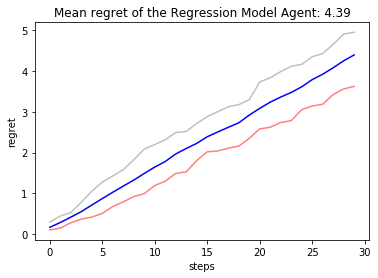

In [118]:
plt.plot(regrets_reg.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets_reg, 0.05,axis=0), color='red', alpha=0.5)
plt.plot(np.quantile(regrets_reg, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret of the Regression Model Agent: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

# 4. Agent avec *KNN*

Dans cet agent, on utilise l'algorithme KNN afin de recommander un utilisateur à un utilisateur. Afin que l'agent soit en accord avec notre environnement, nous avons choisi d'implémenter l'algorithme KNN sur un seul utilisateur (1 voisin plus proche). Pour un certain utilisateur, on prend un utilisateur avec qui il est déjà amis. Ensuite on effectur le KNN sur cet utilisateur. On va récupérer les plus proches voisin de cet utilisateur et c'est ainsi qu'on fait la recommandation à l'utilisateur initial. 


In [121]:
class KNNAgent:
    
    def __init__(self):
        pass
    
    def action(self, user_id, interactions, users_available):
        #On récupère la matrice d'intéractions
        interactions2 = interactions.todense()
        df = conv_to_df(interactions2)
        df_2 =df.pivot(index = 'user_id_2', columns = 'user_id', values = 'interactions').fillna(0)
        
        #On récupère la ligne de la matrice correspondant au current_user
        user_int_vect = interactions2[user_id,:]
        #On récupère la liste des personnes avec qui l'utilisateur est déjà amis. 
        already_friends=[]
        for i in range (interactions2.shape[0]):
            if (user_int_vect[0,i]!=0 or user_int_vect[0,i]!=1):
                 already_friends.append(i)
        
        last_added_friend = random.choice(already_friends)
        #prendre son rating 
        reward = interactions2[user_id,last_added_friend]
        

        
        user_rating_matrix = csr_matrix(df_2.values)
        model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
        model_knn.fit(user_rating_matrix)
        query_index = last_added_friend
        distances, indices = model_knn.kneighbors(df_2.iloc[query_index,:].values.reshape(1, -1), n_neighbors = interactions2.shape[0])
        indices = list(indices[0])
        distances_available=[]
        indices_available=[]

        for i in users_available :
            
            k=indices.index(i)
            distances_available.append(distances[0][k])
            indices_available.append(k)
            
        idx_min_dist = np.argmin(distances_available)
        recommended_friend = users_available[idx_min_dist]
        return recommended_friend,reward

# Génération des expériences avec *KNN Agent*

In [122]:
def run_exp(agent, env, nb_steps, interactions):
    rewards = []
    regrets_knn = np.zeros(nb_steps)
    actions = []
    pred_rewards = []

    for t in range(nb_steps):
        user_id, friends_to_recommend= env.step()
        friends_to_recommend = list(friends_to_recommend)
        friend_chosen, pred_reward=agent.action(user_id, interactions, friends_to_recommend)
        print("user_id =",user_id, "items_to_recommend=",friends_to_recommend,"friend_chosen=",friend_chosen)
        real_reward_curr_user = env.calc_real_reward(pred_reward)
        real_reward_recom_user = env.calc_real_reward(pred_reward)
        interactions = env.update(user_id,friend_chosen,real_reward_curr_user, real_reward_recom_user)
        rewards.append(real_reward_curr_user)
        pred_rewards.append(pred_reward)
        actions.append(friend_chosen)
    
    reward = sum( rewards)
    rewards = np.array(rewards)
    pred_rewards = np.array(pred_rewards)
    regrets_knn = abs(pred_rewards - rewards)
    regret = np.sum(regrets_knn)
    
    return {'reward': reward, 
            'regret': regret,
            'rewards': rewards,
            'regrets': regrets_knn,
            'actions': actions,
            'cum_rewards': np.cumsum(rewards), 
            'cum_regrets': np.cumsum(regrets_knn)
            }

In [123]:
nb_exp = 20
nb_steps = 30
regret = np.zeros(nb_exp)
regrets_knn = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    print("----------Exp----")
    env = Env(nb_users)
    possible_match, interactions = env.reset(seed=None)
    agent=KNNAgent()
    exp = run_exp(agent, env, nb_steps, interactions)
    regret[i] = exp['regret'] 
    regrets_knn[i] = exp['cum_regrets']

----------Exp----
user_id = 127 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 15, 16, 18, 19, 22, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 49, 51, 53, 55, 56, 57, 58, 60, 61, 64, 66, 67, 68, 70, 71, 72, 73, 74, 75, 77, 79, 80, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 97, 98, 99, 100, 101, 103, 104, 106, 107, 108, 109, 110, 113, 114, 116, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 132, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 195, 196, 198] friend_chosen= 103


/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 148 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 19, 23, 24, 26, 28, 29, 30, 32, 33, 38, 40, 41, 43, 44, 45, 46, 47, 48, 50, 51, 52, 54, 55, 56, 57, 58, 60, 61, 63, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 82, 83, 85, 88, 90, 91, 92, 93, 94, 95, 96, 98, 99, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 122, 123, 124, 125, 126, 129, 130, 131, 133, 134, 136, 137, 140, 141, 142, 143, 145, 146, 147, 149, 150, 151, 152, 155, 156, 157, 158, 160, 161, 162, 163, 164, 166, 167, 169, 172, 173, 175, 177, 178, 183, 184, 187, 188, 189, 190, 191, 192, 193, 194, 195, 198, 199] friend_chosen= 158
user_id = 91 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 16, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 59, 60, 63, 65, 66, 67, 68, 70, 72, 73, 77, 78, 79, 80, 81, 82, 84, 86, 87, 90, 92, 93, 96, 97, 101, 102, 103, 104, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 197 items_to_recommend= [0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 44, 46, 47, 48, 49, 50, 51, 54, 55, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 79, 80, 81, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 100, 102, 103, 104, 106, 107, 110, 111, 112, 113, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 136, 137, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 158, 159, 161, 162, 164, 165, 167, 169, 170, 172, 173, 175, 178, 180, 181, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 199] friend_chosen= 67
user_id = 53 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 37, 38, 40, 41, 42, 43, 46, 48, 49, 50, 52, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 69, 70, 71, 74, 75, 76, 77, 79, 80, 81,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 94 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 33, 34, 35, 39, 41, 43, 44, 45, 47, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 77, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 91, 93, 95, 96, 97, 98, 103, 104, 106, 107, 109, 110, 111, 112, 113, 114, 115, 118, 119, 121, 123, 124, 126, 127, 128, 129, 130, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 152, 153, 154, 157, 158, 159, 160, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 184, 185, 186, 187, 188, 190, 191, 192, 194, 195, 196, 197, 198, 199] friend_chosen= 69
user_id = 180 items_to_recommend= [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 61, 63, 66, 67, 68, 69, 70, 71, 73, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 57 items_to_recommend= [3, 4, 6, 7, 8, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 48, 50, 51, 52, 53, 55, 56, 58, 59, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 84, 85, 86, 87, 89, 91, 92, 93, 94, 96, 98, 99, 100, 102, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 120, 121, 122, 123, 124, 125, 128, 129, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 158, 159, 161, 162, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 178, 180, 181, 182, 183, 184, 187, 188, 189, 190, 191, 192, 194, 195, 197, 198, 199] friend_chosen= 48
user_id = 138 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 24, 25, 26, 27, 29, 30, 31, 33, 34, 36, 37, 38, 42, 43, 47, 48, 49, 50, 51, 54, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 77, 80, 81, 82, 84, 86, 87, 90, 93, 94, 95, 97, 98, 99, 100, 102, 104

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


162 items_to_recommend= [0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 35, 36, 37, 38, 39, 40, 41, 43, 46, 48, 49, 50, 51, 52, 55, 56, 57, 58, 62, 63, 64, 66, 69, 70, 72, 73, 74, 75, 76, 77, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 106, 107, 108, 109, 111, 112, 113, 115, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 129, 130, 131, 132, 133, 136, 137, 138, 140, 141, 142, 143, 144, 145, 146, 147, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 166, 167, 168, 169, 171, 172, 174, 175, 177, 178, 180, 181, 183, 184, 186, 189, 191, 192, 196, 197, 198, 199] friend_chosen= 49
user_id = 76 items_to_recommend= [2, 3, 4, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 26, 27, 28, 29, 30, 32, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 52, 53, 54, 55, 56, 57, 58, 61, 62, 65, 67, 68, 69, 70, 71, 74, 75, 77, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 98, 101, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 164 items_to_recommend= [0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 49, 51, 52, 53, 54, 57, 59, 60, 61, 62, 63, 65, 66, 69, 70, 71, 73, 74, 75, 76, 78, 79, 80, 81, 83, 84, 85, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 133, 135, 137, 138, 139, 140, 141, 143, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 159, 162, 163, 165, 166, 168, 170, 171, 172, 173, 174, 175, 176, 183, 184, 185, 187, 188, 190, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 190
user_id = 102 items_to_recommend= [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 23, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 39, 41, 42, 43, 44, 45, 48, 50, 51, 52, 54, 55, 58, 59, 60, 61, 62, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 48 items_to_recommend= [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 49, 51, 55, 58, 59, 60, 63, 64, 65, 66, 67, 68, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 84, 85, 86, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 130, 132, 133, 135, 136, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 170, 171, 173, 174, 175, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 193, 195, 196, 197, 198, 199] friend_chosen= 29
user_id = 69 items_to_recommend= [0, 1, 2, 3, 5, 6, 8, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 73

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 98 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 20, 21, 22, 23, 24, 25, 26, 27, 31, 32, 34, 35, 36, 37, 38, 39, 40, 45, 46, 47, 48, 49, 51, 53, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 88, 90, 91, 92, 93, 94, 95, 99, 100, 101, 102, 104, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 145, 146, 147, 148, 149, 150, 153, 154, 155, 156, 157, 158, 159, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197] friend_chosen= 3
user_id = 86 items_to_recommend= [1, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 26, 29, 30, 33, 34, 36, 37, 38, 39, 43, 44, 45, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 67, 68, 71, 72, 73, 74, 75, 76,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 199 items_to_recommend= [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 22, 24, 26, 28, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 43, 44, 45, 46, 47, 49, 51, 54, 56, 57, 58, 60, 61, 63, 64, 65, 67, 68, 69, 70, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 85, 86, 91, 92, 93, 95, 96, 97, 98, 99, 101, 102, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 118, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 137, 140, 141, 142, 143, 144, 146, 148, 149, 150, 151, 152, 153, 154, 156, 158, 159, 160, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 178, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 197] friend_chosen= 114
user_id = 156 items_to_recommend= [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 19, 21, 23, 24, 25, 26, 27, 30, 31, 36, 38, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 69, 71, 74, 75, 76, 78, 80, 81, 82, 84, 87, 89, 91, 92, 93, 94, 96, 97, 98, 99, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 72 items_to_recommend= [1, 2, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 48, 50, 51, 52, 54, 55, 56, 58, 60, 61, 62, 64, 65, 67, 68, 69, 70, 73, 74, 75, 76, 77, 80, 81, 82, 83, 85, 86, 87, 89, 90, 91, 92, 93, 96, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 111, 113, 116, 117, 118, 119, 120, 121, 122, 124, 125, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 142, 144, 145, 147, 148, 149, 150, 155, 156, 158, 159, 160, 161, 163, 164, 167, 168, 171, 172, 173, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 190, 191, 192, 193, 195, 196, 197, 198, 199] friend_chosen= 185
user_id = 94 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 33, 34, 35, 39, 41, 43, 44, 45, 47, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 70, 72, 73, 74, 75, 77, 79, 80, 81, 82, 83, 84, 85, 86, 88

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 15 items_to_recommend= [0, 1, 2, 3, 5, 6, 7, 9, 10, 12, 13, 14, 16, 18, 21, 22, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 55, 56, 57, 60, 61, 62, 63, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 78, 79, 80, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 165, 166, 170, 171, 173, 174, 175, 176, 177, 179, 181, 182, 183, 184, 185, 186, 188, 189, 190, 191, 194, 195, 197, 198, 199] friend_chosen= 191
user_id = 153 items_to_recommend= [0, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 166 items_to_recommend= [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 49, 51, 52, 54, 55, 56, 57, 58, 59, 61, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 85, 86, 88, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 141, 144, 147, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 167, 168, 169, 170, 171, 172, 173, 174, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 192, 194, 196, 197] friend_chosen= 20
user_id = 132 items_to_recommend= [0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 40, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 54, 55, 57, 58, 59, 61, 62, 63, 64, 67, 68, 69, 70, 71, 73, 74, 77, 79, 80, 82

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 103 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28, 30, 31, 33, 34, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 49, 50, 51, 52, 54, 55, 58, 60, 62, 63, 64, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95, 96, 98, 100, 101, 102, 104, 108, 109, 113, 114, 115, 116, 117, 118, 119, 121, 122, 124, 125, 126, 128, 129, 130, 131, 132, 133, 135, 136, 137, 139, 140, 143, 144, 145, 146, 148, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 166, 167, 168, 170, 172, 173, 174, 176, 177, 178, 181, 183, 184, 185, 186, 187, 188, 190, 191, 192, 194, 195, 196, 197, 199] friend_chosen= 192
user_id = 153 items_to_recommend= [0, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 56, 58, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 77, 78

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 88 items_to_recommend= [0, 2, 4, 5, 6, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 35, 36, 37, 40, 41, 42, 44, 46, 47, 48, 50, 52, 53, 54, 55, 56, 57, 61, 64, 65, 66, 69, 70, 71, 72, 73, 75, 76, 77, 79, 81, 82, 83, 84, 85, 87, 90, 94, 95, 97, 98, 99, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 117, 118, 119, 120, 121, 122, 124, 125, 126, 128, 130, 132, 134, 135, 136, 138, 139, 140, 141, 142, 143, 145, 146, 147, 149, 150, 151, 152, 154, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 196, 197, 199] friend_chosen= 146
----------Exp----
user_id = 26 items_to_recommend= [0, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 29, 30, 32, 33, 34, 36, 37, 40, 42, 44, 45, 46, 47, 49, 51, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68, 71, 72, 73, 74, 75, 76, 78, 80, 81, 82, 83, 84, 85, 87, 88, 90, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 94 items_to_recommend= [0, 1, 3, 4, 5, 7, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 23, 24, 25, 27, 28, 29, 30, 33, 34, 35, 36, 37, 38, 40, 42, 44, 45, 46, 47, 49, 50, 51, 53, 54, 55, 56, 58, 60, 61, 62, 64, 65, 67, 68, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 83, 84, 86, 89, 90, 91, 93, 95, 97, 98, 99, 100, 101, 103, 107, 108, 109, 111, 113, 114, 115, 116, 118, 120, 121, 122, 123, 124, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 176, 177, 178, 179, 180, 182, 183, 184, 185, 187, 189, 190, 192, 193, 194, 196, 197, 198, 199] friend_chosen= 115
user_id = 165 items_to_recommend= [0, 1, 2, 4, 5, 6, 7, 10, 11, 12, 13, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 31, 32, 35, 36, 37, 39, 40, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 61, 62, 63, 64, 67, 68, 69, 71, 72, 74, 75, 77, 79, 80, 82, 84, 87, 88, 90, 91, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 67 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 28, 29, 30, 31, 32, 33, 34, 35, 38, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 65, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 105, 106, 107, 110, 112, 114, 118, 120, 121, 122, 124, 125, 126, 130, 131, 132, 134, 135, 136, 137, 138, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 165, 166, 167, 169, 170, 171, 172, 173, 174, 176, 178, 179, 181, 182, 183, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198, 199] friend_chosen= 189
user_id = 36 items_to_recommend= [0, 3, 4, 5, 6, 8, 9, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 29, 32, 33, 37, 40, 41, 42, 43, 44, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 67, 68, 72, 73, 74, 76, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 91

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 144 items_to_recommend= [0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 66, 67, 68, 69, 70, 73, 74, 76, 81, 82, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 104, 105, 107, 109, 110, 112, 113, 114, 117, 118, 119, 120, 121, 122, 123, 125, 126, 128, 129, 130, 131, 132, 135, 136, 138, 140, 142, 143, 145, 146, 147, 148, 149, 150, 151, 153, 155, 157, 158, 159, 160, 161, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 183, 185, 186, 188, 189, 190, 191, 195, 196, 197, 198, 199] friend_chosen= 36
user_id = 186 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 51, 52, 54, 55, 58, 59, 60, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 75, 78, 79, 81, 82, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 191 items_to_recommend= [0, 1, 3, 4, 5, 6, 7, 8, 11, 13, 14, 17, 18, 19, 20, 21, 23, 26, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 47, 49, 50, 51, 52, 53, 55, 57, 58, 59, 63, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 78, 79, 80, 82, 83, 84, 85, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 108, 109, 110, 111, 114, 115, 116, 117, 119, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 133, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 153, 158, 159, 160, 161, 162, 163, 164, 165, 169, 172, 173, 174, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 190, 192, 193, 194, 196, 197, 198, 199] friend_chosen= 36
user_id = 124 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 57, 58, 59, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 194 items_to_recommend= [1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 49, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 66, 68, 69, 70, 71, 74, 75, 76, 77, 78, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 93, 94, 96, 97, 98, 100, 102, 103, 104, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 118, 119, 121, 124, 125, 126, 127, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 151, 152, 156, 157, 160, 161, 162, 163, 164, 165, 167, 169, 170, 172, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 185, 187, 188, 189, 190, 192, 193, 195, 197, 198] friend_chosen= 124
user_id = 160 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 17, 18, 20, 21, 23, 26, 27, 28, 30, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 61, 62, 63, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 80, 82, 83, 84, 85, 86, 87, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 166 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 21, 22, 23, 24, 25, 27, 31, 32, 33, 34, 35, 36, 42, 43, 44, 45, 46, 47, 49, 51, 52, 53, 55, 57, 59, 60, 61, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 83, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 112, 113, 114, 117, 118, 119, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 167, 168, 169, 171, 172, 173, 174, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 195, 197, 198, 199] friend_chosen= 92
user_id = 49 items_to_recommend= [0, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 63, 64, 65, 66, 68, 69,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 120 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 24, 28, 29, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 49, 50, 51, 52, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65, 66, 67, 68, 71, 72, 73, 74, 76, 77, 78, 80, 81, 82, 84, 85, 86, 87, 88, 90, 91, 93, 95, 97, 99, 100, 101, 106, 107, 108, 109, 110, 111, 113, 114, 115, 117, 118, 119, 121, 123, 124, 126, 128, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 149, 150, 151, 152, 153, 154, 156, 157, 160, 162, 163, 164, 166, 167, 169, 172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 190, 191, 193, 195, 196, 197, 198, 199] friend_chosen= 41
user_id = 128 items_to_recommend= [1, 2, 4, 5, 6, 7, 8, 11, 12, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 74, 75, 76, 77, 78, 79, 80, 81,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 159 items_to_recommend= [0, 1, 2, 4, 5, 7, 8, 10, 11, 12, 14, 16, 17, 19, 21, 22, 24, 25, 26, 30, 31, 32, 33, 34, 38, 39, 40, 41, 42, 47, 50, 51, 52, 53, 54, 56, 57, 58, 59, 61, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 86, 87, 88, 89, 90, 92, 93, 94, 95, 97, 98, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 117, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 134, 136, 139, 141, 142, 143, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 163, 164, 166, 167, 168, 170, 172, 173, 174, 175, 176, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 97
user_id = 182 items_to_recommend= [1, 2, 3, 7, 8, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 29, 31, 32, 33, 34, 36, 38, 42, 43, 46, 47, 48, 49, 51, 52, 53, 54, 57, 58, 59, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 74, 75, 76, 78, 79, 80, 81, 82, 83, 85

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 89 items_to_recommend= [0, 1, 2, 4, 5, 6, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 74, 75, 76, 79, 80, 82, 83, 84, 85, 86, 87, 90, 92, 93, 94, 95, 97, 99, 101, 103, 104, 105, 107, 108, 109, 111, 112, 113, 115, 116, 117, 118, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 156, 157, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 199] friend_chosen= 36
user_id = 33 items_to_recommend= [0, 1, 3, 7, 9, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 26, 27, 30, 31, 32, 34, 36, 37, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 61, 62, 63, 64

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 1 items_to_recommend= [0, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 26, 28, 29, 30, 32, 33, 35, 38, 41, 43, 44, 45, 46, 47, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 64, 68, 69, 71, 72, 74, 75, 76, 77, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 133, 136, 138, 140, 141, 142, 143, 144, 146, 147, 149, 153, 155, 158, 159, 161, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 177, 178, 179, 181, 182, 183, 184, 186, 189, 190, 193, 194, 196, 198, 199] friend_chosen= 104
user_id = 146 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 35, 37, 38, 39, 41, 43, 44, 45, 46, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 78, 79, 81, 83, 84, 86, 87, 88, 89, 90, 91

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 155 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 31, 33, 34, 35, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 63, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 86, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 156, 157, 159, 160, 162, 163, 164, 165, 167, 168, 171, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 194, 196, 198] friend_chosen= 127
user_id = 160 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 17, 18, 20, 21, 23, 26, 27, 28, 30, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 61, 62, 63, 67, 68, 69, 70, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 42 items_to_recommend= [0, 1, 3, 5, 6, 7, 8, 10, 11, 14, 18, 20, 22, 24, 26, 27, 28, 29, 31, 32, 33, 35, 36, 37, 40, 41, 43, 51, 53, 54, 55, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 76, 78, 79, 80, 82, 83, 84, 86, 88, 89, 90, 91, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 105, 107, 108, 109, 110, 111, 112, 115, 117, 119, 121, 122, 123, 124, 126, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 181, 183, 184, 186, 193, 196, 197, 198] friend_chosen= 149
user_id = 126 items_to_recommend= [2, 3, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 58, 59, 60, 62, 63, 64, 65, 67, 68, 70, 71, 72, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 67 items_to_recommend= [1, 3, 4, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 44, 45, 46, 47, 48, 51, 52, 58, 60, 61, 62, 63, 64, 65, 66, 68, 69, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 99, 100, 102, 104, 105, 107, 108, 109, 110, 111, 113, 117, 119, 120, 121, 122, 123, 125, 126, 127, 128, 130, 131, 132, 134, 135, 136, 137, 139, 140, 141, 142, 143, 145, 147, 148, 152, 153, 155, 157, 158, 159, 160, 161, 162, 164, 165, 167, 168, 171, 174, 175, 176, 177, 180, 181, 182, 184, 185, 186, 187, 189, 190, 191, 192, 195, 196, 197, 198, 199] friend_chosen= 111
user_id = 34 items_to_recommend= [0, 1, 3, 4, 6, 7, 9, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 35, 36, 37, 38, 39, 40, 41, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 79, 80, 81, 82, 84, 86, 87, 88, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 41 items_to_recommend= [0, 1, 3, 5, 7, 11, 12, 13, 14, 15, 16, 17, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 32, 34, 36, 37, 38, 40, 43, 44, 45, 47, 49, 50, 52, 53, 54, 56, 57, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 86, 87, 89, 90, 91, 92, 93, 94, 95, 97, 98, 100, 101, 102, 103, 105, 106, 108, 109, 111, 113, 114, 115, 117, 118, 119, 121, 122, 123, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 163, 164, 166, 167, 168, 171, 172, 174, 176, 177, 179, 181, 183, 184, 185, 186, 187, 188, 189, 191, 192, 194, 197, 198, 199] friend_chosen= 163
user_id = 54 items_to_recommend= [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 34, 35, 36, 39, 40, 41, 42, 45, 46, 50, 52, 57, 58, 60, 61, 63, 65, 66, 68, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 97, 98

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 68 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 52, 54, 57, 58, 60, 61, 62, 64, 67, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 111, 112, 113, 114, 115, 117, 118, 119, 121, 122, 123, 124, 128, 129, 130, 132, 134, 135, 136, 137, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 155, 156, 158, 159, 160, 161, 162, 164, 165, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198] friend_chosen= 190
user_id = 35 items_to_recommend= [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 27, 29, 30, 31, 33, 34, 36, 39, 40, 42, 43, 46, 47, 48, 49, 51, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65, 67, 68, 69, 71, 72, 74, 76, 77, 78, 81, 82

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 80 items_to_recommend= [1, 3, 4, 5, 6, 8, 9, 10, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 28, 29, 30, 31, 32, 33, 35, 36, 38, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 54, 56, 59, 60, 61, 62, 63, 65, 66, 68, 69, 72, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 128, 129, 131, 132, 133, 136, 137, 138, 139, 141, 143, 144, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 169, 171, 173, 177, 178, 180, 181, 182, 185, 186, 188, 190, 191, 192, 193, 194, 196, 197, 198] friend_chosen= 97
user_id = 142 items_to_recommend= [0, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 55, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 74, 75, 76, 77, 79, 80, 82, 84, 85, 86, 88, 89, 90,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 109 items_to_recommend= [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 32, 33, 35, 36, 37, 38, 42, 43, 44, 45, 46, 47, 48, 49, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 81, 82, 84, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 119, 121, 124, 125, 127, 128, 129, 131, 132, 134, 135, 136, 137, 140, 141, 142, 143, 144, 145, 147, 149, 150, 151, 152, 153, 154, 157, 158, 159, 161, 162, 163, 164, 165, 167, 168, 171, 172, 173, 174, 175, 176, 177, 179, 181, 182, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 198, 199] friend_chosen= 187
user_id = 26 items_to_recommend= [0, 1, 2, 3, 4, 6, 10, 11, 12, 13, 15, 20, 21, 23, 24, 28, 29, 30, 32, 33, 36, 37, 38, 39, 40, 41, 43, 44, 46, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 84

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 63 items_to_recommend= [2, 3, 5, 7, 8, 10, 11, 13, 15, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 76, 77, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 143, 144, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 160, 161, 162, 163, 164, 167, 168, 169, 170, 172, 174, 175, 176, 177, 178, 179, 181, 182, 185, 186, 187, 188, 189, 190, 191, 192, 193, 195, 197, 199] friend_chosen= 98
user_id = 102 items_to_recommend= [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 59, 60, 62, 63, 65, 66, 67, 68, 69, 70, 71, 73, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 125 items_to_recommend= [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 34, 37, 39, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 57, 58, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 83, 84, 85, 86, 87, 88, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 114, 115, 116, 119, 121, 122, 123, 124, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 148, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 164, 165, 167, 168, 169, 170, 171, 172, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 194, 195, 196, 197, 198] friend_chosen= 195
user_id = 23 items_to_recommend= [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22, 24, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 67, 68, 70, 71, 72, 73,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 167 items_to_recommend= [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 44, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 60, 61, 62, 63, 66, 67, 68, 69, 70, 72, 74, 75, 76, 77, 78, 81, 83, 84, 86, 87, 88, 89, 90, 91, 95, 96, 97, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 118, 121, 122, 123, 124, 125, 127, 128, 129, 130, 132, 133, 134, 135, 136, 137, 139, 140, 144, 145, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199] friend_chosen= 101
user_id = 20 items_to_recommend= [0, 1, 2, 4, 6, 8, 9, 10, 11, 12, 14, 18, 19, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 35, 36, 37, 38, 39, 40, 42, 43, 45, 46, 47, 48, 49, 50, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 13 items_to_recommend= [0, 1, 3, 4, 5, 7, 8, 9, 10, 14, 15, 16, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 37, 38, 39, 40, 42, 44, 45, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 67, 68, 70, 71, 72, 74, 76, 77, 79, 81, 83, 84, 85, 86, 90, 91, 93, 94, 95, 97, 101, 102, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 126, 128, 129, 130, 131, 132, 133, 137, 138, 139, 140, 141, 142, 147, 148, 149, 150, 151, 153, 155, 156, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 171, 173, 174, 175, 176, 177, 178, 180, 181, 182, 183, 184, 186, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199] friend_chosen= 153
user_id = 90 items_to_recommend= [2, 3, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 36, 37, 38, 39, 40, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 57, 58, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 74, 75, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 92, 93, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 177 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 51, 53, 56, 59, 60, 61, 62, 63, 64, 65, 66, 68, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 98, 99, 100, 101, 102, 104, 105, 107, 108, 109, 111, 115, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 138, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 154, 155, 157, 158, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 181, 185, 186, 187, 188, 190, 191, 195, 196, 197, 198, 199] friend_chosen= 119
user_id = 3 items_to_recommend= [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 43, 46, 47, 48, 49, 50, 51, 52, 53, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


 109
user_id = 190 items_to_recommend= [0, 2, 3, 4, 6, 7, 8, 9, 12, 13, 14, 16, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 75, 76, 78, 80, 82, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 97, 98, 99, 100, 101, 103, 104, 105, 106, 108, 109, 110, 111, 113, 114, 116, 117, 118, 119, 120, 122, 123, 125, 126, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 141, 142, 143, 144, 146, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 185, 186, 187, 191, 192, 193, 196, 197, 198, 199] friend_chosen= 192


/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 51 items_to_recommend= [0, 1, 2, 4, 5, 8, 9, 10, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 34, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 57, 58, 59, 60, 63, 64, 65, 66, 67, 68, 69, 71, 73, 74, 76, 78, 80, 81, 82, 84, 85, 87, 88, 89, 91, 92, 93, 95, 96, 97, 99, 100, 102, 103, 104, 106, 107, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 164, 166, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 71
user_id = 84 items_to_recommend= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 42, 44, 46, 47, 48, 52, 53, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 73, 74, 75, 76, 77, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 176 items_to_recommend= [0, 1, 3, 4, 5, 7, 8, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 24, 26, 27, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 62, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 87, 88, 89, 90, 92, 95, 97, 100, 104, 105, 108, 109, 110, 111, 112, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 126, 127, 130, 131, 133, 134, 136, 137, 139, 141, 143, 144, 145, 146, 147, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 170, 173, 175, 177, 178, 181, 182, 183, 184, 186, 187, 189, 190, 191, 192, 193, 194, 197, 198, 199] friend_chosen= 20
user_id = 191 items_to_recommend= [0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 26, 29, 30, 31, 33, 34, 35, 36, 37, 38, 41, 42, 43, 45, 46, 47, 49, 51, 52, 57, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 73, 74, 75, 78, 79, 80, 81, 84, 86, 87, 88, 89, 90, 92, 93, 94, 95, 9

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 53 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 41, 44, 45, 46, 48, 49, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 77, 79, 80, 81, 83, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 104, 106, 108, 109, 110, 111, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 131, 132, 134, 135, 136, 137, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 152, 153, 155, 156, 157, 158, 159, 160, 162, 163, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 185, 186, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199] friend_chosen= 199
user_id = 49 items_to_recommend= [0, 1, 2, 3, 6, 8, 9, 11, 13, 14, 16, 17, 18, 20, 21, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 44, 45, 46, 47, 48, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 75

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 194 items_to_recommend= [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 55, 56, 58, 59, 62, 63, 65, 66, 67, 68, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 108, 110, 111, 113, 114, 115, 117, 118, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 138, 139, 140, 142, 143, 144, 145, 146, 147, 149, 150, 153, 154, 155, 157, 159, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 176, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 195, 196, 197, 198, 199] friend_chosen= 192
user_id = 85 items_to_recommend= [0, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 28, 29, 31, 34, 35, 36, 37, 39, 41, 42, 43, 45, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 104 items_to_recommend= [1, 2, 4, 5, 7, 8, 10, 12, 14, 16, 17, 18, 19, 21, 22, 23, 24, 27, 28, 29, 30, 32, 34, 35, 36, 38, 39, 41, 42, 43, 44, 46, 48, 50, 51, 52, 53, 54, 55, 58, 59, 62, 63, 66, 67, 68, 69, 70, 71, 75, 76, 77, 78, 79, 82, 83, 84, 85, 88, 90, 91, 92, 93, 94, 96, 98, 99, 100, 102, 103, 106, 107, 110, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 141, 142, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 198, 199] friend_chosen= 133
user_id = 172 items_to_recommend= [0, 1, 2, 3, 4, 7, 8, 9, 11, 14, 15, 16, 17, 18, 20, 21, 23, 24, 25, 27, 28, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 69, 70, 71, 72, 73, 74, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 19 items_to_recommend= [0, 1, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 57, 59, 60, 61, 63, 67, 68, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 110, 111, 113, 114, 115, 116, 117, 120, 122, 124, 125, 126, 127, 131, 132, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 151, 152, 153, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 195, 196, 197, 198] friend_chosen= 179
user_id = 87 items_to_recommend= [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 22, 24, 25, 27, 28, 29, 31, 33, 34, 36, 37, 38, 40, 41, 44, 45, 46, 50, 51, 52, 54, 55, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 75, 77, 78, 79, 81, 82, 83, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 68 items_to_recommend= [1, 4, 6, 7, 9, 12, 15, 16, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 30, 31, 34, 36, 38, 39, 40, 41, 42, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 58, 59, 60, 61, 62, 63, 64, 66, 67, 69, 70, 71, 72, 73, 74, 76, 79, 80, 81, 82, 83, 84, 86, 87, 88, 90, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 115, 116, 117, 119, 121, 122, 123, 124, 125, 127, 128, 130, 131, 133, 134, 135, 136, 138, 139, 140, 141, 142, 145, 146, 148, 149, 150, 151, 152, 157, 158, 159, 160, 162, 163, 164, 165, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 184, 185, 186, 187, 191, 194, 195, 197, 199] friend_chosen= 27
user_id = 29 items_to_recommend= [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30, 31, 32, 33, 36, 37, 40, 41, 42, 43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 58, 61, 62, 63, 64, 66, 67, 69, 70, 71, 72, 74, 75, 76, 77, 80, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 95, 98,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 129 items_to_recommend= [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 22, 24, 25, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47, 49, 51, 52, 53, 54, 55, 56, 57, 60, 61, 63, 65, 66, 68, 70, 72, 73, 75, 76, 80, 81, 82, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 96, 98, 100, 102, 103, 104, 105, 106, 107, 109, 110, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 134, 136, 137, 138, 139, 140, 141, 143, 144, 146, 147, 149, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 170, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 194, 195, 196, 198] friend_chosen= 24
user_id = 116 items_to_recommend= [0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 19, 21, 22, 23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 38, 40, 41, 42, 46, 47, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 56 items_to_recommend= [0, 1, 3, 4, 6, 7, 8, 9, 11, 12, 15, 16, 17, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 57, 58, 60, 65, 66, 67, 68, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 93, 94, 96, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 114, 115, 116, 117, 119, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 163, 164, 165, 166, 167, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 196, 197, 198, 199] friend_chosen= 19
user_id = 89 items_to_recommend= [0, 2, 3, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 71, 72

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 16 items_to_recommend= [1, 3, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 76, 77, 78, 80, 81, 82, 83, 84, 87, 88, 89, 90, 91, 92, 94, 97, 98, 99, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 140, 141, 142, 144, 145, 146, 147, 148, 149, 151, 153, 154, 155, 156, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 181, 182, 183, 184, 185, 186, 187, 190, 191, 192, 196, 197, 199] friend_chosen= 184
user_id = 120 items_to_recommend= [0, 2, 3, 4, 5, 7, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 32, 33, 34, 36, 37, 38, 39, 40, 43, 44, 45, 46, 49, 50, 51, 52, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 68, 69, 70, 71, 73, 75, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 108 items_to_recommend= [0, 1, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 49, 50, 52, 54, 55, 57, 58, 59, 60, 62, 64, 66, 68, 69, 70, 72, 73, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 91, 94, 95, 98, 99, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 113, 114, 115, 116, 117, 119, 121, 122, 123, 125, 126, 127, 128, 131, 132, 134, 135, 138, 139, 140, 145, 146, 148, 149, 152, 153, 154, 155, 159, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 183, 184, 187, 190, 191, 192, 193, 195, 196, 198, 199] friend_chosen= 85
user_id = 78 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 30, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 77, 79, 80, 81, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 132 items_to_recommend= [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 14, 16, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 32, 33, 34, 35, 37, 38, 39, 40, 42, 43, 47, 48, 50, 51, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 83, 84, 86, 88, 89, 92, 93, 94, 95, 99, 100, 101, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 121, 122, 123, 124, 125, 126, 129, 130, 134, 135, 136, 138, 139, 140, 141, 143, 145, 147, 149, 150, 152, 153, 154, 156, 157, 159, 160, 162, 163, 164, 165, 166, 167, 168, 171, 173, 174, 175, 176, 177, 179, 180, 182, 183, 184, 186, 187, 189, 190, 193, 194, 196, 197, 198, 199] friend_chosen= 176
user_id = 162 items_to_recommend= [1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 96 items_to_recommend= [0, 1, 4, 6, 8, 9, 10, 11, 13, 14, 16, 18, 19, 21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 99, 100, 101, 103, 104, 105, 107, 109, 111, 112, 113, 114, 115, 118, 120, 121, 122, 123, 124, 125, 126, 128, 129, 132, 134, 135, 136, 138, 140, 141, 143, 144, 146, 147, 148, 150, 151, 152, 153, 156, 157, 158, 159, 160, 161, 163, 164, 166, 167, 168, 169, 171, 172, 173, 174, 176, 177, 180, 182, 183, 184, 185, 186, 187, 189, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 157
user_id = 135 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 68, 71, 72, 73, 75, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 126 items_to_recommend= [2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 19, 21, 22, 23, 24, 26, 27, 28, 29, 30, 32, 35, 36, 37, 38, 40, 41, 43, 44, 47, 48, 49, 50, 51, 52, 55, 56, 58, 59, 61, 62, 63, 64, 65, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 90, 92, 96, 97, 99, 100, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 119, 121, 122, 123, 124, 125, 127, 128, 129, 130, 133, 134, 135, 136, 138, 143, 144, 145, 146, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 178, 179, 181, 183, 184, 185, 187, 188, 189, 190, 191, 192, 194, 195, 196, 197, 199] friend_chosen= 130
user_id = 168 items_to_recommend= [0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 22, 23, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 43, 44, 45, 46, 47, 48, 52, 54, 57, 58, 60, 61, 62, 63, 65, 66, 67, 71, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 90, 91, 92,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 110 items_to_recommend= [0, 3, 5, 6, 8, 10, 11, 12, 13, 15, 16, 21, 22, 23, 25, 26, 28, 29, 30, 31, 32, 33, 34, 36, 38, 39, 40, 41, 43, 44, 45, 47, 49, 50, 52, 54, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 70, 71, 72, 74, 75, 76, 77, 78, 79, 81, 84, 86, 88, 89, 90, 91, 94, 96, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 112, 113, 114, 115, 116, 117, 120, 121, 122, 124, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 149, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 163, 164, 165, 166, 167, 170, 172, 173, 175, 176, 177, 179, 181, 182, 183, 184, 185, 187, 189, 190, 191, 192, 194, 195, 197, 198] friend_chosen= 175
user_id = 16 items_to_recommend= [1, 3, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 76, 77, 78, 80, 81, 82, 83, 84, 87, 88, 89, 90, 91

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 132 items_to_recommend= [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 14, 16, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 32, 33, 34, 35, 37, 38, 39, 40, 42, 43, 47, 48, 50, 51, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 83, 84, 86, 88, 89, 92, 93, 94, 95, 99, 100, 101, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 121, 122, 123, 124, 125, 126, 129, 130, 134, 135, 136, 138, 139, 140, 141, 143, 145, 147, 149, 150, 152, 153, 154, 156, 157, 159, 160, 162, 163, 164, 165, 166, 167, 168, 171, 173, 174, 175, 177, 179, 180, 182, 183, 184, 186, 187, 189, 190, 193, 194, 196, 197, 198, 199] friend_chosen= 198
user_id = 128 items_to_recommend= [0, 2, 3, 4, 6, 7, 8, 9, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 27, 29, 30, 33, 35, 36, 38, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 56, 59, 60, 61, 62, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 95, 96, 97, 99, 102, 104, 10

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 38 items_to_recommend= [0, 3, 4, 6, 7, 8, 9, 10, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 30, 31, 32, 33, 34, 35, 36, 39, 40, 42, 43, 44, 46, 47, 48, 50, 51, 52, 54, 55, 56, 60, 63, 64, 66, 67, 68, 69, 72, 74, 76, 77, 78, 80, 81, 83, 85, 86, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 107, 108, 109, 111, 112, 113, 115, 116, 117, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 136, 138, 139, 142, 143, 144, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 168, 169, 170, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 184, 185, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 187
----------Exp----
user_id = 153 items_to_recommend= [1, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 27, 30, 31, 33, 34, 35, 36, 37, 39, 42, 43, 44, 45, 46, 47, 48, 49, 51, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 78, 79, 80, 81, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 59 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 22, 23, 25, 26, 27, 28, 29, 30, 35, 37, 39, 40, 41, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 60, 61, 64, 65, 66, 68, 69, 72, 73, 74, 75, 76, 78, 79, 82, 83, 86, 88, 91, 92, 93, 96, 97, 98, 100, 101, 105, 106, 107, 108, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 140, 141, 142, 144, 145, 146, 148, 149, 150, 151, 152, 153, 154, 155, 157, 159, 163, 164, 165, 167, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 192, 194, 195, 196, 197, 199] friend_chosen= 39
user_id = 181 items_to_recommend= [0, 1, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 27, 30, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 51, 52, 53, 55, 56, 57, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 91 items_to_recommend= [1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 38, 39, 40, 42, 43, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 68, 69, 71, 72, 74, 75, 76, 78, 79, 80, 81, 82, 83, 87, 89, 90, 92, 93, 94, 96, 98, 100, 101, 102, 103, 105, 108, 111, 112, 113, 116, 118, 120, 122, 123, 124, 125, 127, 130, 132, 133, 134, 136, 137, 139, 141, 142, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 180, 181, 182, 183, 184, 186, 187, 188, 190, 191, 193, 195, 196, 197, 199] friend_chosen= 153
user_id = 105 items_to_recommend= [0, 2, 3, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 30, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 76, 77, 78, 79, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 127 items_to_recommend= [0, 1, 3, 4, 5, 6, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 33, 35, 36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56, 59, 61, 62, 63, 64, 66, 67, 68, 69, 71, 73, 75, 76, 77, 79, 80, 81, 82, 83, 84, 87, 88, 89, 93, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 151, 154, 156, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 179, 180, 181, 184, 186, 187, 188, 189, 191, 193, 194, 196, 197, 198, 199] friend_chosen= 122
user_id = 157 items_to_recommend= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 40, 43, 44, 45, 47, 48, 49, 50, 51, 54, 56, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 78, 79, 80, 81, 83, 84, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 123 items_to_recommend= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 17, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 58, 59, 60, 62, 63, 64, 65, 66, 67, 69, 70, 72, 73, 75, 77, 79, 80, 81, 82, 83, 85, 87, 88, 90, 93, 94, 96, 97, 98, 100, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 120, 121, 122, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 140, 141, 142, 143, 144, 145, 147, 148, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 164, 165, 167, 168, 169, 170, 171, 172, 174, 175, 178, 179, 182, 183, 184, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 145
user_id = 131 items_to_recommend= [0, 2, 3, 5, 6, 7, 8, 10, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 36, 37, 39, 40, 41, 43, 44, 45, 46, 47, 48, 51, 54, 55, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 71 items_to_recommend= [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 60, 61, 62, 64, 65, 66, 67, 68, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 83, 85, 86, 87, 88, 89, 90, 91, 93, 96, 97, 98, 99, 100, 101, 102, 104, 105, 108, 111, 112, 113, 116, 117, 118, 119, 120, 121, 122, 126, 127, 129, 130, 131, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 180, 181, 183, 184, 185, 187, 188, 189, 192, 193, 195, 196, 199] friend_chosen= 163
user_id = 157 items_to_recommend= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 40, 43, 44, 45, 47, 48, 49, 50, 51, 54, 56, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 78, 79, 80, 81, 83, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 153 items_to_recommend= [1, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 27, 30, 31, 33, 34, 35, 36, 37, 39, 42, 43, 44, 45, 46, 47, 48, 49, 51, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 95, 96, 97, 98, 99, 100, 101, 104, 105, 106, 108, 109, 110, 111, 112, 113, 115, 118, 119, 120, 121, 122, 124, 125, 126, 127, 131, 132, 133, 134, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 150, 151, 152, 155, 163, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 181, 182, 184, 185, 186, 187, 189, 191, 192, 193, 194, 195, 196] friend_chosen= 23
user_id = 150 items_to_recommend= [0, 1, 4, 8, 10, 12, 13, 14, 16, 17, 18, 19, 21, 23, 24, 26, 27, 28, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 48, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 63, 64, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 92, 98, 100,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 106 items_to_recommend= [2, 4, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 28, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 65, 66, 67, 68, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 103, 105, 107, 108, 109, 111, 112, 113, 115, 116, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 131, 133, 135, 137, 139, 141, 142, 143, 145, 147, 148, 149, 150, 151, 153, 155, 158, 159, 160, 161, 162, 163, 164, 166, 167, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 35
user_id = 193 items_to_recommend= [1, 2, 3, 7, 8, 10, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 27, 28, 29, 31, 32, 34, 35, 36, 37, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 52, 54, 55, 56, 58, 59, 61, 62, 63, 64, 65, 66, 67, 69, 72, 73, 74, 75, 77, 78, 79, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 27 items_to_recommend= [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 62, 63, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 89, 91, 95, 96, 97, 99, 100, 102, 103, 105, 106, 107, 109, 111, 112, 113, 115, 116, 117, 118, 119, 120, 122, 123, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 146, 147, 148, 149, 152, 153, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 183, 184, 185, 187, 189, 191, 193, 194, 195, 197, 199] friend_chosen= 38
user_id = 194 items_to_recommend= [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 120 items_to_recommend= [1, 2, 3, 6, 7, 9, 10, 11, 13, 14, 16, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 35, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 52, 55, 56, 57, 58, 59, 60, 62, 63, 65, 66, 67, 69, 70, 71, 72, 75, 77, 79, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 103, 105, 106, 107, 108, 110, 111, 112, 113, 116, 117, 118, 119, 121, 122, 123, 124, 125, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 159, 160, 162, 164, 166, 168, 169, 171, 172, 173, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 96
user_id = 103 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 30, 31, 32, 33, 34, 35, 36, 39, 40, 42, 43, 44, 47, 48, 49, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 64, 66, 68, 69, 70, 71, 74, 75, 76, 78, 80, 81, 82, 83,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 42 items_to_recommend= [0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20, 22, 23, 24, 25, 26, 27, 29, 31, 34, 35, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 52, 54, 55, 56, 57, 58, 61, 65, 67, 68, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 90, 91, 92, 94, 95, 98, 100, 102, 104, 106, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 123, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 146, 149, 150, 151, 154, 155, 156, 157, 158, 159, 160, 163, 164, 165, 166, 167, 172, 174, 175, 176, 177, 178, 180, 182, 183, 184, 185, 187, 189, 192, 194, 195, 197, 198, 199] friend_chosen= 160
user_id = 178 items_to_recommend= [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 30, 31, 33, 35, 36, 37, 40, 41, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 61, 63, 64, 65, 66, 67, 69, 70, 72, 73, 76, 78, 79, 81, 82, 83, 85, 86, 87, 88, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 12 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 26, 27, 28, 31, 32, 33, 34, 35, 36, 38, 39, 40, 43, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 74, 75, 76, 77, 78, 79, 81, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 98, 100, 101, 102, 103, 104, 106, 108, 109, 110, 112, 114, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 154, 155, 156, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 194, 195, 197, 198, 199] friend_chosen= 182
user_id = 101 items_to_recommend= [0, 1, 2, 3, 5, 8, 10, 11, 12, 13, 14, 16, 17, 18, 21, 23, 24, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 41, 43, 44, 45, 46, 48, 49, 50, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 75, 76, 78, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 68 items_to_recommend= [1, 4, 5, 6, 9, 10, 11, 12, 14, 16, 18, 19, 21, 22, 23, 24, 25, 28, 29, 31, 35, 36, 37, 38, 40, 42, 44, 45, 47, 48, 52, 53, 54, 55, 56, 57, 58, 60, 61, 63, 64, 66, 67, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 81, 82, 83, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 119, 120, 121, 125, 126, 127, 128, 129, 132, 133, 135, 136, 138, 140, 141, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 162, 164, 165, 166, 169, 170, 171, 173, 174, 175, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 190, 191, 192, 193, 196, 197, 198, 199] friend_chosen= 108
user_id = 110 items_to_recommend= [1, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 22, 23, 24, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 43, 44, 45, 46, 49, 50, 51, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 74, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 163 items_to_recommend= [0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 71, 72, 74, 75, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 116, 118, 119, 120, 121, 123, 124, 127, 128, 129, 131, 133, 134, 136, 137, 138, 139, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 165, 166, 168, 170, 172, 174, 175, 177, 178, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 195, 198, 199] friend_chosen= 69
user_id = 60 items_to_recommend= [0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 49, 50, 51, 52, 53, 55, 58, 59, 62, 63, 65, 66, 67, 68, 69, 71, 72, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 128 items_to_recommend= [0, 1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 53, 55, 57, 58, 59, 61, 62, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 121, 122, 123, 125, 126, 127, 129, 130, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 150, 151, 152, 153, 154, 155, 157, 159, 161, 162, 165, 166, 167, 168, 169, 171, 174, 175, 176, 177, 180, 182, 183, 184, 186, 187, 188, 190, 191, 192, 194, 195, 196, 197, 198, 199] friend_chosen= 130
user_id = 96 items_to_recommend= [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 35, 36, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 156 items_to_recommend= [0, 2, 3, 4, 5, 6, 7, 8, 10, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 33, 34, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 116, 117, 118, 119, 120, 121, 124, 125, 126, 127, 128, 129, 130, 133, 134, 136, 138, 139, 140, 142, 144, 145, 146, 147, 150, 151, 154, 158, 159, 161, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 184, 185, 186, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199] friend_chosen= 109
user_id = 40 items_to_recommend= [0, 1, 2, 6, 9, 10, 11, 12, 13, 14, 16, 17, 19, 23, 24, 25, 26, 29, 30, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 49, 52, 53, 54, 55, 56, 57, 58, 59, 61, 63, 65, 66, 67, 69, 70, 71, 72, 73, 75, 76, 77, 80, 81, 82, 89,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 63 items_to_recommend= [0, 2, 3, 4, 5, 6, 9, 10, 13, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 31, 33, 34, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 64, 65, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 79, 80, 82, 83, 84, 85, 87, 89, 90, 91, 92, 94, 96, 97, 98, 102, 103, 104, 106, 107, 108, 109, 110, 111, 113, 116, 117, 120, 121, 122, 123, 126, 128, 130, 132, 133, 135, 136, 137, 138, 139, 141, 142, 144, 145, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 164, 165, 166, 170, 172, 174, 175, 176, 179, 181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 197, 198] friend_chosen= 33
user_id = 143 items_to_recommend= [1, 2, 3, 4, 6, 7, 9, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 38, 39, 41, 42, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 74, 75, 76, 77, 79, 80, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 139 items_to_recommend= [0, 2, 5, 6, 7, 8, 9, 10, 11, 13, 16, 18, 19, 20, 21, 23, 24, 25, 27, 28, 30, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 59, 60, 62, 64, 65, 66, 67, 68, 70, 71, 72, 73, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 89, 90, 91, 92, 94, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 115, 116, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128, 129, 130, 133, 134, 135, 136, 137, 138, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 163, 165, 166, 168, 169, 170, 171, 172, 174, 176, 177, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 191, 192, 193, 194, 196, 198] friend_chosen= 39
user_id = 198 items_to_recommend= [0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 47, 49, 51, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 73, 74, 77, 78, 79, 80, 81, 83, 86, 87, 88, 90, 9

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 141 items_to_recommend= [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 43, 46, 47, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 69, 70, 72, 74, 76, 77, 78, 80, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 99, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 122, 123, 124, 126, 128, 129, 130, 131, 133, 134, 135, 136, 137, 138, 143, 144, 146, 147, 148, 149, 150, 151, 154, 155, 157, 158, 160, 163, 164, 165, 166, 167, 169, 170, 171, 172, 174, 175, 177, 178, 179, 182, 183, 185, 186, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 27
user_id = 21 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 42, 43, 45, 46, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 68, 69, 70, 71, 72, 73, 74, 76, 77, 79, 80, 81, 85, 86, 87, 88, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 62 items_to_recommend= [0, 1, 2, 4, 6, 7, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 49, 50, 51, 53, 54, 55, 56, 58, 60, 61, 63, 65, 66, 67, 68, 72, 73, 74, 75, 76, 77, 78, 80, 83, 84, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 118, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 140, 141, 142, 144, 145, 147, 148, 149, 150, 151, 153, 154, 158, 159, 160, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 175, 178, 179, 180, 182, 183, 184, 186, 187, 190, 191, 192, 193, 194, 195, 196, 197, 198] friend_chosen= 129
user_id = 152 items_to_recommend= [2, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 26, 27, 28, 30, 32, 33, 34, 35, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 58, 59, 60, 61, 63, 66, 67, 69, 70, 72, 74, 75, 76, 79, 80, 83, 84, 85, 86, 87, 89, 9

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 33 items_to_recommend= [0, 1, 3, 4, 5, 7, 9, 10, 11, 12, 14, 15, 17, 18, 19, 23, 24, 26, 27, 28, 30, 35, 36, 38, 39, 42, 45, 46, 47, 48, 50, 51, 52, 53, 54, 56, 58, 59, 60, 65, 66, 67, 69, 70, 71, 73, 74, 75, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 106, 107, 108, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 165, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 179, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199] friend_chosen= 106
user_id = 10 items_to_recommend= [0, 1, 2, 3, 4, 6, 9, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 73, 74, 75, 76, 77, 78, 79, 80, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 57 items_to_recommend= [1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 27, 29, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 56, 58, 61, 62, 66, 68, 69, 70, 71, 72, 73, 74, 75, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 106, 109, 110, 111, 112, 113, 114, 115, 116, 118, 120, 122, 123, 124, 125, 127, 128, 130, 131, 134, 137, 138, 139, 140, 142, 143, 145, 146, 147, 148, 150, 151, 152, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 185, 186, 187, 188, 190, 191, 193, 197, 198] friend_chosen= 116
user_id = 199 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 15, 16, 19, 21, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 48, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 76, 77, 79, 80, 82, 83, 84, 85, 86,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 124 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 13, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 58, 59, 60, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 112, 113, 114, 116, 118, 119, 120, 121, 122, 123, 126, 127, 128, 129, 131, 132, 135, 136, 137, 141, 142, 144, 145, 147, 149, 150, 151, 152, 153, 154, 155, 157, 158, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 172, 174, 176, 177, 178, 180, 182, 183, 185, 186, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198] friend_chosen= 23
user_id = 97 items_to_recommend= [1, 2, 4, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 44, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 61, 62, 63, 65, 68, 69, 70, 71, 72, 73, 75, 76, 78, 79

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 87 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 28, 29, 30, 31, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 60, 61, 64, 66, 67, 68, 70, 71, 73, 74, 76, 77, 78, 79, 80, 82, 84, 85, 86, 88, 89, 90, 92, 93, 95, 96, 97, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 114, 115, 116, 117, 119, 120, 121, 122, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 136, 138, 139, 140, 141, 144, 145, 147, 149, 151, 152, 155, 156, 158, 160, 161, 164, 168, 169, 173, 174, 175, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 197, 198, 199] friend_chosen= 53
user_id = 73 items_to_recommend= [1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 28, 29, 30, 31, 34, 36, 37, 38, 39, 40, 42, 43, 46, 47, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 65, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 81, 82, 84, 85, 86, 87,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 77 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 29, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 45, 46, 47, 49, 50, 51, 52, 53, 54, 56, 57, 61, 62, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 84, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 103, 104, 105, 107, 108, 109, 110, 111, 112, 114, 116, 117, 119, 120, 122, 123, 124, 125, 127, 129, 132, 133, 134, 135, 136, 137, 138, 139, 142, 145, 146, 148, 149, 151, 152, 153, 154, 155, 156, 157, 159, 160, 163, 164, 166, 167, 168, 169, 170, 171, 175, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 191, 193, 194, 195, 196, 197, 199] friend_chosen= 155
user_id = 198 items_to_recommend= [0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 14, 15, 16, 17, 18, 19, 21, 23, 24, 25, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 44, 46, 47, 48, 50, 52, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 76, 77, 78, 79, 82, 84, 87, 88, 89, 90

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 199 items_to_recommend= [1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 21, 22, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 39, 41, 42, 43, 44, 46, 47, 48, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 76, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 99, 101, 104, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 128, 131, 132, 133, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 149, 150, 151, 152, 153, 154, 155, 156, 160, 161, 163, 164, 165, 166, 168, 169, 171, 173, 174, 175, 176, 177, 178, 182, 183, 184, 185, 186, 187, 188, 189, 193, 194, 195, 196] friend_chosen= 152
user_id = 190 items_to_recommend= [0, 1, 2, 3, 5, 7, 8, 11, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44, 47, 48, 50, 51, 52, 54, 55, 56, 57, 59, 60, 61, 63, 64, 65, 66, 68, 71, 72, 73, 74, 76, 78, 79, 80, 81, 83, 84, 86, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 28 items_to_recommend= [0, 1, 2, 6, 8, 9, 10, 11, 12, 14, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 59, 61, 62, 63, 64, 65, 66, 67, 69, 70, 73, 75, 76, 78, 80, 81, 84, 85, 86, 88, 94, 95, 96, 97, 98, 99, 102, 103, 104, 105, 107, 108, 110, 111, 112, 113, 114, 116, 117, 118, 119, 121, 122, 124, 125, 126, 127, 129, 130, 131, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 154, 155, 156, 158, 159, 160, 161, 162, 163, 165, 166, 168, 169, 170, 171, 172, 173, 175, 177, 179, 181, 182, 183, 184, 185, 186, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 88
user_id = 189 items_to_recommend= [1, 3, 5, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 43, 44, 45, 46, 47, 48, 50, 51, 52, 54, 55, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 76, 78, 79, 80, 82, 86, 88, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 102 items_to_recommend= [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 68, 71, 72, 73, 78, 79, 80, 82, 83, 85, 87, 88, 89, 90, 93, 94, 96, 97, 99, 100, 103, 104, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 121, 122, 124, 125, 126, 127, 129, 132, 133, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 151, 152, 153, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 177, 180, 181, 182, 183, 184, 186, 188, 189, 190, 191, 192, 193, 195, 196, 197, 198, 199] friend_chosen= 53
user_id = 139 items_to_recommend= [0, 2, 3, 4, 7, 10, 11, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 52, 53, 54, 55, 56, 57, 60, 61, 62, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 79, 80, 81, 82, 83, 84, 85, 86, 87,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 32 items_to_recommend= [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 28, 29, 30, 31, 34, 35, 37, 39, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 59, 60, 61, 62, 65, 67, 68, 69, 70, 71, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 88, 89, 90, 91, 92, 94, 95, 96, 97, 99, 101, 103, 104, 105, 106, 108, 109, 110, 112, 113, 114, 115, 117, 118, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 146, 147, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 175, 179, 180, 181, 183, 184, 185, 186, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198] friend_chosen= 19
user_id = 67 items_to_recommend= [1, 2, 3, 5, 7, 8, 9, 11, 13, 14, 16, 17, 18, 20, 23, 24, 25, 26, 27, 28, 31, 32, 34, 35, 36, 39, 42, 43, 44, 45, 46, 47, 48, 51, 53, 54, 58, 59, 60, 61, 63, 64, 65, 68, 69, 70, 71, 72, 73, 74, 75, 77, 80, 81, 82, 83, 85, 86

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 144 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 13, 14, 16, 17, 18, 19, 21, 22, 24, 25, 26, 27, 28, 29, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 64, 66, 67, 69, 70, 71, 72, 73, 74, 75, 77, 79, 80, 82, 83, 85, 86, 87, 89, 91, 92, 93, 94, 95, 96, 97, 99, 100, 102, 103, 104, 105, 107, 108, 110, 111, 112, 113, 115, 117, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 147, 148, 149, 150, 151, 152, 154, 155, 156, 157, 159, 160, 161, 162, 163, 165, 166, 168, 169, 172, 174, 175, 176, 177, 179, 180, 181, 183, 185, 186, 189, 190, 192, 193, 194, 195, 196, 198, 199] friend_chosen= 131
user_id = 85 items_to_recommend= [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 59, 60, 61, 62, 63, 64, 66, 67,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 139 items_to_recommend= [0, 2, 3, 4, 7, 10, 11, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 52, 53, 54, 55, 57, 60, 61, 62, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 99, 100, 102, 103, 105, 106, 107, 109, 110, 111, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 127, 128, 129, 130, 132, 135, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 156, 158, 160, 161, 162, 163, 164, 165, 168, 169, 170, 171, 172, 173, 174, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 188, 190, 192, 193, 194, 195, 196, 197, 198] friend_chosen= 172
user_id = 124 items_to_recommend= [1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 15, 16, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 57, 58, 60, 62, 63, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 83, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 103 items_to_recommend= [0, 1, 2, 3, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 28, 29, 30, 32, 33, 34, 36, 37, 38, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 83, 84, 85, 86, 89, 90, 91, 92, 93, 94, 95, 98, 99, 100, 102, 104, 106, 107, 109, 111, 112, 116, 117, 118, 119, 121, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 180, 181, 182, 183, 185, 186, 187, 188, 189, 191, 194, 195, 198, 199] friend_chosen= 186
user_id = 109 items_to_recommend= [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 22, 23, 25, 26, 30, 31, 32, 33, 34, 35, 36, 38, 42, 44, 45, 46, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 73, 75, 76, 79

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 166 items_to_recommend= [0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 58, 59, 61, 62, 65, 66, 67, 68, 69, 70, 71, 72, 74, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 141, 142, 143, 144, 145, 146, 147, 148, 150, 152, 155, 157, 158, 159, 161, 164, 165, 168, 169, 170, 171, 172, 174, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 190, 191, 192, 193, 194, 196, 197, 198, 199] friend_chosen= 170
user_id = 43 items_to_recommend= [2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 39, 40, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 73 items_to_recommend= [0, 1, 4, 5, 6, 7, 10, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 36, 37, 39, 40, 41, 42, 43, 44, 46, 47, 51, 52, 54, 55, 56, 57, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 92, 93, 94, 95, 96, 97, 100, 101, 103, 104, 106, 108, 109, 111, 114, 115, 116, 117, 118, 119, 121, 123, 126, 127, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 154, 155, 156, 159, 160, 161, 163, 164, 166, 167, 168, 169, 171, 172, 175, 176, 177, 178, 179, 180, 181, 182, 184, 186, 187, 190, 192, 193, 194, 195, 196, 199] friend_chosen= 52
user_id = 22 items_to_recommend= [1, 3, 7, 8, 9, 10, 11, 12, 15, 16, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 91, 93, 94, 95, 96, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 118 items_to_recommend= [0, 1, 2, 4, 5, 6, 7, 11, 12, 13, 14, 15, 18, 19, 21, 22, 23, 24, 25, 26, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 45, 46, 49, 51, 52, 53, 54, 55, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 72, 73, 74, 76, 77, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 99, 100, 102, 103, 104, 105, 106, 108, 109, 110, 112, 113, 114, 115, 119, 120, 121, 123, 124, 125, 126, 128, 129, 130, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 146, 147, 148, 149, 150, 151, 152, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 171, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 197, 198, 199] friend_chosen= 63
user_id = 65 items_to_recommend= [0, 1, 2, 4, 6, 7, 8, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29, 30, 31, 32, 33, 37, 38, 39, 42, 44, 46, 47, 50, 53, 54, 55, 57, 59, 61, 62, 63, 64, 66, 67, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 86, 87, 88, 89, 90, 92, 93,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 199 items_to_recommend= [1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 21, 22, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 39, 41, 42, 43, 44, 46, 47, 48, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 76, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 99, 101, 104, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 128, 131, 132, 133, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 149, 150, 151, 153, 154, 155, 156, 160, 161, 163, 164, 165, 166, 168, 169, 171, 173, 174, 175, 176, 177, 178, 182, 183, 184, 185, 186, 187, 188, 189, 193, 194, 195, 196] friend_chosen= 109
user_id = 159 items_to_recommend= [0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 24, 25, 27, 29, 30, 31, 32, 33, 34, 35, 37, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 55, 56, 58, 59, 60, 62, 63, 64, 65, 69, 70, 74, 75, 77, 78, 81, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 10

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 101 items_to_recommend= [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 33, 34, 35, 37, 38, 39, 42, 43, 46, 47, 48, 50, 51, 53, 57, 58, 60, 62, 63, 64, 65, 67, 68, 71, 72, 74, 75, 76, 77, 78, 80, 82, 83, 84, 85, 87, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 141, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 160, 161, 163, 165, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 181, 183, 186, 188, 189, 190, 192, 193, 195, 196, 198, 199] friend_chosen= 2
user_id = 43 items_to_recommend= [3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 39, 40, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 67, 69, 70, 71, 72, 73, 75, 77, 78, 79,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 149 items_to_recommend= [0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 39, 40, 41, 42, 43, 46, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 60, 61, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 77, 78, 79, 80, 81, 82, 84, 86, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 104, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 146, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 166, 168, 169, 170, 171, 172, 173, 174, 176, 178, 180, 182, 185, 188, 189, 190, 192, 194, 195, 196, 197, 198] friend_chosen= 98
user_id = 142 items_to_recommend= [0, 1, 2, 3, 6, 7, 8, 9, 10, 12, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 35, 36, 38, 40, 41, 42, 44, 45, 47, 50, 52, 53, 54, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 70, 72, 73, 74, 75, 76, 78, 80, 81, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 162 items_to_recommend= [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 48, 50, 51, 52, 53, 54, 55, 56, 60, 62, 63, 65, 66, 68, 69, 70, 71, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 88, 89, 90, 91, 92, 93, 94, 95, 96, 99, 101, 102, 105, 109, 110, 111, 112, 114, 115, 116, 118, 119, 120, 122, 125, 127, 128, 129, 130, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 163, 165, 166, 169, 170, 171, 172, 173, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 196, 197, 198] friend_chosen= 158
user_id = 97 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 18, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 36, 38, 39, 40, 41, 43, 44, 45, 47, 48, 49, 51, 52, 53, 54, 56, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 80, 81, 85, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 15 items_to_recommend= [1, 2, 3, 5, 7, 8, 9, 10, 12, 13, 16, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 34, 38, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 59, 60, 61, 62, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 80, 81, 82, 83, 84, 85, 87, 90, 91, 92, 93, 94, 95, 96, 100, 101, 102, 104, 105, 107, 108, 109, 110, 112, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 130, 131, 132, 133, 134, 135, 137, 139, 141, 142, 143, 144, 145, 146, 147, 148, 152, 153, 157, 158, 161, 162, 164, 166, 167, 169, 173, 174, 175, 176, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198] friend_chosen= 31
user_id = 41 items_to_recommend= [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 15, 17, 18, 19, 21, 23, 24, 26, 30, 33, 34, 35, 37, 38, 39, 40, 42, 43, 45, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 61, 63, 65, 66, 67, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 68 items_to_recommend= [1, 2, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 41, 42, 43, 45, 46, 47, 48, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 70, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 93, 96, 97, 99, 100, 101, 104, 106, 108, 109, 110, 111, 112, 113, 116, 118, 119, 120, 121, 123, 124, 127, 128, 129, 131, 133, 135, 138, 139, 140, 141, 146, 147, 148, 149, 150, 152, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 168, 169, 170, 171, 173, 175, 176, 177, 178, 179, 180, 182, 185, 186, 187, 190, 191, 192, 193, 194, 197, 198, 199] friend_chosen= 2
user_id = 138 items_to_recommend= [0, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 38, 41, 42, 45, 46, 47, 48, 49, 52, 54, 55, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 73, 74, 76, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 96, 97, 98, 99, 100, 101, 102, 103

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 89 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 17, 18, 19, 20, 21, 23, 25, 28, 29, 32, 33, 34, 35, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 54, 56, 57, 60, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 83, 84, 85, 86, 87, 88, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 105, 109, 110, 112, 113, 114, 115, 116, 119, 123, 124, 127, 128, 129, 131, 132, 133, 134, 135, 138, 139, 142, 143, 144, 145, 146, 147, 149, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 198, 199] friend_chosen= 127
user_id = 102 items_to_recommend= [0, 1, 2, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 25, 27, 28, 30, 31, 32, 34, 35, 37, 38, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 59, 60, 61, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 75, 77, 80, 81, 82, 85, 87, 88, 89, 90, 91

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 180 items_to_recommend= [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 35, 36, 37, 39, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 73, 74, 75, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 95, 96, 97, 98, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 119, 121, 122, 123, 124, 126, 127, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 155, 156, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 185, 187, 188, 189, 191, 192, 194, 195, 196, 198, 199] friend_chosen= 110
user_id = 8 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 19, 23, 24, 26, 27, 28, 29, 30, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 48, 49, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 189 items_to_recommend= [0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 34, 35, 36, 39, 40, 41, 43, 44, 46, 48, 49, 51, 52, 53, 54, 55, 58, 59, 60, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 86, 87, 88, 89, 91, 92, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 109, 111, 115, 116, 117, 118, 119, 120, 121, 123, 127, 129, 131, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168, 169, 170, 171, 174, 175, 176, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 196, 197, 198, 199] friend_chosen= 103
user_id = 168 items_to_recommend= [1, 3, 5, 6, 7, 9, 11, 13, 14, 15, 17, 18, 19, 20, 25, 27, 28, 29, 30, 31, 32, 33, 35, 37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 57, 59, 63, 65, 66, 67, 68, 70, 71, 72, 73, 74, 76, 77, 78, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 35 items_to_recommend= [1, 2, 3, 4, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 22, 25, 26, 27, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 46, 48, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 64, 65, 68, 69, 70, 71, 72, 73, 74, 76, 77, 79, 80, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 119, 122, 124, 125, 126, 127, 128, 131, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 145, 146, 147, 148, 150, 151, 155, 156, 157, 158, 159, 161, 164, 165, 167, 170, 171, 172, 173, 174, 175, 176, 177, 179, 183, 185, 186, 188, 190, 191, 193, 194, 196, 197, 198, 199] friend_chosen= 122
user_id = 180 items_to_recommend= [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 35, 36, 37, 39, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 73, 74, 75, 77, 78, 79, 81, 82, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 159 items_to_recommend= [0, 2, 3, 4, 6, 7, 10, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 35, 36, 37, 39, 40, 41, 42, 43, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 74, 75, 76, 78, 80, 81, 82, 83, 84, 85, 86, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 121, 123, 124, 126, 127, 129, 130, 132, 133, 134, 135, 138, 139, 140, 141, 143, 144, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 165, 166, 167, 168, 170, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 195, 196, 197, 199] friend_chosen= 86
user_id = 82 items_to_recommend= [1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 23, 24, 25, 26, 27, 30, 31, 32, 33, 35, 36, 37, 38, 39, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 57, 58, 59, 60, 61, 64, 65, 68, 70, 71, 72, 73, 74, 75, 77, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 12 items_to_recommend= [1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 15, 16, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 55, 56, 58, 59, 60, 61, 62, 63, 65, 66, 69, 70, 71, 72, 73, 76, 77, 79, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 107, 109, 111, 112, 113, 114, 115, 116, 118, 119, 123, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 141, 142, 143, 145, 146, 147, 148, 150, 151, 152, 153, 155, 156, 157, 159, 160, 161, 162, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 197
user_id = 101 items_to_recommend= [0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 36 items_to_recommend= [0, 1, 3, 4, 5, 6, 7, 8, 9, 12, 18, 19, 21, 22, 23, 24, 25, 26, 29, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 52, 53, 54, 55, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 71, 72, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 95, 96, 98, 99, 100, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 117, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 165, 166, 167, 169, 170, 172, 174, 175, 177, 178, 179, 181, 182, 183, 184, 185, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 154
user_id = 88 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 19, 22, 24, 25, 27, 28, 30, 32, 34, 35, 36, 37, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 59, 60, 61, 62, 64, 65, 66, 68, 69, 71, 74, 75, 77, 80, 82, 86, 87, 89,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 176 items_to_recommend= [0, 1, 2, 4, 5, 7, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 59, 60, 62, 64, 65, 67, 72, 73, 74, 75, 76, 77, 79, 80, 81, 83, 87, 88, 89, 91, 92, 93, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 107, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 137, 141, 142, 143, 144, 145, 147, 148, 149, 150, 152, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 166, 168, 169, 171, 172, 177, 180, 181, 184, 185, 186, 187, 189, 190, 192, 194, 195, 196, 197, 199] friend_chosen= 185
user_id = 72 items_to_recommend= [0, 1, 2, 4, 6, 7, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 33, 35, 36, 37, 40, 41, 42, 44, 45, 47, 50, 51, 52, 53, 55, 58, 59, 62, 63, 64, 65, 67, 68, 70, 71, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 193 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 26, 27, 28, 29, 32, 33, 34, 35, 36, 41, 42, 43, 46, 47, 48, 49, 50, 51, 53, 54, 55, 57, 58, 60, 61, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 75, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92, 93, 94, 96, 97, 100, 101, 102, 104, 105, 106, 107, 109, 110, 111, 112, 114, 115, 116, 117, 118, 120, 121, 123, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 140, 141, 142, 143, 144, 145, 146, 147, 149, 152, 153, 155, 156, 157, 159, 163, 165, 166, 168, 169, 170, 171, 172, 173, 177, 178, 179, 180, 182, 183, 184, 188, 191, 192, 195, 196, 197, 198, 199] friend_chosen= 157
user_id = 67 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 18, 19, 21, 22, 23, 24, 28, 30, 32, 35, 36, 37, 39, 40, 41, 44, 45, 47, 48, 50, 51, 52, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 90, 91, 93, 94,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 194 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 14, 15, 17, 18, 19, 23, 24, 25, 26, 27, 28, 30, 32, 34, 35, 36, 37, 39, 40, 42, 44, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 64, 66, 67, 70, 71, 72, 73, 76, 78, 79, 81, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 116, 118, 119, 120, 123, 124, 127, 128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 140, 142, 143, 144, 145, 146, 147, 148, 150, 151, 154, 155, 156, 157, 159, 163, 165, 166, 167, 168, 169, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 189, 190, 191, 192, 193, 195, 196, 198] friend_chosen= 137
user_id = 49 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14, 15, 17, 18, 19, 20, 21, 22, 24, 25, 26, 28, 29, 31, 33, 34, 36, 37, 38, 39, 40, 45, 46, 47, 48, 51, 52, 54, 57, 59, 60, 61, 64, 65, 67, 68, 69, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 89, 90, 91, 94, 95, 96, 97, 98, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 135 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 14, 15, 16, 17, 18, 19, 20, 22, 23, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 64, 66, 67, 68, 69, 72, 73, 75, 77, 78, 79, 80, 81, 82, 83, 84, 87, 88, 90, 91, 92, 94, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 118, 119, 120, 121, 123, 126, 127, 128, 129, 130, 131, 132, 136, 137, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 167, 169, 170, 172, 173, 174, 175, 176, 177, 178, 180, 182, 183, 184, 186, 187, 188, 190, 192, 193, 194, 195, 196, 197, 198] friend_chosen= 110
user_id = 22 items_to_recommend= [1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 24, 27, 28, 29, 30, 31, 33, 34, 36, 37, 40, 41, 42, 43, 44, 45, 46, 48, 52, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 67, 68, 69, 70, 71, 73, 74, 75, 76, 78, 80, 81, 82, 83, 85, 87, 88, 90, 91, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 118 items_to_recommend= [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 47, 48, 49, 52, 53, 56, 57, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 113, 114, 119, 120, 121, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 135, 136, 138, 140, 141, 142, 144, 145, 146, 148, 150, 151, 152, 153, 154, 156, 158, 159, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 174, 175, 176, 177, 178, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 196, 198, 199] friend_chosen= 191
user_id = 14 items_to_recommend= [0, 1, 2, 3, 5, 6, 7, 10, 13, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 45, 46, 47, 48, 49, 50, 52, 53, 54, 57, 58, 61, 63, 64, 65, 68, 69, 70, 72, 73, 74, 75, 76, 77, 79, 82, 83, 84, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 112 items_to_recommend= [0, 1, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 16, 19, 20, 21, 22, 25, 26, 27, 29, 30, 31, 32, 33, 35, 36, 38, 39, 41, 42, 43, 44, 46, 47, 48, 50, 51, 52, 53, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 83, 84, 85, 86, 87, 88, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 102, 104, 106, 107, 109, 110, 111, 113, 116, 117, 118, 119, 121, 122, 127, 128, 129, 130, 131, 132, 133, 134, 135, 138, 139, 141, 143, 144, 145, 146, 147, 148, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 166, 167, 168, 169, 170, 171, 175, 176, 177, 178, 180, 181, 183, 187, 188, 192, 193, 194, 198, 199] friend_chosen= 177
user_id = 78 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 52, 54, 55, 56, 58, 59, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 112 items_to_recommend= [0, 1, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 16, 19, 20, 21, 22, 25, 26, 27, 29, 30, 31, 32, 33, 35, 36, 38, 39, 41, 42, 43, 44, 46, 47, 48, 50, 51, 52, 53, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 83, 84, 85, 86, 87, 88, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 102, 104, 106, 107, 109, 110, 111, 113, 116, 117, 118, 119, 121, 122, 127, 128, 129, 130, 131, 132, 133, 134, 135, 138, 139, 141, 143, 144, 145, 146, 147, 148, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 166, 167, 168, 169, 170, 171, 175, 176, 178, 180, 181, 183, 187, 188, 192, 193, 194, 198, 199] friend_chosen= 79
user_id = 126 items_to_recommend= [0, 1, 2, 3, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 28, 29, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 63, 65, 67, 68, 69, 70, 71, 72, 73, 74, 76, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 90, 91, 92, 93, 95, 96, 9

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 176 items_to_recommend= [0, 1, 2, 4, 5, 7, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 59, 60, 62, 64, 65, 67, 72, 73, 74, 75, 76, 77, 79, 80, 81, 83, 87, 88, 89, 91, 92, 93, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 107, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 137, 141, 142, 143, 144, 145, 147, 148, 149, 150, 152, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 166, 168, 169, 171, 172, 177, 180, 181, 184, 186, 187, 189, 190, 192, 194, 195, 196, 197, 199] friend_chosen= 97
user_id = 23 items_to_recommend= [0, 1, 3, 4, 5, 6, 7, 9, 10, 13, 16, 17, 18, 19, 20, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 40, 41, 43, 44, 45, 46, 48, 50, 51, 53, 54, 55, 56, 58, 60, 62, 63, 65, 66, 67, 69, 70, 71, 72, 73, 75, 78, 79, 80, 81, 82, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 192 items_to_recommend= [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 44, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 65, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 87, 88, 89, 93, 95, 97, 99, 100, 101, 102, 103, 104, 106, 107, 108, 111, 112, 113, 114, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 145, 147, 148, 149, 150, 151, 152, 153, 154, 156, 157, 159, 160, 161, 165, 166, 169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 193, 194, 195, 197, 198] friend_chosen= 30
user_id = 79 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 26, 27, 28, 29, 30, 31, 33, 36, 37, 38, 39, 40, 42, 43, 44, 46, 49, 50, 51, 52, 53, 54, 56, 58, 59, 60, 61, 62, 63, 65, 68, 69, 70, 71, 73, 74, 75, 76, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 82 items_to_recommend= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 57, 58, 59, 61, 62, 65, 66, 67, 68, 69, 70, 73, 74, 77, 78, 79, 80, 81, 83, 85, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 100, 101, 102, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 121, 124, 126, 128, 129, 130, 131, 133, 135, 137, 139, 140, 141, 143, 144, 145, 146, 148, 149, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 165, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 186, 188, 189, 190, 191, 192, 193, 195, 196, 197, 199] friend_chosen= 83
user_id = 124 items_to_recommend= [0, 1, 2, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 27, 30, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 57, 60, 61, 62, 63, 64, 65, 66, 68, 69, 73, 79, 80, 81, 82, 83, 86, 88, 89, 90, 91, 92,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 167 items_to_recommend= [1, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 21, 22, 23, 24, 25, 27, 28, 29, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 107, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 129, 130, 131, 132, 133, 135, 137, 140, 141, 142, 143, 145, 147, 148, 149, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 164, 165, 166, 168, 169, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 185, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 7
user_id = 148 items_to_recommend= [2, 4, 6, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 39, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 69, 71, 73, 74, 75, 76, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 46 items_to_recommend= [0, 2, 3, 6, 7, 8, 9, 10, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 53, 55, 56, 57, 58, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 77, 78, 80, 81, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 101, 102, 103, 104, 105, 107, 108, 109, 113, 115, 116, 118, 119, 120, 124, 125, 126, 129, 130, 131, 133, 134, 135, 137, 138, 140, 141, 142, 143, 145, 146, 147, 149, 150, 151, 153, 154, 155, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 188, 190, 191, 192, 193, 196, 197, 198] friend_chosen= 133
user_id = 50 items_to_recommend= [1, 2, 4, 5, 6, 7, 9, 10, 12, 13, 14, 16, 17, 18, 19, 21, 22, 24, 25, 27, 28, 29, 31, 33, 34, 37, 38, 39, 41, 44, 47, 48, 49, 52, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 150 items_to_recommend= [0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 28, 29, 30, 31, 32, 35, 36, 38, 39, 40, 41, 42, 46, 49, 50, 51, 52, 54, 57, 58, 59, 60, 62, 65, 66, 68, 69, 71, 73, 75, 76, 78, 79, 81, 84, 87, 88, 89, 90, 91, 92, 94, 95, 97, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 133, 134, 135, 136, 137, 140, 143, 146, 147, 149, 153, 154, 155, 157, 158, 159, 160, 161, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 176, 178, 179, 180, 181, 182, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199] friend_chosen= 102
user_id = 37 items_to_recommend= [0, 2, 3, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36, 38, 40, 46, 48, 50, 51, 53, 54, 55, 56, 57, 58, 61, 63, 64, 66, 67, 68, 69, 71, 72, 74, 75, 76, 77, 79, 83, 85, 88, 89, 90, 94, 95, 96, 98, 99, 101, 102, 108, 109, 110, 111, 112, 11

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


117 items_to_recommend= [0, 2, 3, 5, 6, 7, 8, 10, 11, 12, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 44, 45, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 69, 70, 73, 74, 75, 77, 79, 80, 81, 83, 84, 85, 86, 87, 89, 90, 91, 92, 94, 95, 96, 97, 99, 101, 102, 103, 104, 105, 107, 108, 109, 110, 112, 113, 114, 115, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 147, 149, 150, 151, 152, 153, 155, 157, 158, 159, 161, 162, 164, 165, 166, 167, 168, 169, 171, 173, 175, 176, 177, 179, 180, 181, 182, 183, 186, 187, 188, 189, 191, 192, 193, 195, 196, 197, 198, 199] friend_chosen= 51
user_id = 47 items_to_recommend= [1, 2, 3, 6, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 28, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 45, 50, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 73, 75, 76, 77, 78, 79, 81, 82, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 138 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 10, 13, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 30, 31, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 77, 78, 79, 81, 82, 83, 85, 86, 88, 89, 90, 93, 96, 97, 98, 99, 100, 102, 103, 104, 109, 110, 112, 114, 115, 116, 117, 119, 120, 122, 124, 125, 127, 129, 130, 131, 132, 133, 134, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 160, 161, 164, 166, 169, 170, 171, 172, 173, 175, 178, 179, 180, 181, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 137
user_id = 153 items_to_recommend= [0, 3, 4, 5, 8, 9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 40, 41, 43, 44, 45, 46, 47, 48, 50, 54, 55, 56, 58, 60, 61, 62, 65, 66, 68, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 91

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 14 items_to_recommend= [0, 1, 2, 3, 4, 5, 9, 11, 12, 15, 16, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 39, 43, 44, 45, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 64, 65, 68, 69, 70, 73, 74, 75, 76, 78, 80, 81, 82, 83, 84, 85, 87, 88, 90, 92, 93, 95, 96, 97, 98, 100, 102, 103, 104, 105, 108, 109, 110, 111, 112, 113, 114, 119, 120, 121, 122, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 143, 144, 145, 146, 147, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 168, 169, 171, 173, 175, 176, 178, 179, 180, 182, 184, 185, 186, 188, 189, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 105
user_id = 140 items_to_recommend= [0, 1, 2, 3, 4, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 54, 55, 57, 58, 59, 60, 62, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 76, 77, 81, 82, 83, 84, 85, 86, 87, 88, 90, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 84 items_to_recommend= [0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 44, 45, 46, 47, 48, 50, 51, 53, 54, 56, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 73, 75, 76, 77, 78, 79, 80, 81, 83, 85, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 99, 100, 101, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 118, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 142, 143, 144, 145, 146, 148, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 173, 175, 176, 177, 178, 179, 180, 182, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 64
user_id = 95 items_to_recommend= [0, 1, 3, 4, 5, 8, 9, 10, 11, 13, 15, 16, 18, 19, 20, 21, 23, 26, 29, 30, 31, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 77, 78

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 29 items_to_recommend= [0, 1, 2, 3, 4, 6, 7, 11, 14, 15, 16, 19, 20, 21, 24, 25, 26, 27, 28, 30, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 82, 83, 85, 86, 87, 90, 91, 92, 93, 94, 95, 96, 97, 100, 101, 102, 103, 104, 105, 108, 109, 110, 113, 115, 116, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 140, 141, 142, 143, 145, 147, 149, 150, 151, 152, 154, 155, 157, 159, 162, 163, 164, 165, 166, 167, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 185, 186, 187, 188, 189, 190, 192, 193, 195, 196, 197, 198, 199] friend_chosen= 100
user_id = 11 items_to_recommend= [1, 2, 3, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 41, 43, 44, 45, 46, 47, 48, 49, 52, 54, 55, 56, 57, 58, 59, 60, 61, 63, 66, 68, 71, 72, 73, 75, 76, 78, 79, 80,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 9 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36, 38, 39, 41, 42, 43, 44, 45, 49, 51, 52, 53, 54, 55, 57, 58, 60, 61, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 86, 87, 88, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 107, 108, 109, 110, 112, 113, 114, 116, 117, 118, 119, 120, 121, 124, 125, 128, 129, 130, 131, 133, 134, 135, 137, 139, 141, 142, 143, 144, 145, 147, 148, 149, 152, 155, 156, 159, 160, 162, 163, 165, 166, 167, 169, 170, 171, 174, 175, 176, 177, 179, 180, 181, 182, 183, 186, 187, 190, 191, 192, 194, 195, 197, 198] friend_chosen= 145
user_id = 162 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 27, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 45, 46, 48, 49, 51, 53, 54, 55, 56, 57, 58, 60, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 81, 82, 83, 84, 85, 86

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 195 items_to_recommend= [0, 1, 3, 4, 5, 8, 11, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 69, 71, 72, 74, 75, 79, 80, 81, 82, 84, 85, 86, 87, 88, 90, 91, 92, 93, 97, 98, 99, 100, 102, 103, 105, 106, 107, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 121, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 192, 194, 196, 198, 199] friend_chosen= 52
user_id = 44 items_to_recommend= [1, 3, 4, 5, 7, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 28, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 119 items_to_recommend= [1, 3, 5, 7, 8, 12, 13, 14, 16, 17, 19, 20, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 48, 53, 54, 55, 56, 57, 59, 60, 61, 62, 64, 65, 67, 69, 70, 71, 73, 75, 76, 77, 78, 79, 82, 83, 86, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 110, 112, 113, 115, 116, 118, 120, 122, 124, 125, 126, 127, 130, 131, 132, 133, 134, 136, 139, 140, 141, 142, 144, 145, 146, 148, 149, 150, 153, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 180, 181, 182, 183, 185, 187, 188, 189, 190, 192, 194, 196, 198, 199] friend_chosen= 67
user_id = 137 items_to_recommend= [0, 1, 2, 4, 5, 6, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 42, 43, 46, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 69, 70, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 85, 87, 89, 91, 92, 94, 95, 99, 100, 101, 104, 107, 108, 109, 111, 112,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 83 items_to_recommend= [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 76, 77, 80, 81, 82, 84, 85, 86, 87, 89, 91, 92, 93, 95, 97, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 117, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135, 136, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 171, 172, 174, 175, 176, 177, 178, 179, 181, 183, 184, 185, 186, 189, 190, 191, 193, 194, 195, 197, 198, 199] friend_chosen= 143
----------Exp----
user_id = 96 items_to_recommend= [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 39, 41, 42, 43, 46, 48, 49, 50, 52, 54, 55, 59, 60, 61, 62, 63, 64, 66

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 102 items_to_recommend= [0, 1, 3, 4, 7, 8, 10, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 32, 34, 35, 36, 37, 38, 42, 43, 44, 45, 46, 47, 48, 49, 52, 54, 57, 58, 59, 60, 61, 63, 64, 67, 68, 69, 70, 71, 72, 73, 75, 77, 78, 80, 81, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 103, 104, 105, 106, 108, 109, 110, 111, 114, 115, 116, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 132, 134, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 164, 165, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 179, 180, 181, 182, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199] friend_chosen= 46
user_id = 130 items_to_recommend= [0, 1, 3, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 23, 24, 25, 27, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 47, 49, 50, 51, 52, 53, 54, 55, 56, 58, 60, 61, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 155 items_to_recommend= [1, 2, 4, 7, 8, 9, 10, 13, 14, 15, 16, 18, 19, 20, 22, 23, 24, 25, 27, 28, 30, 31, 32, 34, 35, 36, 37, 38, 42, 43, 44, 45, 46, 47, 48, 52, 53, 55, 56, 60, 62, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 112, 113, 114, 118, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 188, 189, 190, 191, 192, 194, 196, 197] friend_chosen= 43
user_id = 89 items_to_recommend= [0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59, 60, 61, 65, 67, 68, 69, 70, 73, 74, 75, 76, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 115 items_to_recommend= [2, 3, 4, 6, 7, 9, 10, 11, 14, 16, 17, 18, 20, 21, 23, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 47, 50, 51, 52, 53, 55, 56, 57, 65, 67, 68, 69, 72, 74, 75, 76, 77, 78, 79, 80, 81, 83, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 101, 103, 105, 106, 107, 108, 112, 113, 116, 117, 118, 124, 125, 126, 127, 129, 130, 132, 133, 134, 135, 136, 137, 138, 140, 143, 144, 145, 147, 148, 152, 153, 154, 156, 157, 159, 161, 162, 163, 164, 165, 166, 168, 169, 170, 172, 173, 174, 176, 177, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199] friend_chosen= 14
user_id = 101 items_to_recommend= [0, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 28, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 46, 47, 49, 50, 52, 53, 54, 55, 56, 57, 59, 60, 62, 66, 68, 69, 70, 71, 72, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 94, 98, 99, 100, 102, 103, 104, 106, 108, 111, 114, 115, 1

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 38 items_to_recommend= [0, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 16, 17, 19, 21, 23, 25, 27, 28, 29, 30, 31, 33, 34, 35, 36, 40, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 71, 72, 74, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 105, 107, 108, 111, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 134, 135, 136, 138, 139, 141, 142, 143, 145, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 172, 175, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 197
user_id = 62 items_to_recommend= [1, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 56, 57, 58, 59, 60, 61, 63, 65, 66, 68, 69, 70, 71, 74, 75, 77, 79, 80, 81, 83

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 51 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 29, 32, 33, 34, 37, 38, 39, 40, 41, 42, 44, 45, 47, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 90, 91, 93, 94, 95, 96, 97, 101, 103, 104, 105, 106, 108, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 127, 128, 129, 131, 132, 134, 135, 137, 138, 139, 143, 145, 146, 147, 148, 149, 150, 151, 152, 156, 158, 159, 160, 161, 164, 165, 166, 167, 168, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 183, 184, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 167
user_id = 69 items_to_recommend= [0, 1, 2, 4, 5, 7, 8, 10, 12, 14, 15, 17, 18, 19, 21, 22, 24, 26, 27, 28, 29, 31, 32, 35, 36, 37, 40, 42, 43, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 63, 64, 65, 66, 68, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 54 items_to_recommend= [0, 2, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 19, 20, 22, 23, 25, 28, 29, 30, 31, 33, 34, 36, 39, 41, 44, 45, 47, 48, 49, 50, 51, 53, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 70, 72, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 120, 121, 122, 124, 125, 126, 127, 129, 130, 131, 133, 135, 138, 139, 140, 141, 143, 145, 150, 154, 158, 161, 162, 163, 164, 165, 167, 169, 171, 174, 176, 178, 179, 181, 182, 183, 184, 186, 187, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 31
user_id = 177 items_to_recommend= [0, 1, 2, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 54, 55, 56, 58, 60, 63, 64, 65, 66, 68, 70, 71, 74, 76, 77, 78, 79, 80, 81, 82, 86, 87, 88, 89, 91, 92, 93, 94, 97, 98, 99, 100, 101, 10

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 197 items_to_recommend= [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 40, 41, 42, 43, 44, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 83, 84, 85, 86, 87, 88, 90, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 105, 108, 110, 111, 112, 117, 118, 119, 122, 123, 124, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 148, 149, 150, 151, 152, 153, 155, 156, 158, 159, 160, 162, 164, 165, 166, 167, 169, 170, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 190, 192, 193, 194, 195, 199] friend_chosen= 174
user_id = 161 items_to_recommend= [0, 1, 2, 5, 9, 10, 11, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 52, 53, 54, 55, 56, 61, 62, 65, 66, 68, 69, 70, 71, 73, 74, 75, 77, 78, 79, 81, 83, 84, 85, 86, 87, 88, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 20 items_to_recommend= [0, 2, 4, 5, 6, 9, 10, 12, 13, 14, 17, 19, 21, 22, 23, 24, 26, 28, 29, 31, 32, 33, 35, 36, 37, 41, 43, 45, 48, 49, 50, 51, 52, 54, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 84, 85, 86, 87, 88, 89, 92, 93, 95, 96, 97, 99, 100, 102, 106, 107, 110, 111, 113, 114, 115, 116, 117, 118, 122, 123, 126, 127, 128, 129, 130, 131, 132, 133, 135, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 157, 158, 159, 160, 161, 162, 163, 164, 167, 168, 171, 172, 173, 174, 178, 179, 181, 184, 186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198] friend_chosen= 73
user_id = 52 items_to_recommend= [0, 1, 2, 3, 4, 5, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 41, 42, 44, 45, 48, 49, 51, 53, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 68, 69, 70, 72, 74, 76, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 93, 94, 96, 97, 99, 101, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 56 items_to_recommend= [1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 57, 58, 59, 60, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 115, 117, 118, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 136, 137, 138, 139, 143, 144, 145, 148, 150, 151, 153, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 173, 174, 175, 176, 177, 179, 180, 181, 183, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 123
user_id = 109 items_to_recommend= [0, 1, 3, 5, 10, 12, 13, 15, 16, 18, 19, 20, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 71, 72, 73, 74,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 103 items_to_recommend= [0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 58, 59, 60, 61, 62, 64, 65, 66, 68, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 90, 93, 94, 95, 96, 98, 100, 101, 102, 104, 105, 106, 107, 108, 111, 112, 113, 114, 118, 119, 120, 121, 122, 124, 125, 126, 129, 130, 132, 133, 138, 140, 142, 143, 146, 147, 151, 152, 153, 154, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 169, 171, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 15
user_id = 33 items_to_recommend= [0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 51, 53, 54, 55, 56, 59, 61, 63, 64, 66, 67, 68, 69, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 171 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 16, 19, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 48, 49, 50, 51, 52, 56, 58, 60, 61, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 76, 80, 81, 82, 83, 85, 87, 88, 89, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 125, 129, 130, 132, 133, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 151, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 167, 168, 169, 170, 172, 173, 174, 175, 176, 178, 180, 183, 184, 185, 187, 188, 189, 192, 194, 195, 196, 197, 198, 199] friend_chosen= 157
user_id = 53 items_to_recommend= [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 54, 58, 59, 60, 61, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 79, 82, 83, 84, 85, 86, 88, 89, 90, 9

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 136 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 20, 21, 22, 24, 25, 31, 32, 33, 34, 35, 36, 39, 41, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 64, 66, 67, 68, 69, 70, 73, 74, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 122, 126, 127, 129, 130, 131, 132, 133, 134, 135, 137, 138, 141, 143, 145, 146, 147, 149, 150, 151, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 188, 189, 190, 191, 193, 194, 195, 196, 198] friend_chosen= 165
user_id = 173 items_to_recommend= [0, 1, 2, 6, 8, 10, 11, 12, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 51, 52, 53, 55, 57, 58, 60, 62, 63, 65, 66, 67, 68, 69, 71, 72, 74, 77, 78, 79, 80, 81, 82, 84, 85

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 108 items_to_recommend= [0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 18, 19, 20, 21, 22, 24, 25, 29, 31, 32, 33, 35, 36, 37, 39, 40, 41, 43, 45, 48, 49, 51, 54, 55, 56, 59, 60, 61, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 82, 83, 86, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 145, 147, 148, 150, 152, 153, 154, 157, 158, 159, 160, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 181, 187, 188, 189, 190, 191, 192, 193, 195, 196, 197, 198, 199] friend_chosen= 190
user_id = 125 items_to_recommend= [0, 1, 2, 3, 4, 5, 7, 8, 11, 12, 13, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 48, 49, 50, 52, 53, 54, 55, 56, 58, 59, 61, 62, 63, 64, 65, 68, 69, 70, 72, 73, 74, 75, 76, 80, 81, 82, 83, 84, 86,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 180 items_to_recommend= [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 24, 25, 27, 30, 31, 33, 34, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 69, 73, 74, 75, 76, 77, 78, 81, 82, 83, 87, 88, 89, 90, 91, 93, 94, 95, 100, 101, 103, 106, 107, 108, 110, 111, 112, 113, 114, 115, 117, 118, 120, 121, 122, 125, 126, 127, 129, 130, 131, 132, 134, 135, 136, 137, 139, 140, 141, 142, 144, 145, 147, 148, 150, 151, 152, 154, 155, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 173, 177, 178, 179, 181, 182, 183, 184, 187, 188, 190, 191, 193, 194, 196, 199] friend_chosen= 191
user_id = 181 items_to_recommend= [2, 3, 4, 5, 7, 8, 10, 11, 13, 15, 17, 18, 19, 20, 21, 22, 23, 26, 28, 29, 31, 32, 33, 34, 35, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 59, 60, 62, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 79, 80, 81, 82, 83, 85, 87, 89, 92, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 20 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 18, 19, 21, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 75, 76, 78, 79, 80, 82, 83, 84, 85, 87, 88, 90, 91, 92, 93, 94, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 113, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 154, 155, 156, 158, 160, 163, 164, 165, 166, 167, 168, 169, 173, 174, 175, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 189, 190, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 25
user_id = 23 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 33, 36, 37, 38, 41, 43, 46, 47, 48, 50, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 155 items_to_recommend= [2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 21, 22, 24, 26, 27, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 58, 59, 60, 61, 62, 64, 67, 68, 69, 70, 73, 74, 75, 76, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 121, 122, 124, 125, 126, 128, 129, 131, 132, 134, 135, 136, 137, 138, 139, 141, 144, 145, 146, 147, 148, 149, 150, 152, 154, 156, 157, 159, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 179, 181, 182, 183, 184, 185, 186, 188, 189, 190, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 11
user_id = 190 items_to_recommend= [0, 2, 3, 4, 5, 8, 9, 10, 12, 14, 15, 16, 17, 21, 24, 25, 26, 28, 30, 32, 33, 34, 37, 39, 40, 41, 42, 43, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 59, 61, 62, 64, 65, 66, 69, 71, 72, 75, 76, 78, 80, 81, 82, 83, 87, 89, 90, 91, 9

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 171 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 16, 19, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 48, 49, 50, 51, 52, 56, 58, 60, 61, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 76, 80, 81, 82, 83, 85, 87, 88, 89, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 125, 129, 130, 132, 133, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 151, 153, 154, 155, 156, 158, 160, 161, 162, 163, 164, 167, 168, 169, 170, 172, 173, 174, 175, 176, 178, 180, 183, 184, 185, 187, 188, 189, 192, 194, 195, 196, 197, 198, 199] friend_chosen= 16
user_id = 2 items_to_recommend= [0, 1, 3, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 27, 28, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 63, 64, 65, 68, 69, 70, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 87, 88

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 161 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 16, 17, 18, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 59, 63, 65, 66, 67, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 101, 102, 103, 104, 105, 106, 108, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 123, 124, 126, 127, 128, 129, 131, 132, 133, 134, 137, 138, 140, 141, 142, 143, 144, 145, 146, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 162, 163, 165, 167, 168, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 199] friend_chosen= 83
user_id = 69 items_to_recommend= [0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 58, 60, 61, 62, 63, 64, 65, 66, 67, 70, 74, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 88 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 37, 38, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 87, 89, 91, 92, 93, 94, 95, 96, 98, 99, 101, 104, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 134, 135, 136, 137, 139, 141, 143, 144, 145, 146, 147, 149, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198] friend_chosen= 28
user_id = 92 items_to_recommend= [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 58, 60, 61, 62, 63, 64, 66, 67, 69, 70,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


69 items_to_recommend= [0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 58, 60, 61, 62, 63, 64, 65, 66, 67, 70, 74, 75, 77, 79, 81, 82, 83, 84, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 99, 101, 102, 103, 104, 107, 108, 109, 110, 113, 114, 115, 116, 117, 119, 120, 122, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 140, 141, 142, 143, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 160, 161, 162, 165, 168, 171, 172, 173, 175, 176, 177, 178, 179, 180, 182, 183, 185, 186, 187, 188, 189, 190, 191, 193, 194, 197, 198, 199] friend_chosen= 41
user_id = 143 items_to_recommend= [0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 17, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38, 39, 40, 41, 43, 44, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 66, 67, 70, 72, 73, 74, 75, 77, 78, 79, 81, 82, 83, 84, 86, 88, 90, 91, 92, 93, 94, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 173 items_to_recommend= [0, 1, 2, 6, 8, 10, 11, 12, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 51, 52, 53, 55, 57, 58, 60, 62, 63, 65, 66, 67, 68, 69, 71, 72, 74, 77, 78, 79, 80, 81, 82, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 110, 111, 112, 114, 115, 117, 118, 119, 123, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 139, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 154, 155, 157, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 172, 174, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197] friend_chosen= 74
----------Exp----
user_id = 35 items_to_recommend= [0, 2, 3, 4, 7, 9, 10, 12, 18, 19, 21, 22, 23, 24, 25, 27, 28, 30, 32, 33, 34, 36, 37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 65, 67, 69, 72, 73, 74, 76, 77, 78, 81, 82, 83, 85, 86

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 2 items_to_recommend= [0, 1, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 26, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 49, 50, 52, 53, 55, 56, 57, 58, 61, 62, 64, 65, 66, 68, 69, 70, 72, 73, 74, 75, 77, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 93, 94, 95, 97, 98, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 121, 122, 123, 124, 125, 126, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 145, 146, 147, 148, 150, 151, 152, 154, 159, 160, 163, 165, 167, 168, 169, 173, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 196, 197, 198] friend_chosen= 55
user_id = 29 items_to_recommend= [2, 5, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 23, 24, 25, 26, 27, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 55, 56, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 81, 82, 83, 85, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 12 items_to_recommend= [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 16, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 39, 40, 42, 46, 47, 48, 50, 51, 53, 54, 56, 57, 58, 59, 60, 64, 65, 66, 68, 69, 70, 71, 72, 73, 75, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 92, 93, 95, 96, 97, 99, 100, 101, 104, 105, 108, 109, 110, 111, 112, 114, 116, 117, 118, 119, 120, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 142, 143, 145, 146, 147, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 163, 164, 165, 168, 169, 170, 171, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 195, 196, 199] friend_chosen= 189
user_id = 45 items_to_recommend= [2, 3, 4, 5, 6, 7, 9, 11, 12, 14, 15, 16, 17, 19, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 44, 46, 48, 50, 51, 53, 55, 56, 57, 58, 59, 61, 64, 65, 68, 69, 71, 74, 75, 77, 78, 79, 81, 84, 86, 87, 88, 89, 90, 92, 93, 94, 95, 97, 99, 101, 102, 103

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 156 items_to_recommend= [0, 1, 2, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 46, 47, 48, 49, 52, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 78, 79, 80, 81, 83, 86, 89, 91, 92, 93, 94, 95, 96, 97, 100, 101, 102, 104, 105, 106, 107, 108, 109, 111, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 157, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 176, 177, 179, 181, 182, 183, 185, 186, 188, 189, 191, 193, 194, 195, 197, 198, 199] friend_chosen= 166
user_id = 16 items_to_recommend= [0, 1, 2, 6, 8, 9, 13, 14, 15, 17, 18, 19, 22, 23, 24, 26, 28, 29, 31, 32, 33, 34, 35, 36, 38, 40, 41, 42, 43, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 70, 72, 73, 75, 76, 77, 79, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 68 items_to_recommend= [0, 1, 2, 3, 5, 6, 8, 9, 10, 12, 13, 14, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 55, 57, 59, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 78, 79, 80, 82, 83, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 97, 98, 100, 101, 102, 103, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 120, 121, 127, 129, 130, 132, 134, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 158, 159, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 183, 185, 186, 187, 188, 190, 191, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 152
user_id = 133 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 40, 43, 44, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 61, 62, 64, 65, 69, 70, 72, 73, 74, 75, 76, 77, 79, 81, 82, 83, 85, 86, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 146 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 37, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65, 66, 68, 70, 71, 72, 73, 76, 77, 78, 79, 81, 83, 84, 85, 87, 88, 89, 91, 92, 93, 96, 97, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 120, 121, 123, 124, 125, 126, 131, 132, 133, 134, 135, 137, 139, 140, 141, 142, 143, 144, 147, 148, 150, 151, 152, 153, 154, 155, 156, 158, 162, 163, 165, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 150
user_id = 94 items_to_recommend= [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 23, 25, 28, 29, 30, 31, 32, 33, 35, 36, 37, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 55, 56, 57, 60, 61, 63, 64, 65, 66, 67, 68, 71, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 147 items_to_recommend= [0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 70, 72, 73, 74, 76, 77, 78, 79, 81, 82, 84, 86, 87, 88, 89, 90, 91, 93, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 133, 134, 135, 139, 140, 141, 144, 145, 146, 148, 149, 150, 151, 153, 155, 156, 157, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 184, 185, 186, 188, 191, 192, 193, 194, 195, 196, 197, 198] friend_chosen= 89
user_id = 187 items_to_recommend= [1, 3, 4, 6, 7, 8, 9, 11, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 30, 32, 33, 34, 35, 38, 39, 41, 42, 43, 44, 47, 48, 49, 51, 52, 53, 54, 57, 58, 61, 62, 63, 64, 65, 67, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 192 items_to_recommend= [0, 3, 4, 5, 7, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 62, 63, 65, 66, 67, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 110, 111, 112, 113, 114, 117, 118, 119, 121, 122, 123, 124, 126, 128, 131, 133, 134, 136, 137, 138, 139, 140, 141, 144, 146, 147, 148, 149, 151, 153, 155, 157, 158, 159, 160, 163, 164, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 195, 196, 198, 199] friend_chosen= 110
user_id = 135 items_to_recommend= [0, 1, 3, 6, 7, 9, 10, 12, 14, 16, 18, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 59, 60, 61, 63, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 84, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 84 items_to_recommend= [0, 1, 2, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 18, 19, 20, 22, 23, 24, 25, 27, 29, 30, 31, 33, 35, 36, 38, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 63, 67, 70, 71, 72, 74, 75, 76, 77, 79, 80, 81, 83, 85, 87, 89, 90, 93, 95, 96, 97, 98, 99, 100, 101, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 138, 139, 140, 141, 142, 143, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 167, 168, 169, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 100
user_id = 165 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 9, 11, 13, 14, 16, 17, 18, 19, 20, 22, 26, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 60, 62, 63, 64, 65, 66, 71, 72, 73, 74, 75, 77, 78, 80, 81,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 14 items_to_recommend= [0, 2, 4, 5, 6, 7, 8, 9, 10, 12, 16, 20, 22, 23, 24, 25, 26, 31, 32, 33, 34, 36, 38, 40, 42, 43, 44, 45, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 68, 69, 70, 71, 72, 73, 75, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 89, 91, 92, 96, 97, 98, 100, 101, 103, 105, 106, 108, 109, 110, 111, 112, 113, 116, 119, 120, 123, 124, 125, 126, 128, 130, 131, 132, 133, 134, 137, 138, 139, 141, 144, 145, 146, 148, 151, 152, 153, 155, 156, 157, 158, 159, 161, 162, 163, 164, 166, 168, 169, 170, 171, 172, 173, 175, 176, 177, 180, 182, 185, 186, 187, 191, 192, 193, 194, 195, 196, 197, 199] friend_chosen= 55
user_id = 180 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 20, 21, 22, 23, 24, 25, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 69, 72, 73, 76, 77, 78, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 96, 97, 98, 99, 101, 102, 103, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 54 items_to_recommend= [1, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 24, 25, 27, 28, 29, 30, 31, 32, 35, 36, 37, 39, 40, 43, 44, 45, 47, 48, 49, 50, 51, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 68, 69, 70, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 94, 95, 97, 98, 99, 100, 102, 103, 104, 106, 107, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 132, 134, 135, 136, 139, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 155, 157, 158, 159, 161, 162, 163, 164, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 185, 186, 187, 188, 190, 191, 193, 195, 199] friend_chosen= 10
user_id = 104 items_to_recommend= [1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 22, 23, 24, 25, 28, 29, 31, 32, 33, 34, 35, 37, 38, 39, 41, 42, 44, 45, 47, 48, 49, 52, 54, 55, 56, 57, 58, 59, 63, 64, 66, 68, 69, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 146 items_to_recommend= [0, 1, 3, 4, 6, 7, 9, 12, 13, 14, 16, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 51, 53, 54, 56, 57, 58, 60, 61, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 98, 100, 102, 105, 106, 107, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 125, 126, 127, 128, 129, 130, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 170, 171, 172, 174, 175, 176, 177, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 198, 199] friend_chosen= 23
user_id = 6 items_to_recommend= [0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 14, 18, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 40, 41, 42, 43, 46, 47, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 175 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 59, 60, 61, 63, 64, 65, 66, 67, 68, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 119, 120, 121, 122, 123, 125, 127, 128, 129, 131, 132, 133, 134, 135, 136, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 155, 157, 158, 160, 161, 163, 164, 166, 168, 170, 171, 172, 173, 174, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 190, 192, 193, 194, 195, 196, 197, 198] friend_chosen= 67
user_id = 169 items_to_recommend= [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 52, 53, 54, 55, 56, 57, 58, 6

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 108 items_to_recommend= [0, 1, 2, 3, 5, 7, 8, 9, 11, 12, 13, 14, 15, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 90, 92, 93, 95, 96, 97, 98, 100, 102, 103, 106, 109, 110, 111, 112, 116, 118, 119, 120, 121, 122, 123, 124, 125, 128, 130, 131, 132, 133, 135, 136, 138, 139, 140, 141, 142, 145, 147, 149, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 86
user_id = 34 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 21, 22, 23, 24, 27, 28, 30, 31, 33, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 64, 65, 66, 67, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 173 items_to_recommend= [1, 2, 3, 4, 5, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 23, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 61, 62, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 112, 113, 116, 117, 118, 120, 121, 122, 124, 125, 127, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 144, 145, 146, 148, 149, 151, 152, 156, 157, 158, 160, 161, 163, 165, 166, 168, 169, 172, 174, 175, 177, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 194, 195, 197, 198] friend_chosen= 63
user_id = 19 items_to_recommend= [0, 1, 2, 4, 6, 8, 9, 11, 13, 15, 18, 20, 22, 23, 26, 27, 28, 29, 30, 31, 33, 34, 36, 37, 40, 42, 44, 45, 46, 48, 49, 50, 54, 55, 56, 58, 59, 61, 65, 68, 69, 70, 71, 75, 76, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 104, 105

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 96 items_to_recommend= [0, 1, 3, 4, 5, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35, 37, 38, 40, 41, 42, 43, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 66, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 90, 91, 92, 93, 94, 95, 97, 99, 100, 103, 106, 108, 110, 111, 113, 114, 116, 118, 119, 120, 121, 122, 123, 124, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 176, 178, 179, 180, 182, 183, 184, 185, 186, 188, 189, 192, 193, 194, 195, 196, 197, 198] friend_chosen= 59
user_id = 26 items_to_recommend= [0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 28, 29, 30, 31, 34, 35, 36, 37, 39, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 55, 57, 58, 59, 60, 61, 63, 64, 65, 68, 69, 71, 72, 74, 75, 76, 77, 78, 79, 80, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 5 items_to_recommend= [0, 2, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 57, 58, 61, 62, 63, 64, 66, 68, 69, 70, 71, 72, 75, 76, 77, 78, 79, 80, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 110, 111, 113, 115, 116, 118, 119, 121, 122, 123, 124, 125, 126, 127, 129, 131, 132, 133, 134, 136, 137, 138, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 152, 154, 157, 158, 160, 162, 163, 164, 165, 166, 167, 169, 170, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 184, 186, 187, 188, 190, 192, 193, 194, 195, 196, 197, 199] friend_chosen= 98
user_id = 53 items_to_recommend= [0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 45, 46, 47, 48, 50, 52, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 75, 76, 77, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 179 items_to_recommend= [0, 2, 3, 4, 5, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32, 33, 34, 37, 38, 39, 43, 45, 46, 47, 49, 50, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 104, 106, 107, 108, 110, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 130, 131, 133, 134, 135, 136, 137, 139, 140, 142, 143, 144, 145, 146, 147, 148, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 167, 169, 172, 173, 174, 177, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 197, 198] friend_chosen= 142
user_id = 2 items_to_recommend= [0, 1, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 19, 23, 24, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 41, 42, 45, 46, 47, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 86, 87,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 35 items_to_recommend= [0, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 31, 32, 34, 36, 37, 38, 40, 41, 42, 43, 45, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 87, 88, 89, 90, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 109, 110, 111, 112, 116, 117, 118, 119, 120, 122, 123, 125, 126, 127, 128, 129, 130, 131, 134, 137, 139, 140, 141, 142, 143, 145, 146, 147, 148, 152, 153, 155, 156, 157, 159, 160, 163, 164, 165, 166, 168, 169, 170, 172, 173, 174, 175, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 198, 199] friend_chosen= 163
user_id = 1 items_to_recommend= [3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 26, 27, 29, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 77, 78, 81, 82, 84, 86, 87, 88, 89,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 160 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 21, 22, 24, 25, 26, 27, 28, 31, 32, 33, 36, 37, 38, 41, 42, 43, 45, 47, 51, 52, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 83, 85, 86, 87, 88, 89, 90, 92, 93, 95, 97, 98, 99, 101, 103, 104, 105, 107, 108, 109, 110, 113, 114, 115, 116, 117, 118, 120, 121, 123, 124, 125, 126, 129, 130, 131, 134, 135, 136, 137, 142, 143, 144, 145, 147, 151, 153, 154, 157, 158, 159, 161, 163, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 198] friend_chosen= 161
user_id = 104 items_to_recommend= [0, 2, 3, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 31, 32, 33, 35, 37, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 80, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 96, 97,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 95 items_to_recommend= [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 19, 21, 22, 23, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 61, 62, 63, 64, 66, 67, 68, 69, 70, 72, 75, 76, 77, 79, 81, 83, 84, 86, 89, 90, 91, 92, 93, 94, 96, 97, 98, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 117, 119, 122, 126, 127, 128, 129, 130, 132, 133, 135, 136, 137, 138, 139, 140, 142, 144, 145, 146, 147, 149, 150, 151, 152, 153, 155, 156, 158, 159, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 173, 175, 176, 177, 179, 180, 181, 183, 184, 185, 188, 190, 192, 193, 194, 196, 197, 198, 199] friend_chosen= 105
user_id = 69 items_to_recommend= [0, 2, 3, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 26, 27, 28, 30, 32, 33, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 58, 59, 63, 65, 67, 70, 73, 75, 77, 78, 79, 80, 82, 83, 84, 86, 89, 90, 91, 92, 93, 94, 95, 96,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 27 items_to_recommend= [1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 26, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 43, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 58, 59, 60, 61, 62, 64, 66, 68, 69, 72, 73, 74, 75, 78, 79, 80, 81, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 99, 102, 103, 104, 105, 107, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 142, 143, 144, 146, 147, 148, 150, 151, 152, 153, 154, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 168, 170, 171, 172, 173, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 195, 196, 197, 198, 199] friend_chosen= 166
user_id = 122 items_to_recommend= [0, 3, 4, 7, 8, 10, 11, 12, 14, 15, 18, 21, 22, 25, 26, 28, 29, 30, 31, 33, 34, 36, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 53, 54, 55, 56, 58, 59, 60, 62, 63, 64, 67, 69, 70, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 101 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 32, 33, 34, 35, 36, 38, 39, 41, 42, 45, 47, 48, 49, 50, 52, 53, 54, 55, 57, 62, 64, 65, 66, 67, 68, 69, 70, 75, 76, 77, 78, 79, 80, 81, 83, 87, 88, 89, 91, 92, 93, 95, 96, 97, 99, 100, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 135, 137, 138, 139, 140, 141, 142, 144, 146, 148, 150, 151, 153, 154, 156, 157, 159, 160, 161, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 176, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198] friend_chosen= 177
user_id = 48 items_to_recommend= [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 39, 40, 42, 43, 45, 49, 50, 51, 53, 54, 55, 56, 57, 58, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 78, 79, 80, 81, 82, 83

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 30 items_to_recommend= [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 14, 16, 17, 19, 20, 21, 22, 24, 27, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 49, 50, 51, 53, 54, 55, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 93, 95, 96, 97, 98, 99, 100, 102, 104, 105, 107, 108, 110, 112, 113, 114, 115, 117, 118, 119, 121, 122, 124, 125, 126, 127, 128, 130, 131, 132, 133, 135, 137, 139, 141, 142, 143, 147, 149, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199] friend_chosen= 71
user_id = 44 items_to_recommend= [0, 1, 3, 4, 5, 7, 8, 10, 11, 13, 14, 16, 18, 20, 21, 23, 24, 25, 27, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 48, 50, 53, 54, 55, 57, 58, 60, 61, 62, 63, 64, 66, 68, 69, 71, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 181 items_to_recommend= [0, 1, 2, 3, 4, 5, 7, 8, 10, 11, 15, 16, 17, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 47, 48, 49, 50, 53, 54, 56, 57, 58, 59, 60, 61, 63, 64, 65, 67, 70, 72, 73, 74, 75, 78, 79, 80, 81, 82, 83, 85, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 100, 101, 102, 103, 106, 107, 110, 112, 113, 114, 115, 117, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 143, 145, 146, 150, 151, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 171, 172, 173, 174, 175, 177, 179, 180, 182, 183, 184, 186, 187, 189, 190, 191, 192, 193, 196, 197, 198, 199] friend_chosen= 2
user_id = 170 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 22, 23, 24, 26, 27, 28, 29, 30, 32, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 47, 49, 51, 52, 53, 54, 57, 58, 60, 61, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 77, 79, 80, 81, 82, 83, 84,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 128 items_to_recommend= [0, 1, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 27, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 48, 49, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63, 64, 65, 68, 70, 71, 73, 74, 75, 76, 77, 79, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 127, 130, 131, 134, 136, 137, 140, 141, 142, 143, 144, 146, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 169, 170, 171, 172, 173, 175, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 195, 196, 197, 198, 199] friend_chosen= 75
user_id = 137 items_to_recommend= [0, 1, 2, 3, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 54, 57, 58, 59, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 78 items_to_recommend= [1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 55, 56, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 104, 105, 106, 107, 110, 111, 112, 114, 115, 117, 119, 122, 123, 125, 126, 127, 130, 131, 132, 133, 134, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 149, 150, 151, 152, 153, 155, 156, 157, 158, 160, 161, 162, 164, 165, 167, 168, 169, 170, 171, 172, 175, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 196, 197, 199] friend_chosen= 132
user_id = 161 items_to_recommend= [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 35, 36, 37, 38, 39, 43, 44, 45, 46, 48, 49, 50, 51, 52, 54, 56, 58, 59, 61, 63, 65, 66, 67, 68, 69, 70, 71, 73, 77, 78, 79,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 116 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 13, 14, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 37, 38, 41, 45, 49, 54, 55, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 69, 71, 72, 73, 74, 76, 77, 81, 82, 83, 85, 86, 87, 88, 90, 92, 93, 94, 95, 97, 98, 100, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 124, 125, 126, 128, 130, 131, 132, 134, 135, 137, 138, 139, 142, 144, 147, 148, 151, 153, 155, 156, 157, 158, 160, 162, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 30
user_id = 123 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 30, 32, 34, 36, 39, 40, 42, 43, 44, 45, 47, 48, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 65, 66, 68, 69, 70, 71, 72, 74, 77, 79, 80, 81, 82, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 98, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 171 items_to_recommend= [0, 1, 2, 3, 6, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 35, 38, 39, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 74, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 94, 95, 97, 98, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 119, 120, 123, 124, 125, 126, 127, 128, 129, 130, 133, 134, 136, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 166, 167, 168, 169, 170, 175, 176, 178, 181, 182, 183, 185, 186, 187, 189, 190, 192, 193, 194, 195, 196, 197] friend_chosen= 149
user_id = 63 items_to_recommend= [0, 3, 4, 6, 8, 10, 11, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 41, 42, 44, 45, 48, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 64, 66, 67, 68, 69, 71, 73, 74, 75, 76, 79, 80, 81, 82, 83,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 57 items_to_recommend= [0, 2, 3, 4, 5, 7, 9, 10, 11, 12, 14, 16, 17, 18, 19, 22, 23, 25, 27, 28, 30, 32, 33, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 52, 54, 56, 59, 61, 62, 63, 64, 65, 68, 70, 71, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 106, 107, 108, 110, 111, 112, 113, 114, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 130, 131, 133, 134, 136, 137, 138, 140, 141, 142, 147, 148, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 168, 169, 170, 171, 172, 173, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 190, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 9
user_id = 69 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 39, 40, 42, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65, 66, 68, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 82, 83, 84, 85, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 153 items_to_recommend= [2, 4, 5, 6, 8, 9, 11, 12, 13, 15, 16, 17, 20, 21, 22, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 46, 47, 49, 50, 51, 52, 53, 55, 56, 57, 60, 61, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 138, 139, 142, 143, 144, 145, 147, 148, 149, 151, 152, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 188, 189, 190, 191, 194, 197, 198, 199] friend_chosen= 96
user_id = 28 items_to_recommend= [0, 1, 2, 3, 4, 7, 8, 10, 12, 13, 16, 20, 21, 22, 23, 24, 26, 27, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 60, 61, 62, 64, 66, 67, 68, 69, 70, 72, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 107 items_to_recommend= [0, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 33, 35, 36, 38, 39, 40, 42, 43, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 59, 60, 61, 62, 64, 65, 72, 73, 74, 75, 76, 77, 78, 79, 84, 85, 87, 90, 93, 94, 95, 97, 98, 100, 101, 102, 103, 104, 105, 106, 110, 112, 113, 114, 115, 116, 117, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 160, 162, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 183, 184, 187, 188, 189, 191, 192, 193, 194, 195, 196, 198, 199] friend_chosen= 140
user_id = 183 items_to_recommend= [1, 2, 3, 6, 7, 8, 10, 11, 14, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 59, 60, 61, 62, 63, 64, 66, 67, 69, 70, 71, 72, 73, 74, 75, 77, 78, 80, 81, 82, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 69 items_to_recommend= [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 23, 24, 25, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 48, 49, 50, 51, 52, 53, 54, 56, 58, 60, 61, 62, 64, 65, 68, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128, 129, 130, 133, 134, 135, 136, 137, 140, 142, 143, 146, 147, 149, 150, 151, 152, 153, 154, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 179, 180, 185, 186, 188, 189, 191, 192, 194, 195, 196, 197, 199] friend_chosen= 122
user_id = 146 items_to_recommend= [0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 26, 27, 28, 32, 33, 35, 37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 63, 64, 70, 71, 72, 73, 74, 75, 76

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 57 items_to_recommend= [0, 2, 3, 5, 6, 9, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 50, 51, 53, 54, 56, 58, 60, 61, 62, 63, 64, 67, 68, 69, 70, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 130, 132, 133, 134, 135, 136, 137, 139, 140, 141, 144, 145, 146, 148, 149, 151, 152, 153, 155, 157, 158, 160, 162, 166, 167, 170, 171, 172, 173, 175, 178, 179, 182, 184, 188, 189, 190, 191, 192, 193, 195, 196, 197, 198] friend_chosen= 36
user_id = 168 items_to_recommend= [0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 61, 62, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 85, 86, 87, 9

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 166 items_to_recommend= [0, 2, 3, 4, 7, 9, 10, 12, 13, 14, 16, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 34, 35, 37, 38, 39, 40, 42, 44, 46, 47, 48, 50, 51, 52, 54, 55, 56, 57, 58, 60, 61, 62, 63, 66, 67, 68, 69, 70, 73, 74, 75, 77, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 92, 94, 95, 96, 97, 98, 99, 100, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 118, 119, 120, 122, 123, 124, 125, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 174, 176, 177, 178, 179, 181, 182, 183, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 39
user_id = 66 items_to_recommend= [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 53, 54, 57, 58, 59, 60, 61, 64, 65, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 109 items_to_recommend= [0, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 58, 60, 61, 62, 63, 64, 65, 66, 68, 69, 71, 72, 73, 74, 75, 76, 77, 79, 80, 83, 85, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 102, 103, 104, 105, 107, 111, 112, 113, 114, 116, 119, 120, 121, 122, 124, 125, 127, 129, 130, 131, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 148, 149, 150, 153, 154, 155, 156, 157, 158, 159, 160, 164, 165, 166, 167, 169, 172, 173, 175, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 191, 192, 193, 194, 195, 196, 197] friend_chosen= 5
user_id = 43 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14, 15, 17, 19, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 38, 39, 42, 44, 45, 48, 49, 50, 51, 52, 53, 54, 55, 56, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 80, 81, 82, 83, 84, 87, 88, 89, 91, 94, 96, 97, 9

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 33 items_to_recommend= [1, 2, 4, 5, 6, 8, 9, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41, 42, 43, 45, 47, 48, 49, 51, 54, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 71, 72, 73, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 92, 93, 94, 95, 97, 98, 99, 100, 103, 104, 105, 107, 108, 109, 110, 113, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 135, 136, 137, 138, 141, 142, 143, 144, 146, 148, 149, 150, 152, 153, 157, 158, 159, 162, 165, 166, 167, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 197, 198, 199] friend_chosen= 95
user_id = 122 items_to_recommend= [0, 2, 3, 4, 5, 7, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 45, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 70, 72, 73, 74, 75, 76, 77, 78, 80, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 145 items_to_recommend= [0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 42, 43, 45, 47, 48, 49, 52, 53, 54, 55, 58, 59, 60, 62, 64, 66, 67, 69, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 84, 86, 88, 89, 91, 92, 93, 95, 96, 97, 98, 99, 102, 103, 104, 106, 107, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125, 127, 129, 130, 131, 132, 133, 134, 136, 138, 139, 140, 142, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199] friend_chosen= 8
user_id = 134 items_to_recommend= [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 32, 33, 35, 36, 39, 41, 43, 44, 45, 46, 47, 49, 50, 51, 53, 54, 55, 56, 57, 58, 61, 62, 64, 65, 67, 68, 69, 70, 71, 72, 73, 75, 76, 78, 79, 80

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 79 items_to_recommend= [1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 27, 28, 29, 31, 33, 35, 36, 37, 39, 40, 41, 42, 43, 46, 47, 48, 49, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 95, 98, 99, 101, 102, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198] friend_chosen= 174
user_id = 183 items_to_recommend= [1, 2, 3, 6, 7, 8, 10, 11, 14, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 59, 60, 61, 62, 63, 64, 66, 67, 69, 70, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 129 items_to_recommend= [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 26, 29, 30, 32, 37, 38, 39, 40, 41, 44, 45, 46, 49, 50, 51, 52, 55, 56, 57, 59, 60, 62, 63, 65, 66, 69, 71, 72, 74, 75, 76, 77, 79, 80, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 100, 101, 103, 104, 105, 107, 108, 109, 111, 112, 113, 115, 116, 117, 118, 119, 120, 122, 123, 126, 127, 128, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 167, 168, 169, 170, 171, 174, 177, 178, 180, 181, 182, 183, 187, 188, 189, 190, 193, 194, 195, 196, 198, 199] friend_chosen= 74
user_id = 104 items_to_recommend= [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 25, 27, 28, 30, 31, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 55, 56, 58, 59, 60, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 86, 88, 89, 92, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 40 items_to_recommend= [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 37, 39, 42, 43, 44, 46, 47, 48, 50, 51, 54, 57, 58, 59, 61, 62, 63, 64, 65, 67, 69, 70, 72, 73, 74, 75, 76, 77, 78, 80, 83, 84, 85, 86, 87, 88, 90, 91, 92, 94, 97, 98, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 114, 115, 116, 117, 119, 122, 123, 124, 125, 127, 128, 129, 130, 132, 133, 135, 136, 138, 139, 140, 141, 142, 143, 145, 147, 149, 150, 151, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 179, 181, 182, 183, 184, 186, 187, 189, 190, 192, 193, 197, 198] friend_chosen= 125
user_id = 57 items_to_recommend= [0, 2, 3, 5, 6, 9, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 50, 51, 53, 54, 56, 58, 60, 61, 62, 63, 64, 67, 68, 69, 70, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 88, 89,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 90 items_to_recommend= [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32, 34, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 64, 65, 66, 68, 69, 70, 72, 73, 74, 75, 77, 79, 80, 81, 82, 84, 85, 86, 88, 89, 93, 94, 95, 96, 97, 98, 99, 101, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 139, 142, 143, 144, 145, 146, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 161, 163, 164, 165, 166, 168, 170, 171, 172, 174, 175, 176, 178, 179, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198] friend_chosen= 182
user_id = 194 items_to_recommend= [0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 21, 23, 25, 26, 27, 28, 30, 32, 33, 34, 35, 36, 38, 39, 41, 43, 46, 47, 48, 49, 50, 51, 53, 54, 57, 58, 60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 74, 76, 78, 79, 80, 81, 82, 83, 84, 85, 90, 93,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 15 items_to_recommend= [0, 1, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 21, 23, 25, 28, 30, 31, 32, 34, 35, 36, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 62, 63, 64, 65, 66, 68, 71, 72, 73, 74, 75, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 90, 93, 94, 95, 96, 100, 101, 103, 106, 108, 109, 110, 111, 112, 115, 116, 117, 118, 119, 121, 122, 126, 127, 129, 130, 131, 132, 134, 135, 136, 137, 139, 140, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 159, 160, 161, 162, 163, 164, 165, 167, 170, 171, 173, 174, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 192, 194, 195, 196, 197, 198] friend_chosen= 132
user_id = 133 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 35, 36, 37, 38, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 57, 58, 60, 61, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 83, 84, 86, 87, 90, 91, 92, 93, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 143 items_to_recommend= [0, 1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 16, 17, 19, 21, 23, 25, 26, 27, 29, 30, 31, 32, 34, 36, 40, 41, 42, 43, 44, 45, 46, 47, 49, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 69, 71, 73, 75, 77, 78, 81, 82, 83, 84, 85, 87, 89, 90, 93, 94, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 118, 119, 122, 125, 126, 127, 128, 130, 131, 134, 135, 136, 137, 138, 139, 140, 142, 144, 145, 146, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 165, 167, 168, 171, 172, 174, 175, 176, 177, 178, 180, 182, 183, 184, 185, 187, 188, 191, 192, 193, 194, 197, 198] friend_chosen= 127
user_id = 164 items_to_recommend= [1, 2, 3, 6, 7, 8, 11, 12, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 53, 56, 57, 58, 60, 62, 63, 64, 65, 66, 67, 68, 70, 71, 73, 76, 77, 78, 79, 81, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 95, 96, 97, 98, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 67 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 18, 19, 20, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 39, 40, 41, 42, 43, 45, 46, 47, 48, 51, 54, 55, 56, 57, 60, 61, 64, 65, 68, 69, 70, 71, 72, 74, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 110, 111, 114, 115, 116, 117, 121, 122, 123, 125, 126, 127, 128, 129, 131, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 171, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 188, 189, 190, 192, 193, 194, 195, 196, 197, 199] friend_chosen= 137
user_id = 67 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 18, 19, 20, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 39, 40, 41, 42, 43, 45, 46, 47, 48, 51, 54, 55, 56, 57, 60, 61, 64, 65, 68, 69, 70, 71, 72, 74, 76, 77, 78, 79, 81, 82, 83

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 167 items_to_recommend= [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 21, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 48, 50, 51, 53, 54, 55, 56, 57, 58, 61, 62, 64, 66, 67, 70, 71, 72, 73, 74, 75, 78, 79, 80, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 107, 109, 112, 114, 115, 116, 117, 118, 120, 121, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 136, 137, 138, 139, 140, 142, 143, 145, 146, 149, 151, 152, 155, 157, 158, 159, 160, 161, 162, 164, 165, 166, 168, 170, 172, 174, 175, 176, 177, 179, 181, 182, 183, 184, 185, 186, 188, 189, 190, 191, 193, 195, 196, 197, 199] friend_chosen= 160
user_id = 170 items_to_recommend= [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 18, 19, 20, 21, 22, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 36, 37, 39, 40, 43, 44, 45, 47, 48, 49, 51, 52, 53, 54, 55, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 189 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 42, 43, 45, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 83, 84, 85, 86, 87, 88, 91, 92, 94, 95, 97, 100, 101, 103, 106, 108, 109, 110, 111, 114, 115, 116, 117, 118, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 146, 148, 149, 150, 151, 152, 153, 154, 158, 159, 160, 161, 162, 164, 165, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 187, 188, 190, 191, 192, 194, 197, 199] friend_chosen= 43
user_id = 86 items_to_recommend= [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 55, 56, 57, 58, 59, 61, 64, 65, 66, 67, 6

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 101 items_to_recommend= [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 17, 19, 21, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 36, 38, 39, 41, 42, 43, 44, 45, 46, 47, 49, 50, 52, 53, 54, 55, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 82, 83, 84, 85, 86, 88, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 102, 104, 105, 106, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 133, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 149, 150, 152, 153, 154, 155, 156, 157, 159, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 183, 185, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198] friend_chosen= 172
user_id = 108 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 20, 21, 24, 25, 26, 28, 29, 31, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 47, 48, 49, 50, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 64, 66, 67, 69, 70, 71, 72, 73, 78, 79

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 72 items_to_recommend= [0, 1, 3, 4, 6, 7, 10, 11, 13, 14, 15, 23, 26, 27, 29, 31, 32, 34, 35, 38, 40, 41, 42, 44, 45, 46, 47, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 66, 67, 68, 69, 70, 73, 74, 75, 78, 79, 80, 81, 83, 84, 85, 87, 88, 89, 90, 91, 92, 94, 96, 98, 99, 100, 102, 103, 104, 106, 107, 108, 109, 111, 112, 113, 114, 115, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 140, 141, 142, 144, 145, 146, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 191, 192, 193, 194, 196, 197, 198] friend_chosen= 80
user_id = 34 items_to_recommend= [2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 26, 27, 29, 30, 31, 32, 36, 38, 39, 40, 41, 42, 43, 44, 46, 50, 51, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 71, 72, 75, 76, 77, 78, 79, 80, 83, 84, 85, 87, 88, 89, 90, 91, 92, 96, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 14 items_to_recommend= [0, 1, 2, 3, 6, 7, 9, 10, 11, 12, 13, 15, 17, 19, 20, 21, 23, 24, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 68, 69, 70, 72, 73, 75, 76, 78, 79, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 99, 100, 103, 104, 105, 107, 108, 109, 111, 112, 116, 117, 118, 119, 124, 125, 127, 128, 130, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 172, 174, 176, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 194, 195, 196, 197, 198, 199] friend_chosen= 29
user_id = 189 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 42, 45, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 68, 69, 71, 72, 73, 74, 75

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 87 items_to_recommend= [0, 6, 8, 10, 11, 12, 14, 16, 18, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 43, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 77, 78, 79, 82, 83, 84, 85, 86, 89, 90, 91, 92, 93, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 118, 119, 122, 123, 124, 125, 127, 128, 129, 131, 132, 134, 137, 138, 139, 140, 141, 142, 143, 144, 146, 148, 149, 152, 153, 154, 155, 156, 157, 159, 160, 162, 163, 165, 166, 167, 168, 170, 172, 173, 174, 175, 176, 178, 179, 180, 182, 183, 184, 185, 187, 188, 189, 190, 192, 193, 194, 195, 196, 197, 198] friend_chosen= 59
user_id = 179 items_to_recommend= [0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 31, 32, 33, 36, 37, 39, 40, 41, 43, 44, 45, 46, 48, 50, 51, 52, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 84 items_to_recommend= [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 34, 35, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 51, 52, 53, 54, 56, 57, 59, 60, 62, 63, 64, 68, 69, 70, 71, 72, 74, 75, 77, 78, 79, 80, 81, 82, 83, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 118, 119, 121, 122, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 156, 158, 159, 160, 163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 196, 198] friend_chosen= 170
user_id = 192 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 54, 58, 59, 61, 63, 64, 65, 66, 67, 68

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 91 items_to_recommend= [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 48, 49, 50, 53, 54, 56, 57, 59, 60, 61, 62, 63, 64, 66, 67, 69, 72, 73, 74, 75, 77, 78, 79, 81, 83, 84, 85, 86, 87, 88, 89, 92, 95, 96, 97, 98, 99, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 116, 117, 119, 120, 121, 122, 124, 126, 127, 130, 132, 133, 134, 135, 136, 137, 138, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 156, 157, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 178, 179, 182, 183, 185, 186, 187, 188, 189, 190, 191, 194, 197, 198, 199] friend_chosen= 56
user_id = 145 items_to_recommend= [0, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 41, 43, 45, 46, 47, 49, 51, 52, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 80, 81, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 94 items_to_recommend= [2, 3, 4, 5, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 25, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 53, 54, 56, 57, 59, 61, 62, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 86, 87, 88, 89, 91, 93, 95, 96, 98, 99, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 124, 125, 126, 128, 130, 131, 133, 134, 136, 137, 138, 139, 140, 142, 143, 145, 146, 148, 149, 150, 151, 152, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197] friend_chosen= 151
user_id = 90 items_to_recommend= [0, 1, 2, 4, 5, 6, 8, 9, 10, 13, 14, 16, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 33, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 52, 53, 54, 56, 57, 58, 59, 60, 61, 64, 65, 66, 68, 69, 70, 71, 73, 75, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 154 items_to_recommend= [0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 16, 19, 21, 23, 24, 25, 26, 27, 29, 32, 34, 36, 39, 40, 41, 42, 44, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 71, 72, 73, 75, 76, 77, 79, 81, 82, 84, 86, 87, 89, 90, 91, 95, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 112, 113, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 132, 134, 135, 136, 137, 138, 140, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 155, 156, 158, 159, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 174, 175, 176, 177, 178, 180, 181, 183, 184, 185, 186, 187, 190, 191, 192, 194, 195, 196, 198, 199] friend_chosen= 146
user_id = 166 items_to_recommend= [2, 3, 4, 5, 6, 8, 9, 11, 12, 14, 15, 16, 20, 21, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 50, 51, 53, 57, 58, 59, 61, 62, 64, 65, 67, 69, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 92, 93, 94, 95, 96, 97, 98

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 164 items_to_recommend= [0, 1, 2, 3, 4, 7, 9, 10, 12, 13, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 73, 74, 76, 77, 80, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 136, 138, 139, 141, 142, 143, 145, 146, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 162, 163, 165, 166, 167, 168, 169, 170, 172, 174, 175, 179, 180, 181, 183, 184, 186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 198, 199] friend_chosen= 105
user_id = 89 items_to_recommend= [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 27, 28, 29, 31, 32, 33, 34, 37, 38, 39, 40, 41, 43, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 60, 61, 63, 65, 66, 67, 68, 70, 71, 72, 73, 74, 78, 79, 80, 82, 8

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 64 items_to_recommend= [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 46, 48, 49, 50, 52, 53, 54, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 70, 71, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 89, 90, 91, 92, 94, 95, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 113, 114, 115, 117, 118, 121, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 151, 155, 156, 158, 159, 162, 163, 164, 165, 168, 169, 171, 172, 173, 177, 178, 180, 184, 185, 186, 188, 190, 191, 193, 194, 195, 197, 199] friend_chosen= 105
user_id = 128 items_to_recommend= [2, 3, 4, 5, 6, 7, 8, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 32, 34, 37, 38, 39, 41, 42, 45, 46, 47, 48, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 77, 78, 79, 80, 82, 83, 84, 85, 87, 90, 91, 92, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 88 items_to_recommend= [0, 2, 3, 4, 6, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 56, 57, 58, 59, 62, 63, 65, 67, 68, 69, 71, 72, 74, 75, 76, 78, 79, 81, 82, 83, 84, 86, 87, 89, 90, 91, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 111, 112, 114, 115, 116, 117, 120, 121, 122, 126, 127, 128, 132, 133, 134, 135, 136, 138, 140, 141, 142, 143, 145, 147, 148, 149, 150, 151, 152, 154, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 188, 189, 192, 193, 194, 195, 196, 198, 199] friend_chosen= 35
user_id = 58 items_to_recommend= [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 54, 56, 57, 59, 60, 61, 62, 63, 64, 65, 67, 68, 70, 71, 72, 73, 74, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 52 items_to_recommend= [1, 4, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 39, 40, 41, 43, 44, 46, 48, 50, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 100, 101, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 126, 127, 128, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 156, 157, 160, 161, 162, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 175, 177, 179, 180, 181, 182, 185, 186, 188, 189, 190, 191, 192, 193, 194, 195, 198, 199] friend_chosen= 142
user_id = 92 items_to_recommend= [0, 1, 2, 3, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 25, 28, 29, 30, 31, 32, 34, 36, 37, 38, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 191 items_to_recommend= [0, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 42, 43, 44, 45, 46, 47, 49, 50, 52, 56, 57, 58, 60, 63, 64, 65, 68, 69, 70, 71, 73, 74, 75, 76, 77, 83, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 156, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 187, 188, 192, 193, 194, 195, 196, 197, 199] friend_chosen= 171
user_id = 57 items_to_recommend= [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 19, 20, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 49, 50, 52, 56, 58, 59, 60, 61, 63, 64, 65, 66, 68, 70, 72, 73, 74, 75, 76, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 81 items_to_recommend= [0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 75, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 91, 93, 95, 99, 100, 101, 102, 103, 104, 105, 107, 109, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 127, 131, 133, 134, 137, 138, 139, 140, 141, 143, 144, 145, 149, 150, 151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 174, 177, 180, 181, 182, 183, 184, 185, 186, 187, 188, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 39
user_id = 189 items_to_recommend= [0, 1, 3, 5, 7, 8, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 44, 45, 47, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 76, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 32 items_to_recommend= [0, 2, 3, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 31, 33, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 49, 54, 55, 56, 57, 58, 59, 60, 61, 63, 65, 67, 68, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 93, 98, 99, 100, 101, 102, 103, 106, 107, 110, 113, 114, 116, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 134, 135, 136, 137, 138, 140, 142, 143, 144, 145, 147, 149, 150, 151, 154, 155, 156, 157, 158, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 183, 185, 187, 188, 189, 190, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 142
user_id = 56 items_to_recommend= [1, 3, 4, 5, 6, 7, 9, 13, 14, 15, 16, 19, 20, 22, 24, 26, 28, 29, 30, 31, 32, 33, 35, 39, 40, 41, 44, 47, 48, 49, 50, 52, 54, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92, 93, 95, 96, 97, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 110 items_to_recommend= [0, 1, 2, 4, 5, 6, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 62, 63, 64, 65, 67, 69, 71, 73, 75, 76, 77, 78, 79, 82, 84, 86, 87, 90, 91, 92, 93, 94, 95, 96, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 111, 113, 115, 116, 117, 118, 119, 120, 121, 123, 125, 126, 128, 129, 131, 132, 133, 134, 136, 138, 140, 144, 145, 146, 148, 150, 151, 152, 153, 154, 155, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 174, 176, 177, 178, 182, 184, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 184
user_id = 150 items_to_recommend= [0, 1, 2, 4, 7, 8, 11, 12, 13, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 44, 45, 46, 49, 50, 51, 52, 55, 56, 57, 58, 60, 61, 62, 63, 64, 66, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 5 items_to_recommend= [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 33, 34, 36, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 54, 56, 57, 58, 59, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 78, 79, 80, 81, 83, 84, 86, 87, 90, 91, 92, 93, 96, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 121, 124, 125, 127, 129, 130, 131, 132, 133, 135, 136, 138, 139, 141, 142, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 172, 173, 174, 175, 176, 177, 179, 180, 182, 183, 184, 185, 186, 187, 190, 192, 195, 196, 197, 198, 199] friend_chosen= 9
user_id = 192 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 48, 51, 52, 53, 55, 56, 57, 58, 59, 61, 65, 66, 67, 68, 69, 71, 73,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 117 items_to_recommend= [0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44, 47, 48, 49, 52, 54, 55, 57, 58, 61, 62, 63, 64, 67, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 118, 119, 120, 123, 125, 127, 128, 129, 130, 131, 132, 134, 136, 137, 138, 139, 141, 142, 143, 144, 146, 147, 149, 150, 152, 154, 155, 156, 157, 159, 160, 162, 163, 166, 167, 168, 170, 172, 173, 174, 177, 178, 181, 182, 183, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199] friend_chosen= 138
user_id = 48 items_to_recommend= [1, 2, 3, 6, 7, 8, 9, 10, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 43, 45, 47, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 75, 80, 81, 82, 83, 84, 85, 86, 87

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 36 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 63, 64, 66, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 81, 82, 84, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 119, 120, 122, 123, 124, 125, 127, 129, 130, 131, 132, 133, 134, 136, 137, 139, 140, 141, 142, 144, 145, 146, 148, 149, 150, 151, 153, 154, 155, 156, 158, 162, 164, 165, 166, 167, 169, 170, 171, 173, 174, 177, 178, 179, 180, 183, 184, 187, 190, 191, 192, 193, 194, 195, 196, 197, 198] friend_chosen= 90
user_id = 23 items_to_recommend= [1, 2, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 61, 63, 65, 67, 70, 71, 74, 75, 76, 77, 78, 79, 81, 82, 84, 85, 86,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 189 items_to_recommend= [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 41, 42, 43, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 74, 76, 77, 78, 80, 81, 82, 83, 84, 86, 88, 89, 91, 93, 94, 96, 97, 99, 101, 102, 104, 105, 106, 107, 109, 110, 111, 113, 115, 116, 117, 118, 121, 122, 123, 124, 125, 127, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 143, 144, 146, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158, 160, 161, 162, 164, 165, 166, 167, 170, 171, 172, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 190, 191, 192, 193, 196, 197, 198, 199] friend_chosen= 97
user_id = 168 items_to_recommend= [0, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 74, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 70 items_to_recommend= [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 37, 38, 39, 43, 44, 45, 48, 49, 50, 52, 53, 56, 57, 58, 59, 60, 61, 64, 66, 68, 69, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 94, 96, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 125, 126, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 148, 149, 150, 153, 154, 155, 156, 157, 158, 160, 161, 162, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 180, 185, 187, 188, 189, 190, 191, 193, 194, 195, 196, 199] friend_chosen= 16
user_id = 38 items_to_recommend= [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 26, 27, 28, 30, 31, 33, 34, 36, 39, 40, 42, 43, 44, 45, 46, 48, 49, 51, 53, 54, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 121 items_to_recommend= [1, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 57, 58, 60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 73, 75, 77, 78, 79, 82, 83, 84, 85, 86, 88, 90, 91, 93, 94, 95, 96, 97, 98, 100, 102, 103, 104, 108, 109, 110, 111, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 150, 152, 153, 154, 157, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 171, 173, 175, 176, 180, 183, 184, 185, 186, 187, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 110
user_id = 125 items_to_recommend= [0, 1, 2, 4, 6, 7, 8, 9, 10, 13, 14, 17, 18, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 74, 76, 77, 78, 79, 80, 81, 83

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 166 items_to_recommend= [0, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 57, 58, 61, 62, 64, 66, 68, 69, 71, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 92, 94, 98, 99, 100, 102, 104, 106, 107, 108, 109, 110, 111, 112, 113, 116, 117, 118, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 171, 172, 173, 175, 176, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 194, 195, 196, 197, 198, 199] friend_chosen= 134
user_id = 97 items_to_recommend= [0, 1, 3, 4, 5, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 29, 31, 33, 34, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 28 items_to_recommend= [0, 1, 2, 4, 5, 6, 8, 11, 12, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31, 32, 33, 34, 36, 38, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 62, 63, 64, 65, 66, 67, 69, 70, 71, 73, 74, 77, 78, 79, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 134, 135, 136, 139, 141, 142, 148, 150, 151, 152, 153, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 170, 171, 173, 174, 175, 176, 178, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 193, 195, 196, 197, 199] friend_chosen= 77
user_id = 147 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 21, 22, 25, 26, 27, 28, 29, 30, 32, 33, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 47, 48, 52, 53, 56, 58, 59, 60, 62, 63, 64, 65, 66, 67, 69, 70, 71, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 148 items_to_recommend= [2, 5, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 61, 62, 63, 64, 65, 66, 69, 71, 72, 73, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 88, 89, 90, 92, 93, 94, 95, 96, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 120, 121, 123, 124, 126, 127, 129, 130, 132, 134, 135, 136, 139, 140, 141, 142, 143, 149, 150, 151, 152, 153, 154, 155, 157, 160, 161, 164, 165, 167, 168, 169, 170, 172, 173, 175, 177, 178, 179, 180, 182, 183, 184, 187, 189, 190, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 47
user_id = 167 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 35, 36, 37, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 54, 56, 57, 58, 59, 61, 62, 63, 64, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 169 items_to_recommend= [0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 27, 28, 29, 32, 34, 35, 36, 38, 39, 41, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 91, 92, 93, 94, 95, 96, 97, 98, 99, 103, 104, 105, 106, 107, 108, 109, 111, 112, 115, 117, 118, 119, 121, 122, 123, 125, 126, 127, 130, 132, 133, 135, 136, 138, 140, 141, 142, 144, 145, 146, 147, 148, 150, 152, 153, 154, 155, 156, 157, 158, 161, 162, 165, 167, 168, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 189, 190, 191, 192, 195, 197, 198, 199] friend_chosen= 98
user_id = 64 items_to_recommend= [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 30, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 82, 84, 85, 86, 87, 89, 90, 91, 92, 94, 95,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 111 items_to_recommend= [0, 2, 3, 4, 5, 6, 7, 9, 11, 13, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 29, 30, 32, 33, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 60, 61, 62, 63, 64, 66, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 85, 86, 88, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 104, 107, 108, 113, 115, 116, 117, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 149, 150, 151, 152, 155, 157, 158, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 173, 177, 178, 180, 181, 182, 183, 186, 188, 190, 191, 192, 193, 194, 195, 196, 197, 199] friend_chosen= 177
user_id = 94 items_to_recommend= [0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 27, 28, 29, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 53, 55, 56, 58, 59, 63, 64, 65, 67, 70, 71, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 95, 97, 98, 99

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 199 items_to_recommend= [0, 1, 2, 4, 5, 9, 12, 13, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 61, 63, 64, 65, 66, 67, 69, 70, 71, 72, 74, 76, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 100, 104, 105, 106, 107, 108, 111, 112, 113, 114, 115, 116, 118, 119, 120, 124, 126, 128, 129, 130, 132, 133, 134, 135, 137, 139, 140, 142, 143, 145, 146, 147, 148, 149, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 187, 188, 190, 191, 192, 195, 196, 197, 198] friend_chosen= 76
user_id = 32 items_to_recommend= [0, 1, 3, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 47, 48, 50, 51, 52, 54, 55, 58, 59, 60, 61, 62, 65, 66, 67, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 84, 85, 87,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 173 items_to_recommend= [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 77, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 94, 96, 98, 99, 103, 105, 106, 107, 108, 109, 111, 115, 116, 117, 118, 119, 121, 123, 124, 125, 126, 128, 129, 130, 131, 132, 134, 135, 136, 138, 139, 140, 142, 145, 146, 147, 151, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 183, 185, 186, 187, 189, 190, 191, 192, 193, 195, 196, 197, 199] friend_chosen= 86
user_id = 179 items_to_recommend= [1, 2, 3, 5, 6, 8, 10, 11, 12, 13, 14, 16, 17, 19, 20, 22, 23, 25, 26, 27, 29, 30, 31, 32, 34, 35, 36, 37, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 62, 64, 65, 66, 67, 68, 69, 73, 74, 75, 77, 78, 80, 81, 82

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 168 items_to_recommend= [2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 43, 44, 45, 46, 47, 49, 51, 52, 53, 55, 56, 57, 58, 59, 62, 63, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 89, 90, 91, 92, 93, 94, 96, 98, 99, 100, 102, 103, 105, 106, 107, 108, 109, 110, 112, 114, 115, 116, 118, 120, 121, 123, 124, 126, 127, 128, 129, 131, 132, 135, 136, 137, 139, 140, 141, 142, 144, 145, 146, 147, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 164, 165, 166, 167, 169, 170, 171, 172, 173, 175, 178, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] friend_chosen= 13
user_id = 58 items_to_recommend= [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 16, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 31, 32, 33, 34, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 84, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 173 items_to_recommend= [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 77, 79, 80, 81, 82, 83, 85, 87, 88, 89, 90, 91, 92, 94, 96, 98, 99, 103, 105, 106, 107, 108, 109, 111, 115, 116, 117, 118, 119, 121, 123, 124, 125, 126, 128, 129, 130, 131, 132, 134, 135, 136, 138, 139, 140, 142, 145, 146, 147, 151, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 183, 185, 186, 187, 189, 190, 191, 192, 193, 195, 196, 197, 199] friend_chosen= 178
user_id = 4 items_to_recommend= [0, 1, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 23, 25, 26, 27, 28, 29, 30, 31, 33, 35, 36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 74, 78, 79, 80, 81, 82, 83, 84, 86, 87

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 72 items_to_recommend= [1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 53, 55, 56, 57, 58, 59, 61, 63, 65, 66, 68, 69, 70, 74, 75, 77, 78, 80, 82, 83, 85, 86, 88, 90, 91, 93, 94, 96, 97, 99, 100, 101, 103, 104, 105, 107, 108, 110, 111, 112, 113, 114, 115, 116, 118, 120, 121, 123, 124, 126, 127, 129, 130, 131, 132, 134, 135, 136, 137, 138, 141, 143, 144, 145, 146, 148, 149, 150, 153, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 185, 187, 188, 189, 190, 192, 193, 194, 196, 197, 198, 199] friend_chosen= 124
user_id = 166 items_to_recommend= [0, 1, 2, 4, 5, 8, 10, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 61, 66, 68, 69, 71, 72, 73, 75, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 34 items_to_recommend= [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27, 30, 31, 32, 33, 35, 36, 37, 38, 39, 41, 42, 43, 45, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 59, 60, 64, 65, 66, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 102, 104, 106, 108, 109, 110, 112, 113, 116, 117, 120, 121, 122, 123, 124, 125, 128, 129, 130, 131, 132, 134, 135, 137, 138, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 157, 158, 159, 160, 161, 163, 164, 166, 167, 168, 169, 170, 171, 173, 174, 175, 177, 178, 179, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 197, 198, 199] friend_chosen= 121
user_id = 112 items_to_recommend= [0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 7

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 145 items_to_recommend= [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 65, 66, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 108, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 188, 189, 190, 191, 193, 194, 195, 196] friend_chosen= 119
user_id = 158 items_to_recommend= [0, 2, 3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 33, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 52, 53, 54, 55, 58, 59, 60, 61,

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 178 items_to_recommend= [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 64, 65, 67, 68, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 94, 97, 98, 101, 102, 103, 104, 106, 107, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 127, 128, 129, 133, 134, 135, 136, 137, 138, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 172, 175, 176, 177, 180, 181, 182, 183, 184, 185, 186, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198] friend_chosen= 27
user_id = 15 items_to_recommend= [0, 1, 3, 6, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 72, 74, 75, 76, 77, 78, 79, 

/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


user_id = 90 items_to_recommend= [0, 1, 3, 5, 6, 7, 10, 12, 14, 16, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56, 57, 58, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 72, 74, 75, 76, 80, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 110, 111, 112, 113, 114, 115, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 130, 132, 134, 136, 138, 139, 141, 142, 145, 146, 148, 150, 151, 155, 156, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 176, 177, 178, 179, 180, 181, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 197, 198] friend_chosen= 68


/Users/Sonia/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


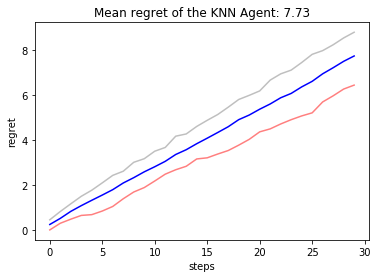

In [124]:
plt.plot(regrets_knn.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets_knn, 0.05,axis=0), color='red', alpha=0.5)
plt.plot(np.quantile(regrets_knn, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret of the KNN Agent: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

# Comparaison des performances

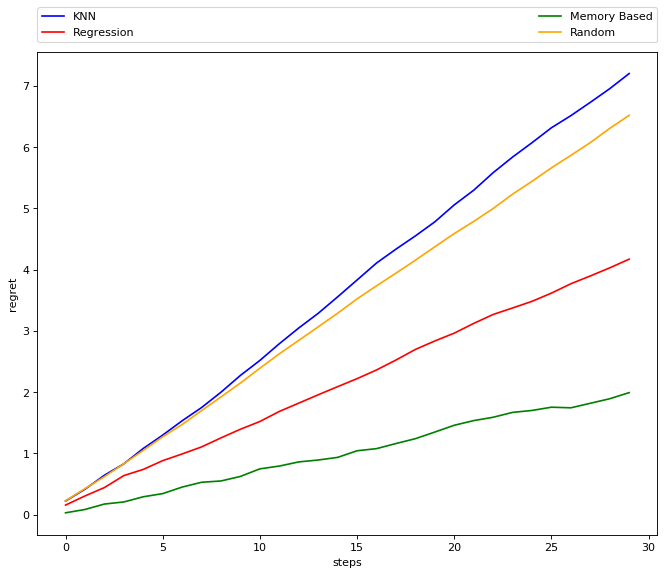

In [111]:
from matplotlib.pyplot import figure

figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(regrets_knn.mean(axis=0), color='blue', label='KNN')
plt.plot(regrets_reg.mean(axis=0), color='red', label='Regression')
plt.plot(regrets_mab.mean(axis=0), color='green', label='Memory Based')
plt.plot(regrets_random.mean(axis=0), color='orange', label='Random')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()